# Water Mission, IBM

This Notebook offers analytics of water consumption for households in Busiro, Kikondo, and Dei districts of Uganda. It helps to create and update the monthly report from World Bank Data Project. You can find list of the report sections created using this notebook in The Table of Content section below.

The Notebook processes the dataset from Uganda's districts. We assume, that dataset is a separate Excel file for each district. It should have at least 1 sheet with data named "Transaction log".

To update the dataset you should add new Excel file into Oblect Storage and write its name into proper file container.

## Table of Content
* [Library Imports and Settings](#settings)
 * [Global Variables](#variables)
 * [Library Imports](#imports)
 * [Common Figure Rendering Options](#rendering)
* [Data Pre-processing](#preprocessing)
 * [DataFrames Creation](#dataframes)
 * [Functions](#section3)
* [Section 9-10 Gaps analysis & Water Consumption by Card Trends Analysis](#section5)
  * [Correlation & Trends Analysis, Kikondo](#section6)
  * [Correlation & Trends Analysis, Busiro](#section7)
  * [Correlation & Trends Analysis, Dei](#section8)
  * [Gaps comparison by district](#section9)



# Library Imports and Settings

This section contains import statements for all the libraries used in the notebook and various configuration settings we rely on.

# Global Variables

The notebook allows you switching your environment between local environment and Bluemix cloud. 

If you run the notebook on your local system set **environment** variable to **_local_** and the path to the data file using **root** variable. If using Data Science Experience, set **environment** variable to any value different from **_local_** (for example, you may use **_bluemix_** value to make it more clear).

In [1]:
environment = 'bluemix'
root = 'c:\\sparknotes\\'
districts = ['Busiro', 'Kikondo', 'Dei', 'Chanhumba'] # Do not change
pattern = r'[a-z]' # Do not change

If using Data Science Experience, the dataset file is stored on the Bluemix cloud and we need to define credeantials for accessing it.

If you need to use another Object storage in Data Science Experience, you have to change **credentials** variable below. You may create an empty cell, click **_Find and Add Data_** menu (at the top right side), then choose **_Insert to code_** for any file and pick out **_Insert Credentials_**. New credentials will appear in the active cell. You may rename the fragment JSON to **credentials** and drop or comment the older one.

In [2]:
#@hidden_cell
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_a2fb7d55_67e7_4258_a192_04215bdfe373',
  'project_id':'dbb445bcb1014178ba6b418a8d14c2e4',
  'region':'dallas',
  'user_id':'2e7ed539b10c4b939a08b476167196de',
  'domain_id':'33dfa34c5bad4cf5b34da9def543de97',
  'domain_name':'907035',
  'username':'member_8d133283f3260061be9bb8a15c4cebfc424d2a41',
  'password':"""yLnZVC1BG&]-X7Y?""",
  'container':'WaterMissionWorldBank',
  'tenantId':'undefined',
  'filename':'Uganda Transaction logs.xlsx'
}

In [3]:
auth_url = credentials['auth_url']
container = credentials['container']
username = credentials['username']
domain_id = credentials['domain_id']
password= credentials['password']

<a id="imports"></a>
## Library Imports

In [4]:
import time
import math
from __future__ import division, print_function
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from operator import itemgetter
import pylab
from io import BytesIO
import requests
import json
import pandas as pd

from matplotlib import mlab
from __future__ import print_function
import calendar

%matplotlib inline

import matplotlib.dates as mdates
from matplotlib import rcParams
from matplotlib import mlab
import dateutil.parser as parser
from operator import itemgetter
from pandas import Grouper
from pandas import DateOffset
from pandas import Timestamp
from pandas import DatetimeIndex
import re

import warnings
warnings.filterwarnings('ignore')

<a id="rendering"></a>
## Common Figure Rendering Options

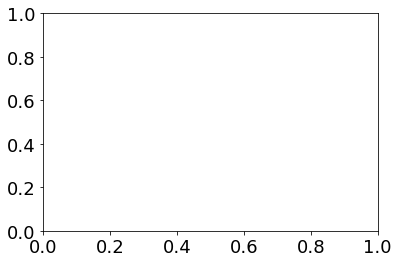

In [5]:
plt.rcParams.update({'font.size': 16})
plt.tick_params(axis='both', which='major', labelsize=18)
fig_size = plt.rcParams["figure.figsize"]
fig_size = [15, 7]
plt.rcParams["figure.figsize"] = fig_size

<a id="preprocessing"></a>
# Data Pre-processing
This section aggregates code to load data, definitions of functions used to pre-process data, and code to prepare data.

<a id="dataframes"></a>
## DataFrames Creation
In this section we load dataset file from and create DataFrame instances for the districts from corresponding tabs in the file.

In [6]:
# @hidden_cell
# This function accesses a file in your Object Storage using 'credentials' variable defined above.
def get_object_storage_file_with_credentials(container, filename, username, domain_id, password, auth_url):
    """This functions returns a BytesIO object containing the file content from Bluemix Object Storage."""

    url1 = ''.join([auth_url, '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': username,'domain': {'id': domain_id},
            'password': password}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return BytesIO(resp2.content)

def get_file_content(filename):
    if(environment == 'local'):
        return root + filename
    else:
        return get_object_storage_file_with_credentials(container, filename, username, domain_id, password, auth_url)

The next section defines the dataset to be analyzed: for each site we define a list of files to be loaded and processed. When new data is available, add the files in the corresponding lists.

In [7]:
files_Chanhumba = ['Tanzania Transaction logs - Chanhumba.xlsx']
files_Busiro = ['Uganda Transaction logs - Busiro.xlsx']
files_Kikondo = ['Uganda Transaction logs - Kikondo.xlsx']
files_Dei = ['Uganda Transaction logs - Dei.xlsx']

sheet_name = 'Transaction log' # name of the tab, that contains transaction data

The readFiles function loads files from the specified list and returns a single DataFrame object with aggregated data.

In [8]:
def readFiles(files):
    frames = []
    for file in files:
        xls = pd.ExcelFile(get_file_content(file))
        frames.append(xls.parse(sheet_name))
    return pd.concat(frames)

In [9]:
waterUsageRDD_Kikondo = readFiles(files_Kikondo)
waterUsageRDD_Busiro = readFiles(files_Busiro)
waterUsageRDD_Dei = readFiles(files_Dei)
waterUsageRDD_Chanhumba = readFiles(files_Chanhumba)

<a id="section3"></a>
# Functions
This section defines functions used for data pre-processing.

In [10]:
def createDistrictDF(districtRDD):
    districtDF = districtRDD.drop_duplicates().copy()
    districtDF.columns = ['Transaction_id','Date_and_time','Dispenser','Operation', 'Smartcard_1', 'Smartcard_2','Water_dispensed','Credits','Balance', 'Total_created']
    if(districtDF['Date_and_time'].dtype != 'datetime64[ns]'):
        districtDF['Date'] = districtDF.Date_and_time.str.slice(0,10).str.replace('-', '.')
        districtDF.Date =  pd.to_datetime(districtDF.Date, format='%d.%m.%Y')
    else:
        districtDF['Date'] = districtDF['Date_and_time'].dt.date

    
    districtDF['Smartcard_1'] = districtDF['Smartcard_1'].astype(str).str.replace('.0','')
    districtDF = districtDF[(districtDF['Smartcard_1'].str.contains(pattern) != True) & (districtDF['Smartcard_1'] != '')]
    districtDF = districtDF[districtDF.Operation == 'Water dispensed']
    districtDF.drop(['Transaction_id', 'Date_and_time', 'Dispenser', 'Operation', 'Smartcard_2', 'Credits', 'Balance', 'Total_created'], axis=1, inplace=True)
    districtDF.Water_dispensed = districtDF.Water_dispensed.astype(float)
    
    districtDF = cleanDistrictDF(districtDF)
    
    return districtDF

def processWaterTransactionRow(src):
    date = datetime.datetime.strptime(src["Date and time"], "%d-%m-%Y %H:%M:%S")
    
    s = src["Smartcard 1"]
    
    card = None if s is None else (-1 if (("working" in s) | ("promotion" in s) | ("stolen" in s)) else int(s))
    
    return Row(year=date.year, month=date.month, day=date.day, isoyear=date.isocalendar()[0], \
               isoweek=date.isocalendar()[1], weekday=date.isoweekday(), \
               transaction=src["Transaction id"], amount=src["Water dispensed"], credits=src["Credits"], \
               balance=src["Balance"], smartcard=card, operation=src["Operation"], date=date.date(), dispenser=src["Dispenser"])


def adjustDate(last_use, max_date, max_inactivity_days):
    delta = max_date - last_use
    return max_date if delta.days <= max_inactivity_days else last_use

def loadWaterTransactionData(initial_df):
    df = initial_df.copy()
    if(df['Date and time'].dtype != 'datetime64[ns]'):
        df['Date and time'] = df['Date and time'].str.slice(0,10).str.replace('-', '.')
        df['Date and time'] = pd.to_datetime(df['Date and time'], format='%d.%m.%Y')
    else:
        df['Date and time'] = df['Date and time'].dt.date
    if(df['Smartcard 1'].dtype != 'object'):
        df['Smartcard 1'] = df['Smartcard 1'].astype(str).str.replace('.0','')    
    df = df[(df['Smartcard 1'].str.contains(pattern) != True) & (df['Smartcard 1'] != '')]  
    df = df[df['Operation'] == 'Water dispensed']
    df['Smartcard 1'] = df['Smartcard 1'].astype(int)
    df = df[~df['Smartcard 1'].isin({1603, 1604, 1605, 2281, 2283, 2284, 2291, 2292, 2954})]
    df = df[['Transaction id', 'Date and time', 'Smartcard 1', 'Water dispensed', 'Credits', 'Balance', 'Operation', 'Dispenser']]
    df['year'] = pd.DatetimeIndex(df['Date and time']).year
    df['month'] = pd.DatetimeIndex(df['Date and time']).month
    df['day'] = pd.DatetimeIndex(df['Date and time']).day
    df['isoyear'] = pd.DatetimeIndex(df['Date and time']).year
    df['isoweek'] = pd.DatetimeIndex(df['Date and time']).week
    df['weekday'] = pd.DatetimeIndex(df['Date and time']).weekday
    df.columns = ['transaction', 'date', 'smartcard', 'amount', 'credits', 'balance', 'operation', 'dispenser', 'year', 'month', 'day', 'isoyear', 'isoweek', 'weekday']
    
    return df


def prepareTransactionData(initial_df):
    df = loadWaterTransactionData(initial_df)
    
    byday1 = df.groupby(['isoyear', 'isoweek', 'date', 'weekday']).amount.sum()
    byday2 = df.groupby(['isoyear', 'isoweek', 'date', 'weekday']).smartcard.nunique()
    byday3 = df.groupby(['isoyear', 'isoweek', 'date', 'weekday']).amount.count()
    byday = pd.concat([byday1, byday2, byday3], axis = 1).reset_index()
    byday.columns = ['isoyear', 'isoweek', 'date', 'weekday', 'amount', 'smartcards', 'transactions'] 
    byday['amount_per_card'] = byday.amount / byday.smartcards
  
    # calc the last date
    last_date = np.max(df.date)
    card_last_day = df.groupby(['smartcard']).date.max().reset_index()
    card_last_day.columns = ['smartcard', 'last_date']
    # update last date for 'non-stopped' cards
    card_last_day['last_date'] = card_last_day['last_date'].apply(adjustDate, args=(last_date, 28))
    
    total_num = len(df.smartcard.drop_duplicates())
    pdf = byday
    # add number of non-stopped cards into dataframe
    pdf['active_cards'] = 0
    pdf['inactive_cards'] = 0
    pdf['amount_per_active_card'] = 0
    for i in pdf.index:
        row = pdf.ix[i]
        active_num = card_last_day[(card_last_day.last_date >= row.date)].smartcard.count()
        pdf.ix[i, 'active_cards'] = active_num
        pdf.ix[i, 'inactive_cards'] = total_num - active_num
        pdf.ix[i, 'amount_per_active_card'] = row.amount / active_num
    
    return pdf

# Parsing csv and creating district dataframe

In [11]:
# Removes vendor cards from dataframe
def cleanDistrictDF(districtDF):
    cardsToRemove = ['1603', '1604', '1605', '2281', '2283', '2284', '2291', '2292', '2954']
    districtDF = districtDF[~districtDF.Smartcard_1.isin(cardsToRemove)]
    
    return districtDF

# Parses csv data and creates dataframe

def getStopCardsList(stopCardRDD, district):
    
    #splitted = stopCardRDD.map(lambda l: l.split(",")).filter(lambda l: l[0] if district in l[0] else 0)
    
    #stopCardsDF = sqlContext.createDataFrame(splitted,['Dispenser','Smartcard']).toPandas()[1:]
    stopCardsDF = stopCardRDD.drop('Dispenser', 1)
    stopCardsDF = stopCardsDF.drop_duplicates()
    stopCardsList = list(stopCardsDF.Smartcard)
    
    return stopCardsList

# Creating fulltime (from earliest date from dataset to oldest) empty dataframe

It's needed to update smartcard data for creating similar period of usage for all cards

In [12]:
# Creates fulltime (from earliest date from dataset to oldest) empty dataframe
def createFullPeriodDF(districtDF):
    
    periodStartDate = districtDF.Date.min()
    periodEndDate = districtDF.Date.max()
    delta = (periodEndDate - periodStartDate).days + 1
    fullPeriodDF = pd.DataFrame(columns=['Date'])
    fullPeriodDF['Date'] = pd.date_range(periodStartDate, periods=delta)
    
    return fullPeriodDF

# Updating and getting card data section

Here we merge empty fullperiod dataset with card data and add additional field - MA (Moving Average values). It's needed for having more smooth water usage on plots and for gaps analysis needs

In [13]:
# Moving Average calculation
def movingAverage(values,window):
    weigths = np.repeat(1.0, window)/window
    smas = np.convolve(values, weigths, 'valid')
    
    data = []
    values_sum = 0
    for i in range (0,window-1):
        values_sum = values_sum + values[i]
        value = values_sum / (i+1)
        data.append(value)

    for i in smas:
        data.append(i)
        
    return data
 
# Returns list of unique district cards
def getCardsByDistrict(districtDF):
    districtDF.Smartcard_1 = districtDF.Smartcard_1.astype(int).astype(str)
    cards = list(districtDF.Smartcard_1.drop_duplicates().dropna())
    cards.sort()
    return cards
    
# Updates card information - creates fulltime card dataframe with moving average field 
def updateCardData(card, districtDF, fullPeriodDF, maWindow):
    cardDF = districtDF[districtDF.Smartcard_1 == card]
    cardDF.sort_values('Date', ascending = False)
    
    fullPeriodDF_Copy = fullPeriodDF.copy()
    fullPeriodDF_Copy['Smartcard_1'] = card
    fullPeriodDF_Copy = pd.merge(fullPeriodDF_Copy, cardDF, on=['Date', 'Smartcard_1'], how='left')
    fullPeriodDF_Copy = fullPeriodDF_Copy.fillna(0.0)
    result = fullPeriodDF_Copy.groupby(['Date', 'Smartcard_1']).Water_dispensed.sum().reset_index()
    customMA = movingAverage(result.Water_dispensed, maWindow)
    result['MA'] = customMA
    
    return result

def getCardData(card, districtDF):
    cardDF = districtDF[districtDF.Smartcard_1 == card]
    cardDF.sort_values('Date', ascending = False).reset_index()
    
    return cardDF.reset_index()

Here we clean district dataframe - we don't need several fields in it

In [14]:
# Removes vendor cards from dataframe
def cleanDataframeFromStoppedCards(districtDF, stoppedCardsList):
    districtDF = districtDF[~districtDF.Smartcard_1.isin(stoppedCardsList)]
    return districtDF

def getCleanedAndSortDF(cards, districtDF, fullPeriodDF, maWindow):
    
    cleanedAndSortDF = pd.DataFrame(columns=['Smartcard_1', 'Water_dispensed', 'MA','Date'])
    for card in cards:
        cardDF = updateCardData(card, districtDF, fullPeriodDF, maWindow)
        cardDF.reset_index()
        cleanedAndSortDF = cleanedAndSortDF.append(cardDF)
    
    return cleanedAndSortDF

# Finding gaps section
We go through district dataframe cards and searching gaps more than gapDuration

In [15]:
#Checking card on gap periods, that bigger than gapDuration
def findGapPeriods(cardData, gapDuration):
    
    usageFactsDF = cardData[cardData['MA'] > 0]
    usageDates = list(usageFactsDF.Date)
    gapList = []
    
    for index in range(1,len(usageDates)):
        if (usageDates[index] - usageDates[index - 1]).days > gapDuration:
            gapList.append((cardData.Smartcard_1.max(), usageDates[index - 1], usageDates[index]))
    
    return gapList

def findGaps(cards, districtDF, fullPeriodDF, gapDurations):   
    gaps = []

    for duration in gapDurations:
        cardsWithGaps = []
        cardsWithoutGaps = []
        cardsWithOneGap = []

        for card in cards:    
            cardData = getCardData(card, districtDF)
            gapList = findGapPeriods(cardData, duration)
            if len(gapList) > 1:
                cardsWithGaps += gapList
            elif len(gapList) == 0:
                cardsWithoutGaps.append(card)
            else:
                cardsWithOneGap += gapList
        gaps.append((cardsWithGaps, cardsWithOneGap, cardsWithoutGaps))
    return gaps

# Find trends section
<b>findTrends</b> is entry point of trends analysis

<b>findAbnormalContinuousUsage</b> function is searching long periods of water consumption, that more than water consumption mean value or less than mean value, cleaned it and return list of trend periods

In [16]:
def connectedPeriodsCreate(targetPeriods, reportingPeriodTerm, connectedPeriodTerm):
    connectedPeriod = ()
    reportingPeriods = []
    for index in range(len(targetPeriods)):
        if len(connectedPeriod) == 0:
            if (targetPeriods[index][1] - targetPeriods[index][0]).days >= reportingPeriodTerm:
                if index + 1 < len(targetPeriods) and \
                                        ((targetPeriods[index + 1][0] - targetPeriods[index][1]).days <= connectedPeriodTerm):

                    connectedPeriod = (targetPeriods[index][0], targetPeriods[index + 1][1], targetPeriods[index][2])
                    
                else:                        
                    reportingPeriods.append(targetPeriods[index])
            else:
                if index + 1 < len(targetPeriods) and \
                                        ((targetPeriods[index + 1][0] - targetPeriods[index][1]).days <= connectedPeriodTerm):

                    connectedPeriod = (targetPeriods[index][0], targetPeriods[index + 1][1], targetPeriods[index][2])
        else:
            if (connectedPeriod[1] - connectedPeriod[0]).days >= reportingPeriodTerm:
                if index + 1 < len(targetPeriods) and ((targetPeriods[index + 1][0] - connectedPeriod[1]).days <= connectedPeriodTerm):                            
                    connectedPeriod = (connectedPeriod[0], targetPeriods[index + 1][1], connectedPeriod[2])
                else:
                    reportingPeriods.append(connectedPeriod)
                    connectedPeriod = ()
            else:
                if (index + 1 < len(targetPeriods)) and ((targetPeriods[index + 1][0] - connectedPeriod[1]).days <= connectedPeriodTerm):
                    connectedPeriod = (connectedPeriod[0], targetPeriods[index + 1][1], connectedPeriod[2])
                else:
                    connectedPeriod = ()
                        
    return reportingPeriods

def findAbnormalContinuousUsage(data, reportingPeriodTerm,connectedPeriodTerm):
    tmpDF = pd.DataFrame(columns=['Date', 'MA'])
    tmpDF['Date'] = data['Date']
    tmpDF['MA'] = data['MA']
    
    notNullUsages = tmpDF[tmpDF.MA > 0]
    
    mean = tmpDF.MA.mean()
    startDate = notNullUsages.Date.min()
    endDate = notNullUsages.Date.max()
    
    abnormalPeriods = []
    periodMarker = False
    periodTrend = ''
    periodStartDate = ''
    periodEndDate = ''
    periodMA = []
    
    for row in tmpDF.itertuples():
        if row.Date >= startDate:
            if row.MA >= mean:
                if periodTrend == 'over':
                    periodEndDate = row.Date
                    periodMA.append(row.MA)
                elif periodTrend == 'under':
                    abnormalPeriods.append((periodStartDate, periodEndDate, periodTrend))
                    periodMA = []
                    periodMA.append(row.MA)
                    periodTrend = 'over'
                    periodStartDate = row.Date
                    periodEndDate = row.Date
                else:
                    periodMA.append(row.MA)
                    periodTrend = 'over'
                    periodStartDate = row.Date
                    periodEndDate = row.Date
            else:
                
                if periodTrend == 'under':
                    periodEndDate = row.Date
                    periodMA.append(row.MA)
                elif periodTrend == 'over':
                    abnormalPeriods.append((periodStartDate, periodEndDate, periodTrend))
                    periodMA = []
                    periodMA.append(row.MA)
                    periodTrend = 'under'
                    periodStartDate = row.Date
                    periodEndDate = row.Date
                else:
                    periodMA.append(row.MA)
                    periodTrend = 'under'
                    periodStartDate = row.Date
                    periodEndDate = row.Date
        if row.Date >= endDate:
            abnormalPeriods.append((periodStartDate, periodEndDate, periodTrend))
            break
    
    overMeanPeriods = []
    underMeanPeriods = []
    for period in abnormalPeriods:
        if period[2] == 'over':
            overMeanPeriods.append(period)
        else:
            underMeanPeriods.append(period)
            
    overMeanPeriods = connectedPeriodsCreate(overMeanPeriods, reportingPeriodTerm, connectedPeriodTerm)
    underMeanPeriods = connectedPeriodsCreate(underMeanPeriods, reportingPeriodTerm, connectedPeriodTerm)
    
    summaryList = overMeanPeriods + underMeanPeriods
    summaryList.sort(key=lambda tup: tup[0])
    cleanedList = []
   
    index = 0
    while index < len(summaryList):
        if index + 1 < len(summaryList):
            if summaryList[index][2] == summaryList[index + 1][2]:
                cleanedList.append((summaryList[index][0], summaryList[index + 1][1], summaryList[index][2]))
                index += 2
            else:
                cleanedList.append(summaryList[index])
                index += 1
        else:
            cleanedList.append(summaryList[index])
            index += 1
    
    index = 0
    while index < len(cleanedList):
        if index + 1 < len(cleanedList):
            if cleanedList[index][1] > cleanedList[index + 1][0]:
                if (cleanedList[index][1] - cleanedList[index][0]).days > (cleanedList[index + 1][1] - cleanedList[index + 1][0]).days:
                    if (cleanedList[index + 1][1] - cleanedList[index][1]).days < reportingPeriodTerm:
                        cleanedList[index + 1] = ()
                        index +=2
                    else:
                        cleanedList[index + 1] = (cleanedList[index][1], cleanedList[index + 1][1], cleanedList[index + 1][2])
                        index +=1
                else:
                    if (cleanedList[index + 1][0] - cleanedList[index][0]).days < reportingPeriodTerm:
                        cleanedList[index] = ()
                        index +=2
                    else:
                        cleanedList[index] = (cleanedList[index][0], cleanedList[index + 1][0], cleanedList[index][2])
                        index +=1
            else:
                index +=1
        else:
                index +=1
                
    cleanedList = [x for x in cleanedList if x != ()]
    periodMeans = []
    
    for period in cleanedList:
            periodMean = tmpDF[(tmpDF.Date > period[0]) & (tmpDF.Date < period[1])].MA.mean()
            periodMeans.append(periodMean)
       
    periodMins = []
    for item in periodMeans:
        if item < mean * 0.15:
            periodMins.append(item)
            
        
    if len(periodMins) > 0:
        for item in periodMins:
            periodIndex = periodMeans.index(item)
            cleanedList[periodIndex] = ()
            periodMeans.remove(item)
        
    if len(periodMeans) > 1:  
        maxMean = max(periodMeans)
        minMean = min(periodMeans)
        if maxMean <= minMean * 3:
            cleanedList = []
    else:
        cleanedList = [] 
        
    cleanedList = [x for x in cleanedList if x != ()]    
            
    if len(cleanedList) > 4:
        cleanedList = []
    elif len(cleanedList) == 0:
        cleanedList = []
    else:       
        for period in cleanedList:
            periodMean = tmpDF[(tmpDF.Date > period[0]) & (tmpDF.Date < period[1])].MA.mean()
            periodMeans.append(periodMean)

        maxMean = max(periodMeans)
        minMean = min(periodMeans)

        if maxMean <= minMean * 3:  
            cleanedList = []
        else:
            lastPeriodEndDate = cleanedList[-1][1]
            meanAfterLastPeriod = tmpDF[tmpDF.Date > lastPeriodEndDate].MA.mean()
            if cleanedList[-1][2] == 'over' and meanAfterLastPeriod < mean:
                cleanedList = []
            elif cleanedList[-1][2] == 'under' and meanAfterLastPeriod >= mean:
                cleanedList = []
    return cleanedList

def findTrends(cards, districtDF, reportingPeriodTerm, connectedPeriodTerm, stoppedCardsList):
    
    resultCards = []
    cardsWithPlatoes = []
    cardsWithOverUnderTrend = []
    cardsWithUnderOverTrend = []
    
    cleanedDF = cleanDataframeFromStoppedCards(districtDF, stoppedCardsList)
    
    for card in cards:
        resultCards.append(card)

    for card in resultCards:
        cardData = getCardData(card, cleanedDF)

        platoes = findAbnormalContinuousUsage(cardData, reportingPeriodTerm, connectedPeriodTerm)
        if len(platoes) > 0:
            cardsWithPlatoes.append((card, platoes))
        platoes = []

    for card in cardsWithPlatoes:
        if not card[1][0][2] == card[1][-1][2]:
            if card[1][0][2] == 'over':            
                cardsWithOverUnderTrend.append(card)
            else:
                cardsWithUnderOverTrend.append(card)
    return (cardsWithOverUnderTrend, cardsWithUnderOverTrend)

# Gaps - Agricultural seasons analysis section

Here we set agricultural seasons and find number of water consumption gaps in each

In [17]:
def createAgriculturalSeasonsDF():
    
    agriSeasonsDF = pd.DataFrame(columns=['Name', 'SeasonStart', 'SeasonEnd'])
    agriSeasonsDF.loc[0] = ['1 Land prepand dry sowing - Jan,01 - Feb,28', '2000-01-01', '2000-02-28']
    agriSeasonsDF.loc[1] = ['2 First planting - Mar,01 - Apr,30', '2000-03-01', '2000-04-30']
    agriSeasonsDF.loc[2] = ['3 First weeding - May,01 - May,31', '2000-05-01', '2000-05-31']
    agriSeasonsDF.loc[3] = ['4 First season harvest - Jun,01 - Jul,31', '2000-06-01', '2000-07-31']
    agriSeasonsDF.loc[4] = ['5 Land prep and second plant - Aug,01 - Sep,30', '2000-08-01', '2000-09-30']
    agriSeasonsDF.loc[5] = ['6 Second weeding - Oct,01 - Oct,31', '2000-10-01', '2000-10-31']
    agriSeasonsDF.loc[6] = ['7 Second season harvest - Nov,01 - Dec,31', '2000-11-01', '2000-12-31']
    
    agriSeasonsDF.SeasonStart =  pd.to_datetime(agriSeasonsDF.SeasonStart, format='%Y-%m-%d')
    agriSeasonsDF.SeasonEnd =  pd.to_datetime(agriSeasonsDF.SeasonEnd, format='%Y-%m-%d')

    return agriSeasonsDF

def createRainSeasonsDF():
    
    rainSeasonsDF = pd.DataFrame(columns=['Name', 'SeasonStart', 'SeasonEnd'])
    rainSeasonsDF.loc[0] = ['8 First rainy season - Mar,01 - May,31', '2000-03-01', '2000-05-31']
    rainSeasonsDF.loc[1] = ['9 Second rainy season - Sep, 01 - Nov,30', '2000-09-01', '2000-11-30']
    
    rainSeasonsDF.SeasonStart =  pd.to_datetime(rainSeasonsDF.SeasonStart, format='%Y-%m-%d')
    rainSeasonsDF.SeasonEnd =  pd.to_datetime(rainSeasonsDF.SeasonEnd, format='%Y-%m-%d')

    return rainSeasonsDF

def compareDatesFull(season, gap):
    
    gapDuration = (gap[2] - gap[1]).days
            
    if not season[0] == '8 First rainy season' and not season[0] == '9 Second rainy season' and gapDuration > 60:
        return 
    elif gapDuration > 90:
        return
    season[1] = season[1].replace(year=gap[1].year)
    season[2] = season[2].replace(year=gap[1].year)
    seasonStartMonthDay = (season[1].month, season[1].day)
    seasonEndMonthDay = (season[2].month, season[2].day)
    gapStartMonthDay = (gap[1].month, gap[1].day)
    gapEndMonthDay = (gap[2].month, gap[2].day)       

    match = False
    
    if gapStartMonthDay[0] >= seasonStartMonthDay[0] and gapStartMonthDay[0] <= seasonEndMonthDay[0]: 
        if gapStartMonthDay[0] == seasonEndMonthDay[0]:
            restOfSeason = (season[2] - gap[1]).days
            if restOfSeason * 2 > gapDuration:
                match = True
        else:
            match = True
    elif gapEndMonthDay[0] >= seasonStartMonthDay[0] and gapEndMonthDay[0] <= seasonEndMonthDay[0]:
        if not gap[1].year == gap[2].year:
            season[1] = season[1].replace(year=gap[2].year)
        if (gap[2] - season[1]).days > gapDuration / 2:
            match = True                

    if match:
        return season[0]
    
    return 

def findMatchesWithAgriSeasons(x, agriSeasons):
    agriSeasonMatchDF = pd.DataFrame(columns=['Name'])
    agriSeasonMatchDF.Name = agriSeasons.apply(lambda season: compareDatesFull(season, x), axis = 1)
    agriSeasonMatchDF_tmp = agriSeasonMatchDF[agriSeasonMatchDF.Name.notnull()]
    
    return agriSeasonMatchDF_tmp.min()

def findMatchesWithRainSeasons(x, rainSeasons):
    rainSeasonMatchDF = pd.DataFrame(columns=['Name'])    
    rainSeasonMatchDF.Name = rainSeasons.apply(lambda season: compareDatesFull(season, x), axis = 1)
    rainSeasonMatchDF_tmp = rainSeasonMatchDF[rainSeasonMatchDF.Name.notnull()]
    
    return rainSeasonMatchDF_tmp.min()

def gapsByPeriodAggregation(gap, weatherDF, periods, period):
    gapDuration =  (gap[2] - gap[1]).days
    periodOfGapStart = weatherDF[weatherDF.Period <= gap[1]].max()
    periodOfGapEnd = weatherDF[weatherDF.Period <= gap[2]].max()
    numberOfPeriods = int(math.ceil(gapDuration / period))
    
    periodIndex = -1
    movedPeriod = False
    
    periodDF = weatherDF[(weatherDF.Period >= periodOfGapStart.Period) & (weatherDF.Period <= periodOfGapEnd.Period)]
    periodLastIndex = periodDF[periodDF.Period == periodDF.Period.max()].index.min()
    lastPeriod = weatherDF.iloc[[periodLastIndex]]
    lastPeriodEnd = lastPeriod.Period.min() + pd.DateOffset(days = period - 1)
    
    for rainPeriod in periodDF.itertuples():
        rainPeriodEnd = rainPeriod.Period + pd.DateOffset(days = period - 1) 
        if gapDuration < 30:
            criteria = period / 4
            lastPeriodCriteria = period / 4
        else:
            criteria = 30 / 4
            lastPeriodCriteria = (lastPeriodEnd - lastPeriod.Period.min()).days / 4
        
        if not movedPeriod:
            if (rainPeriodEnd - gap[1]).days > criteria:

                periodIndex = rainPeriod.Index
                
                if not gap[2].to_datetime().month == lastPeriodEnd.to_datetime().month:
                    
                    if (gap[2] - lastPeriod.Period.min()).days > lastPeriodCriteria:
                        
                        for i in range (periodIndex, periodLastIndex + 1):
                            if i < len(periods):
                                periods[i] += 1
                        break
                    else:
                        for i in range (periodIndex, periodLastIndex):
                            if i < len(periods):
                                periods[i] += 1
                        break
                else:
                    if not gap[2].to_datetime().day < lastPeriodCriteria:

                        for i in range (periodIndex, periodLastIndex + 1):
                            if i < len(periods):
                                periods[i] += 1
                        break
                    else:
                        for i in range (periodIndex, periodLastIndex):
                            if i < len(periods):
                                periods[i] += 1
                        break
            else:            
                movedPeriod = True
        else:
            periodIndex = rainPeriod.Index
            movedPeriod = False
            
            if not gap[2].to_datetime().month == lastPeriodEnd.to_datetime().month:
                    
                if (gap[2] - lastPeriod.Period.min()).days > lastPeriodCriteria:

                    for i in range (periodIndex, periodLastIndex + 1):
                        if i < len(periods):
                            periods[i] += 1
                    break
                else:
                    for i in range (periodIndex, periodLastIndex):
                        if i < len(periods):
                            periods[i] += 1
                    break
            else:

                if not gap[2].to_datetime().day < lastPeriodCriteria:

                    for i in range (periodIndex, periodLastIndex + 1):
                        if i < len(periods):
                            periods[i] += 1
                    break
                else:
                    for i in range (periodIndex, periodLastIndex):
                        if i < len(periods):
                            periods[i] += 1
                    break
    return

def gapsForSpeiAggregation(gap, periods, period):
    startMoved = False
    dontCheckEnd = False
    
    if not gap.StartYear == gap.EndYear:
        duration = 12 - gap.StartMonth
        dontCheckEnd = True
    else:
        duration = gap.EndMonth - gap.StartMonth
        
    if not dontCheckEnd:
        if gap.gapEnd.day < period / 4:
            duration -= 1
            
    if gap.gapStart.days_in_month - gap.gapStart.day < period / 4:
        startOfGap = gap.StartMonth
        startMoved = True
    else:
        startOfGap = gap.StartMonth - 1
        
    if startMoved:
        for i in range(startOfGap, startOfGap + duration):
            if i < len(periods):
                periods[i] += 1
    else:
        for i in range(startOfGap, startOfGap + duration + 1):
            if i < len(periods):
                periods[i] += 1
    
    return

Load and get weather data utility functions

In [18]:
def addMissedWeatherData(grouped, fullWeatherDF):
    for name, group in grouped:
        tmp = group.head(1)
        firstDate = pd.datetime(tmp.year, tmp.month, tmp.day)
        firstDateTimestamp = pd.Timestamp(firstDate)
        daysInMonth = firstDateTimestamp.days_in_month
        days = []
        for row in group.itertuples():
            index = row.day - 1
            days.append({'day': row.day, 'isoweek': row.isoweek, 'isoyear': row.isoyear, 'max_temperature': row.max_temperature, 'month': row.month, 'rainfall': row.rainfall, 'temperature': row.temperature, 'year': row.year})

        firstValue = days[0]
        if not firstValue['day'] == 1:
            deltaDays = firstValue['day'] - 1
            for index in range(1, deltaDays + 1):
                days.append({'day': index, 'isoweek': firstValue['isoweek'], 'isoyear': firstValue['isoyear'], 'max_temperature': firstValue['max_temperature'], \
                             'month': firstValue['month'], 'rainfall': firstValue['rainfall'], 'temperature': firstValue['temperature'], 'year': firstValue['year']})
        days.sort(key=lambda x: x['day'], reverse=False)

        previousValue = days[0]

        missedDays = []

        for index in range(1,len(days)):
            if not days[index]['day'] == previousValue['day'] + 1:
                for i in range(previousValue['day'] + 1, days[index]['day']):
                    missedDays.append({'day': i, 'isoweek': previousValue['isoweek'], 'isoyear': previousValue['isoyear'], 'max_temperature': previousValue['max_temperature'], \
                             'month': previousValue['month'], 'rainfall': previousValue['rainfall'], 'temperature': previousValue['temperature'], 'year': previousValue['year']})
            previousValue = days[index]

        days += missedDays
        days.sort(key=lambda x: x['day'], reverse=False)
        
        tmpDF = pd.DataFrame(days)
        
        fullWeatherDF = pd.concat([fullWeatherDF, tmpDF]).reset_index(drop = True)
    
    return fullWeatherDF

def returnDateFromSource(year, month, day):
    date = pd.datetime(int(year), int(month), int(day))
    return date

def getPeriodicRainfallData(weatherDF, period):
    tmpDF = weatherDF.groupby(Grouper(key='Date', freq= str(period) + 'D')).rainfall.sum()
    rf = pd.DataFrame(tmpDF).reset_index()
    rf.columns = ['Period', 'Rainfall']

    return rf

def getPeriodicMaxTemperatureData(weatherDF, period):
    tmpDF = weatherDF.groupby(Grouper(key='Date', freq= str(period) + 'D')).max_temperature.sum()
    rf = pd.DataFrame(tmpDF).reset_index()
    rf.columns = ['Period', 'Max_Temperature']

    return rf

def getPeriodicAvgTemperatureData(weatherDF, period):
    tmpDF = weatherDF.groupby(Grouper(key='Date', freq= str(period) + 'D')).temperature.sum()
    rf = pd.DataFrame(tmpDF).reset_index()
    rf.columns = ['Period', 'Avg_Temperature']

    return rf


# Creating dataframes for plots

In [19]:
def createAgriculturalPlotsDF(districtGapsSummaryDF):
    districtAgriMatchDF = districtGapsSummaryDF.copy()
    districtRainMatchDF = districtGapsSummaryDF.copy()
    
    agriculturalSeasonsDF = createAgriculturalSeasonsDF()
    rainSeasonsDF = createRainSeasonsDF()

    districtAgriMatchDF['SeasonMatch'] = districtAgriMatchDF.apply(lambda x: findMatchesWithAgriSeasons(x, agriculturalSeasonsDF), axis = 1)
    districtRainMatchDF['SeasonMatch'] = districtRainMatchDF.apply(lambda x: findMatchesWithAgriSeasons(x, rainSeasonsDF), axis = 1)
    
    districtAgriMatchDF = districtAgriMatchDF[districtAgriMatchDF['SeasonMatch'].notnull()].reset_index(drop=True)
    districtRainMatchDF = districtRainMatchDF[districtRainMatchDF['SeasonMatch'].notnull()].reset_index(drop=True)
    
    districtSeasonsMatchedDF = pd.concat([districtAgriMatchDF, districtRainMatchDF])
    
    districtSeasonsDF = districtSeasonsMatchedDF.groupby('SeasonMatch').card.count().reset_index()
    districtSeasonsDF.columns = ['Season', 'Gaps in a season']
    
    return districtSeasonsDF

def createAgriculturalPlotsDF_Month(districtGapsSummaryDF):
    districtMatch = districtGapsSummaryDF.copy()
    districtMatch['MonthStart'] = districtMatch.gapStart.map(lambda x: x.to_datetime().month)
    districtMatch['MonthEnd'] = districtMatch.gapEnd.map(lambda x: x.to_datetime().month)
    m1 = districtMatch[(districtMatch.MonthStart <= 1) & (districtMatch.MonthEnd >= 1)]
    
    dataArr = []
    for i in range(1, 13):
        d = districtMatch[(districtMatch.MonthStart <= i) & (districtMatch.MonthEnd >= i)]
        dataArr.append((i, len(d)))
    
    df2 = pd.DataFrame.from_records(dataArr, columns = ['Season', 'Gaps'])
    
    return df2

def createWeatherPlotsDF(weatherDF, tmpGapsDF, period, weatherProp):
    
    districtGapsWeatherCorrDF = tmpGapsDF.copy()
        
    if weatherProp == 'rainfall':
        weatherPeriodicalDF = getPeriodicRainfallData(weatherDF, period)
        label = 'Rainfall'
    elif weatherProp == 'maxTemp':
        weatherPeriodicalDF = getPeriodicMaxTemperatureData(weatherDF, period)
        label = 'Max_Temperature'
    else:
        weatherPeriodicalDF = getPeriodicAvgTemperatureData(weatherDF, period)
        label = 'Avg_Temperature'
    
    periods = [0] * weatherPeriodicalDF.Period.count()
    districtGapsWeatherCorrDF.apply(lambda gap: gapsByPeriodAggregation(gap, weatherPeriodicalDF, periods, period), axis=1)
    weatherGapsDF = pd.DataFrame(periods)
    weatherGapsDF.columns = ['Gaps']
    gapsWeatherDF = pd.concat([weatherPeriodicalDF, weatherGapsDF], axis=1, join_axes=[weatherPeriodicalDF.index])
    notNullValues = gapsWeatherDF[gapsWeatherDF.Gaps > 0]
    firstNotNull = notNullValues.index.get_values()[0]
    
    if period == 10:
        periodsToRemove = firstNotNull + 3
    else:
        periodsToRemove = firstNotNull + 2

    gapsWeatherDF.drop(gapsWeatherDF.index[:periodsToRemove], inplace = True)
    gapsWeatherDF = gapsWeatherDF[:-1]
    forCorr = gapsWeatherDF.drop(gapsWeatherDF.columns[[0]], axis=1)
    coeff = forCorr.corr()
    normalize(gapsWeatherDF, [label, "Gaps"])
    
    print("coef=", period)
    print(coeff)
    
    return gapsWeatherDF

def createSpeiPlotsDF(speiDF, tmpGapsDF, period, year, district):
    
    corrDF = tmpGapsDF.copy()
    corrDF['StartYear'] = pd.DatetimeIndex(corrDF['gapStart']).year
    corrDF['StartMonth'] = pd.DatetimeIndex(corrDF['gapStart']).month
    corrDF['EndYear'] = pd.DatetimeIndex(corrDF['gapEnd']).year
    corrDF['EndMonth'] = pd.DatetimeIndex(corrDF['gapEnd']).month
    
    periods = [0] * speiDF.DATA.count()
    corrDF.apply(lambda gap: gapsForSpeiAggregation(gap, periods, period), axis=1)
    
    gapsDF = pd.DataFrame(periods)
    gapsDF.columns = ['Gaps']
    gapsSpeiDF = pd.concat([speiDF, gapsDF], axis=1, join_axes=[speiDF.index])
    
    notNullValues = gapsSpeiDF[gapsSpeiDF.Gaps > 0]
    firstNotNull = notNullValues.index.get_values()[0]
    
    periodsToRemove = firstNotNull + 2

    gapsSpeiDF.drop(gapsSpeiDF.index[:periodsToRemove], inplace = True)
    gapsSpeiDF = sqlContext.createDataFrame(gapsSpeiDF)
    
    labels = []
    values = []
    for i in range(1, 49):
        labels.append(str(i))
        values.append(gapsSpeiDF.corr("Gaps", "SPEI_" + str(i)))

    coeff = pd.DataFrame({'SPEI index' : labels, 'Correlation coefficient' : values})
    
    return coeff

def getCardsWithGaps(cardsDF):
    cards = list(districtDF.card.drop_duplicates())
    return cards

def getTimeScaleDF(fulltimeDF, gapsDF):
    
    gapStarts = list(gapsDF.gapStart)
    gapEnds = list(gapsDF.gapEnd)
    
    ftCopy = fulltimeDF.copy()
    ftCopy.columns = ['date']
    ftCopy['gaps'] = 0
    for i in range(0, len(gapStarts)):
        gapStart = gapStarts[i]
        gapEnd = gapEnds[i]
        gapsTime = ftCopy[(ftCopy.date >= gapStart) & (ftCopy.date <= gapEnd)]
        indList = gapsTime.index.values
        
        for ind in indList:
            ftCopy.set_value(ind, 'gaps', ftCopy.iloc[ind]['gaps'] + 1)
    
    return ftCopy

# Plotting section

In [20]:
def adjust(v, base, mult):
    return (v - base) / mult

def normalize(df, columns):
    for column in columns:
        minv = df[column].min()
        maxv = df[column].max()

        avg = df[column].mean()
        
        mindist = abs(avg - minv)
        maxdist = abs(maxv - avg)

        vrange = maxdist if maxdist > mindist else mindist

        df[column] = df[column].apply(adjust, args=(avg, vrange))
        
def plotAgriculturalDF2(districtGapsSummaryDFList, district):
    width = 0.2
    dataArr = []
    fig, ax = plt.subplots()
    
    for i in range(0, len(districtGapsSummaryDFList)):
        data = createAgriculturalPlotsDF_Month(districtGapsSummaryDFList[i])
        dataArr.append(data)
       
    df = pd.merge(dataArr[0],dataArr[2],on='Season', how='outer')
    df = df.fillna(0)
    df.columns=['Season', '10+ day gaps', '30+ day gaps']
    df['10+ day gaps'] = df['10+ day gaps'].astype(int)
    df['30+ day gaps'] = df['30+ day gaps'].astype(int)
    df.index = df.Season
    df = df[['10+ day gaps', '30+ day gaps']]

    fig = plt.figure()
    ax1 = df.plot(kind='bar', title='Gaps during agricultural seasons')
    ax1.set_ylabel('Number of gaps')
    ax1.set_xlabel('Months')
    ax1.xaxis.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
    ax1.legend (("10+ day gaps", '30+ day gaps'), bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0., fontsize=15)
    plt.ylim(ymin=0)
    plt.show()
    return df

def plotAgriculturalDF(districtGapsSummaryDFList, district):

    width = 0.2
    dataArr = []
    fig, ax = plt.subplots()
    
    for i in range(0, len(districtGapsSummaryDFList)):
        data = createAgriculturalPlotsDF_Month(districtGapsSummaryDFList[i])
        dataArr.append(data)
       
    df = pd.merge(dataArr[0],dataArr[2],on='Season', how='outer')
    df = df.fillna(0)
    df.columns=['Season', '10+ day gaps', '30+ day gaps']
    df['10+ day gaps'] = df['10+ day gaps'].astype(int)
    df['30+ day gaps'] = df['30+ day gaps'].astype(int)
    df.index = df.Season
    df = df[['10+ day gaps', '30+ day gaps']]

    d = [(1, -10), (2, -10), (3, -10), (4, -10), (5, -10), (6, -10), (7, -10), (8, -10), (9, -10), (10, -10), (11, -10), (12, -10)]
    df2 = pd.DataFrame.from_records(d, columns = ['Month', 'Season'])
    df2 = df2[['Season']]

    fig = plt.figure() # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twiny() # Create another axes that shares the same x-axis as ax.

    width = 1

    df.plot(kind='bar', ax=ax, width=width, position=0)
    df2.plot(kind='bar', ax=ax2, width=2.5, position=0)

    ax.set_ylabel('Number of gaps')
    ax.set_xlabel('Months')
    ax.xaxis.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
    ax.legend (("10+ day gaps", '30+ day gaps'), bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0., fontsize=15)

    plt.show()
    return df

def plotNormalizedDF(districtPlotDF, district):
    
    normalizedDF = districtPlotDF.copy()
    normalizedDF['Number of gaps'] = normalizedDF['Number of gaps'] / normalizedDF['Number of gaps'].sum() * 100
    
    normalizedDF.plot(x='Season', y='Number of gaps', kind='Barh', title ="Gaps during agricultural seasons (normalized), " + district, \
                figsize=(15,6), legend=True, fontsize=16)
    plt.xticks(rotation=90)
    plt.axes().set_xlabel('Percents', fontsize=16)
    plt.show()
    
    return

def plotWeatherDF(weatherDF, districtGapsSummaryDF, period, weatherProp, district):
    
    tmpGapsDF = districtGapsSummaryDF.copy()
    tmpGapsDF = tmpGapsDF.sort_values(by='gapStart', ascending=1)
    
    gapsWeatherDF = createWeatherPlotsDF(weatherDF, tmpGapsDF, period, weatherProp)
    gapsWeatherDF = gapsWeatherDF[gapsWeatherDF.Period < '2017-02-01']
    if weatherProp == 'rainfall':
        y_label = 'Rainfall'
        prop_title = 'Rainfall'
    elif weatherProp == 'maxTemp':
        y_label = 'Max_Temperature'
        prop_title = 'Max Temperature'
    else:
        y_label = 'Avg_Temperature'
        prop_title = 'Average Temperature'
    print(gapsWeatherDF[len(gapsWeatherDF) - 5:])
    gapsWeatherDF.plot(x = "Period", y = [y_label, 'Gaps'],kind='line', title = prop_title + " information compared to amount of water consumption gaps (gap = " + str(period) + "), " + district, \
                figsize=(20,6), legend=True, fontsize=16)
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    
    plt.rcParams.update({'font.size': 16})
    plt.xlabel('Date', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    return 

def plotSPEIDF(speiDF, districtGapsSummaryDF, period, year, district):
    
    tmpGapsDF = districtGapsSummaryDF.copy()
    tmpGapsDF = tmpGapsDF.sort_values(by='gapStart', ascending=1)   
    
    maxDate = pd.datetime(year + 1, 1, 1)
    tmpGapsDF = tmpGapsDF[tmpGapsDF.gapStart < maxDate]
    tmpSpeiDF = speiDF[speiDF.year == year]
    
    plotDF = createSpeiPlotsDF(tmpSpeiDF, tmpGapsDF, period, year, district)
    
    ax = plotDF.plot(x='SPEI index', kind='line', title ="Correlation between SPEI indexes and water consumption gaps", \
                    figsize=(15,6), legend=True, fontsize=16, grid=True, x_compat=True, xticks=np.arange(0, 48, 1))
    plt.rcParams.update({'font.size': 16})
    plt.ylabel('Correlation', fontsize=20)
    plt.xlabel('SPEI', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)

    return

def plotTrendCards(data):
    
    x = data.Date
    y = data.Water_dispensed
    ma = data.MA
    mean = [ma.mean()] * len(ma)

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    plt.plot(x,ma)
    plt.plot(x,mean)
    plt.rcParams.update({'font.size': 16})
    plt.ylabel('Liters', fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
        
    plt.legend ( ("moving average - 10", "mean") )
    plt.title('Card #' + str(data.Smartcard_1.min()))
    plt.show()
    
    return

def plotGaps(data):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    plt.rcParams.update({'font.size': 16})
    plt.ylabel('Number of cards', fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    for df in data:
        x = df.date
        y = df.gaps
        plt.plot(x,y)
    plt.legend(("cards with 10+ day gaps, Kikondo", "cards with 10+ day gaps, Busiro", "cards with 10+ day gaps, Dei"),loc = 2 )
    plt.show()
    
def plotActiveCardsGaps(data):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    plt.rcParams.update({'font.size': 16})
    plt.ylabel('Percent of the active cards with gaps', fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    
    for df in data:
        x = df.date
        y = df.gaps
        plt.plot(x,y)
    plt.legend(("active cards with 10+ day gaps, Kikondo", "active cards with 10+ day gaps, Busiro", "active cards with 10+ day gaps, Dei"),loc = 2 )
    plt.show()

# Entry point for all analysis calculations
Property object (analysisProps) uses for defining, what analysis calculations needs
Returns tuple, that consists of a list of gaps dataframes and a list of agricultural dataframes for further print in apropriate way. Lists include dataframes for all gap periods.

In [21]:
def processGapsAnalysis(district, districtDF, weatherDF, fullPeriodDF, maWindow, gapDurations, analysisProps, stoppedCardsList):
    agriDF = []
    
    cards = getCardsByDistrict(districtDF)
    
    cleanedAndSortDistrictDF = getCleanedAndSortDF(cards, districtDF, fullPeriodDF, maWindow)
    
    districtGapsAnalysisList = findGaps(cards, cleanedAndSortDistrictDF, fullPeriodDF, gapDurations)
    
    districtWithGapsDFList = []
    districtWithOneGapDFList = []
    districtWithoutGapsDFList = []
    districtGapsSummaryDFList = []
    
    gapsCountsList = []
    
    for i in range(0, len(gapDurations)):        
        districtWithGapsDFList.append(pd.DataFrame(districtGapsAnalysisList[i][0], columns=['card', 'gapStart', 'gapEnd']))
        districtWithOneGapDFList.append(pd.DataFrame(districtGapsAnalysisList[i][1], columns=['card', 'gapStart', 'gapEnd']))
        districtWithoutGapsDFList.append(pd.DataFrame(districtGapsAnalysisList[i][2], columns=['card']))
        districtGapsSummaryDFList.append(pd.concat([districtWithGapsDFList[i], districtWithOneGapDFList[i]]))
    
    for i in range(0, len(gapDurations)):
        print('Gap duration = ', gapDurations[i])
        print('cardsWithGaps = ', districtWithGapsDFList[i].groupby('card').gapStart.count().count())
        print('cardsWithOneGap = ', districtWithOneGapDFList[i].card.count())
        print('cardsWithoutGaps = ', districtWithoutGapsDFList[i].card.count())
        print('gapsSummary = ', districtGapsSummaryDFList[i].groupby('card').gapStart.count().count())
        print('------------------------------------------------------------------------')

    for i in range(0, len(gapDurations)):
        
        if analysisProps[0]:        
            if gapDurations[i] == 30:
                reportingPeriodTerm = 20
                connectedPeriodTerm = 10

                cardsWithTrends = findTrends(districtGapsAnalysisList[i][2], cleanedAndSortDistrictDF, reportingPeriodTerm, connectedPeriodTerm, stoppedCardsList)
                print('Cards with trends - ' + district + ' district')
                print('High-Low trend')
                print('Number of cards:',len(cardsWithTrends[0]))
                for card in cardsWithTrends[0]:
                    print(card[0])
                print('--------------------')
                print('Low-High trend')
                print('Number of cards:',len(cardsWithTrends[1]))
                for card in cardsWithTrends[1]:
                    print(card[0])
                print('--------------------')

                for trend in cardsWithTrends:
                    for card in trend:
                        cardData = getCardData(card[0], cleanedAndSortDistrictDF)
                        plotTrendCards(cardData)

        if analysisProps[2]:                
            plotWeatherDF(weatherDF, districtGapsSummaryDFList[i], gapDurations[i], 'rainfall', district)

        if analysisProps[3]:                
            plotWeatherDF(weatherDF, districtGapsSummaryDFList[i], gapDurations[i], 'maxTemp', district)

        if analysisProps[4]:                
            plotWeatherDF(weatherDF, districtGapsSummaryDFList[i], gapDurations[i], 'avgTemp', district)
            
    if analysisProps[1]:         
            agriDF = plotAgriculturalDF2(districtGapsSummaryDFList, district)
       
    for i in range(0, len(districtGapsSummaryDFList)):
        gapsCountsList.append(getTimeScaleDF(fullPeriodDF, districtGapsSummaryDFList[i]))
        
    return (gapsCountsList, agriDF)

# Loading the data based on selected district

In [22]:
def loadAndProcess(districtProps, analysisProps):
    district = districtProps[0]
    maWindow = districtProps[1]
    gapDurations = districtProps[2]

    weatherFile = "weatherDF.csv"
    stoppedCardsFile = "stop_cards.csv"
    if district == 'Kikondo':
        districtData = waterUsageRDD_Kikondo
    elif district == 'Busiro':
        districtData = waterUsageRDD_Busiro
    elif district == 'Dei':
        districtData = waterUsageRDD_Dei
    elif district == 'Chanhumba':
        districtData = waterUsageRDD_Chanhumba
    
    weatherDF = pd.read_csv(get_file_content(weatherFile), parse_dates=['Date'])    
    districtDF = createDistrictDF(districtData)
    fullPeriodDF = createFullPeriodDF(districtDF)
  
    stoppedCardsRDD = pd.read_csv(get_file_content(stoppedCardsFile))
    stoppedCardsList = getStopCardsList(stoppedCardsRDD, district)
    
    dfTuple = processGapsAnalysis(district, districtDF, weatherDF, fullPeriodDF, maWindow, gapDurations, analysisProps, stoppedCardsList)
    
    return dfTuple

<a id="section5"></a>
# Section 9-10 Gaps analysis & Water Consumption by Card Trends Analysis

In [23]:
gapDurations = [10, 20, 30]

# [Trend Analysis, Gaps-Agricultural Seasons Analysis, Gaps-Rainfall Analysis, Gaps-MaxTemp Analysis, Gaps-AvgTemp Analysis]
analysisProps = [True, True, True, True, True]

In [24]:
#  [District, Moving Average Window, Gap durations]
districtPropsKikondo = ['Kikondo', 30, gapDurations] 

#  [District, Moving Average Window, Gap durations]
districtPropsBusiro = ['Busiro', 30, gapDurations] 

#  [District, Moving Average Window, Gap durations]
districtPropsDei = ['Dei', 30, gapDurations] 

#  [District, Moving Average Window, Gap durations]
districtPropsChanhumba = ['Chanhumba', 30, gapDurations] 

<a id="section6"></a>
# Correlation & Trends Analysis, Kikondo

Gap duration =  10
cardsWithGaps =  60
cardsWithOneGap =  43
cardsWithoutGaps =  66
gapsSummary =  103
------------------------------------------------------------------------
Gap duration =  20
cardsWithGaps =  46
cardsWithOneGap =  42
cardsWithoutGaps =  81
gapsSummary =  88
------------------------------------------------------------------------
Gap duration =  30
cardsWithGaps =  32
cardsWithOneGap =  47
cardsWithoutGaps =  90
gapsSummary =  79
------------------------------------------------------------------------
coef= 10
          Rainfall      Gaps
Rainfall  1.000000  0.005747
Gaps      0.005747  1.000000
       Period  Rainfall      Gaps
72 2016-12-21 -0.189339 -0.429703
73 2016-12-31 -0.214741 -0.746535
74 2017-01-10 -0.231130 -0.746535
75 2017-01-20 -0.200975 -0.429703
76 2017-01-30 -0.130257 -0.366337
coef= 10
                 Max_Temperature    Gaps
Max_Temperature           1.0000 -0.3442
Gaps                     -0.3442  1.0000
       Period  Max_Temperature      Gaps
7

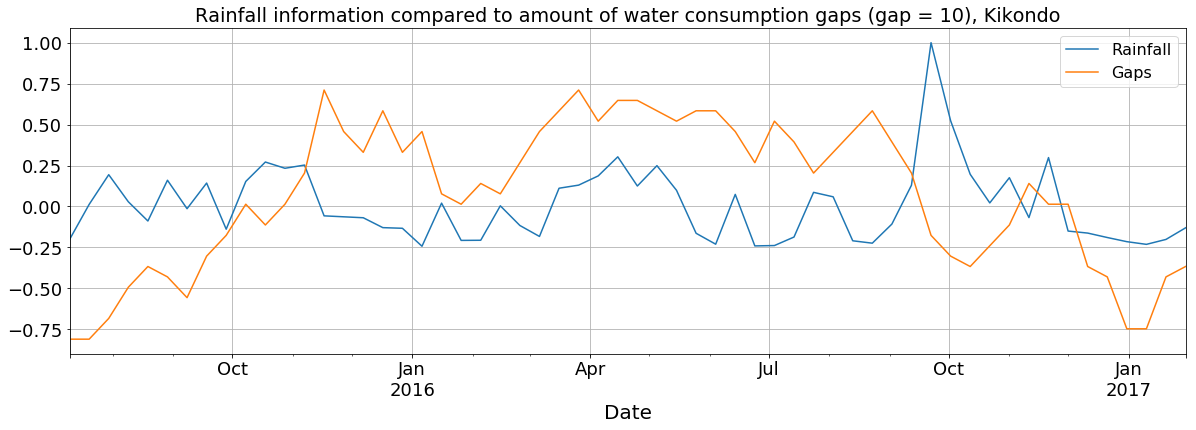

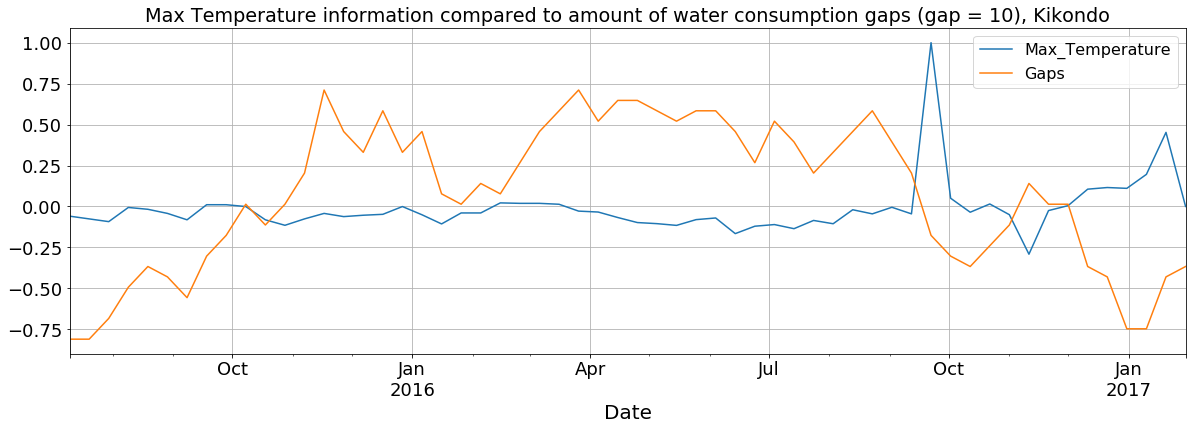

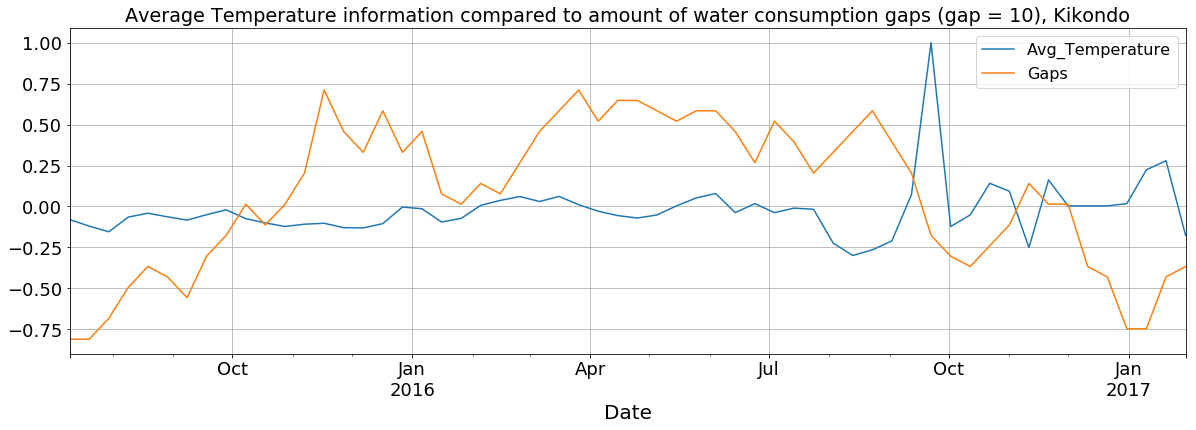

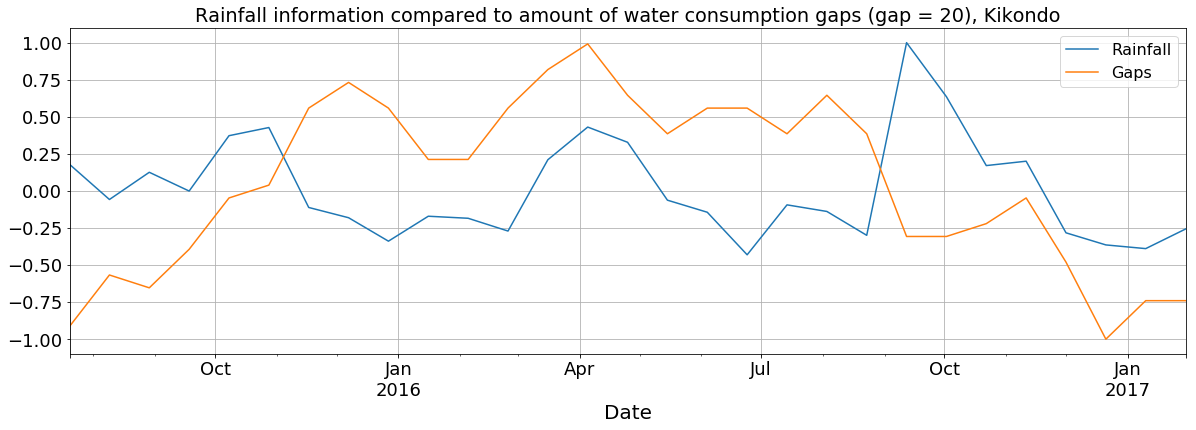

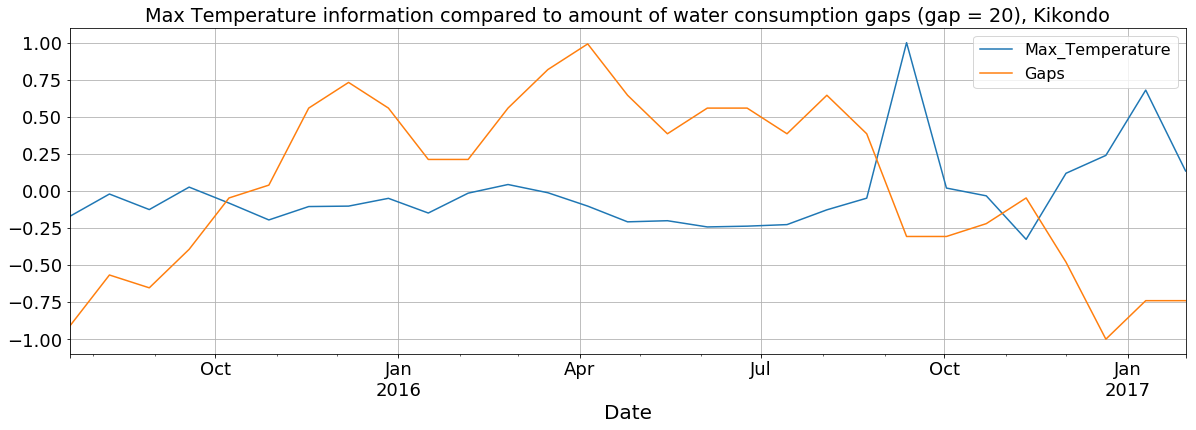

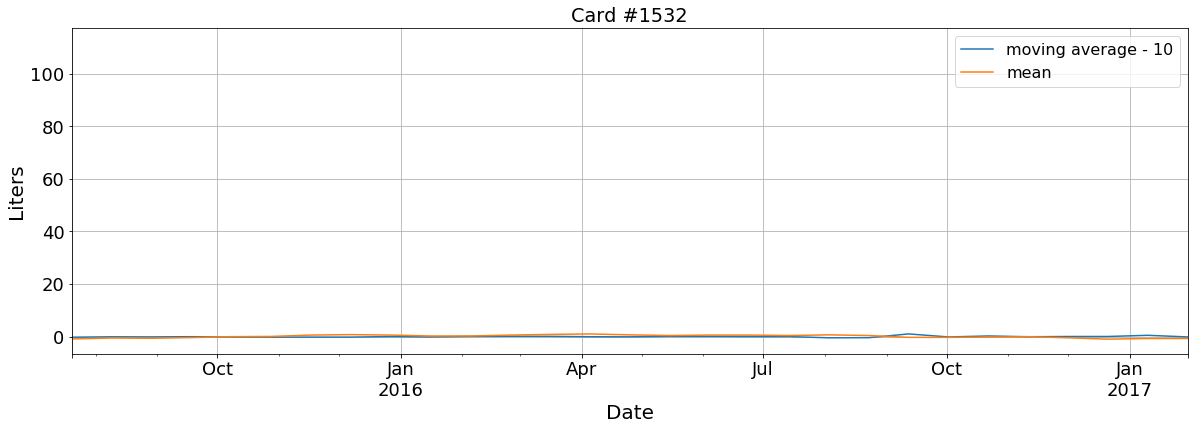

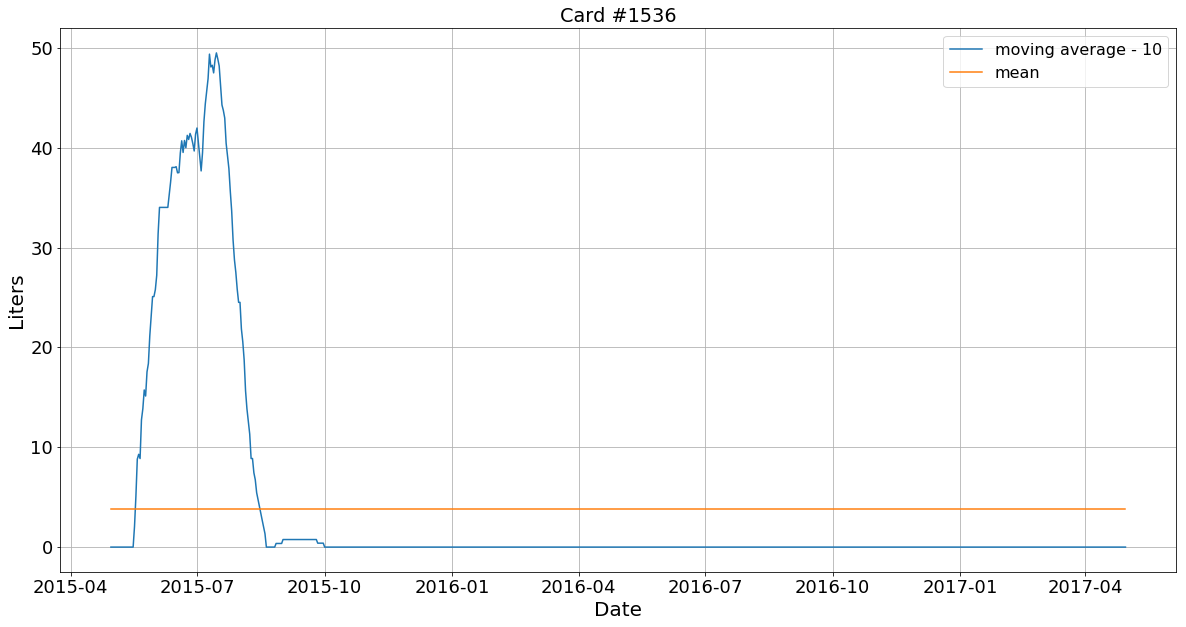

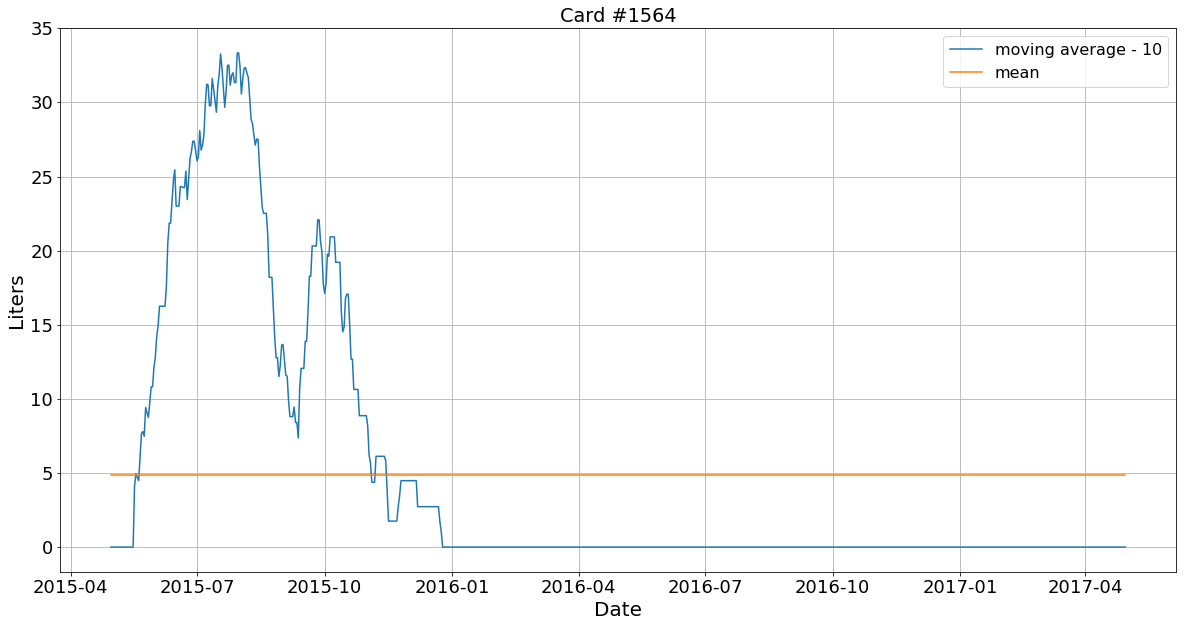

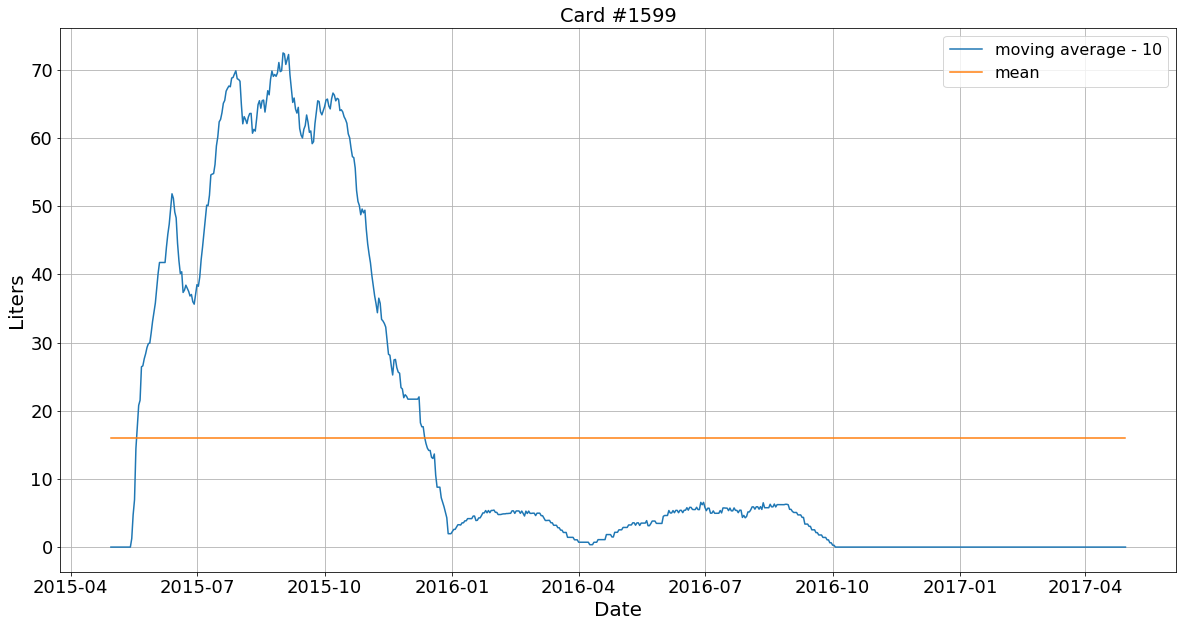

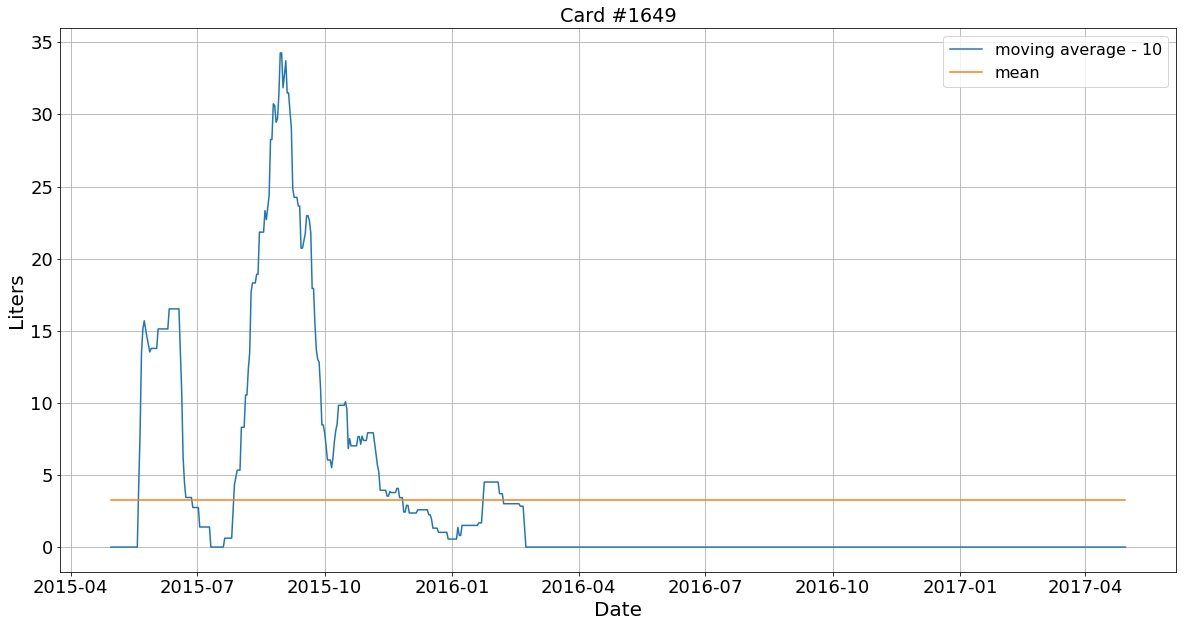

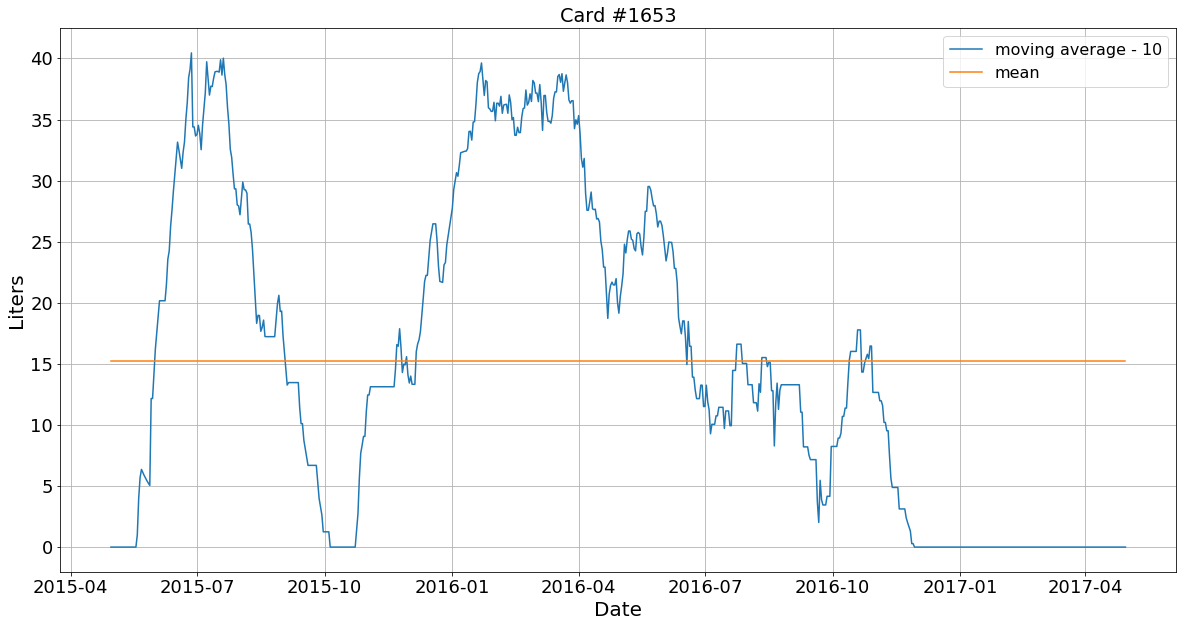

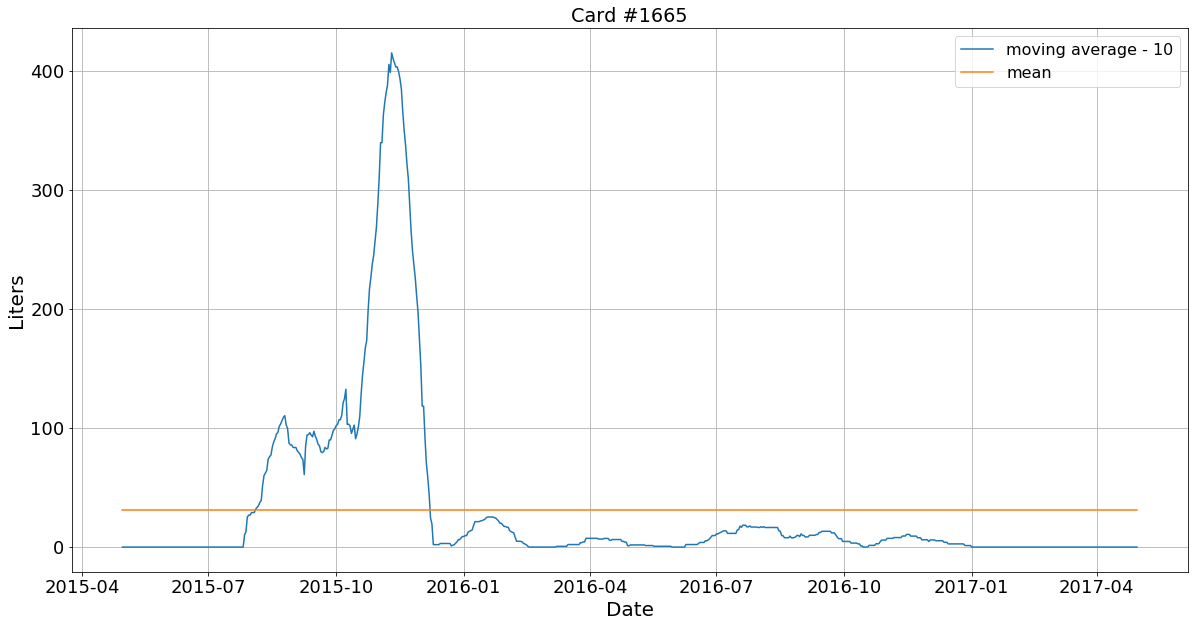

coef= 30
          Rainfall      Gaps
Rainfall  1.000000 -0.032068
Gaps     -0.032068  1.000000
       Period  Rainfall      Gaps
21 2016-09-22  1.000000 -0.452055
22 2016-10-22  0.070083 -0.452055
23 2016-11-21 -0.013932 -0.543379
24 2016-12-21 -0.377406 -0.908676
25 2017-01-20 -0.289174 -0.634703
coef= 30
                 Max_Temperature      Gaps
Max_Temperature         1.000000 -0.616988
Gaps                   -0.616988  1.000000
       Period  Max_Temperature      Gaps
21 2016-09-22         1.000000 -0.452055
22 2016-10-22        -0.318880 -0.452055
23 2016-11-21         0.086169 -0.543379
24 2016-12-21         0.417124 -0.908676
25 2017-01-20         0.570252 -0.634703
coef= 30
                 Avg_Temperature      Gaps
Avg_Temperature         1.000000 -0.555967
Gaps                   -0.555967  1.000000
       Period  Avg_Temperature      Gaps
21 2016-09-22         1.000000 -0.452055
22 2016-10-22        -0.004801 -0.452055
23 2016-11-21         0.216967 -0.543379
24 2016-12-21 

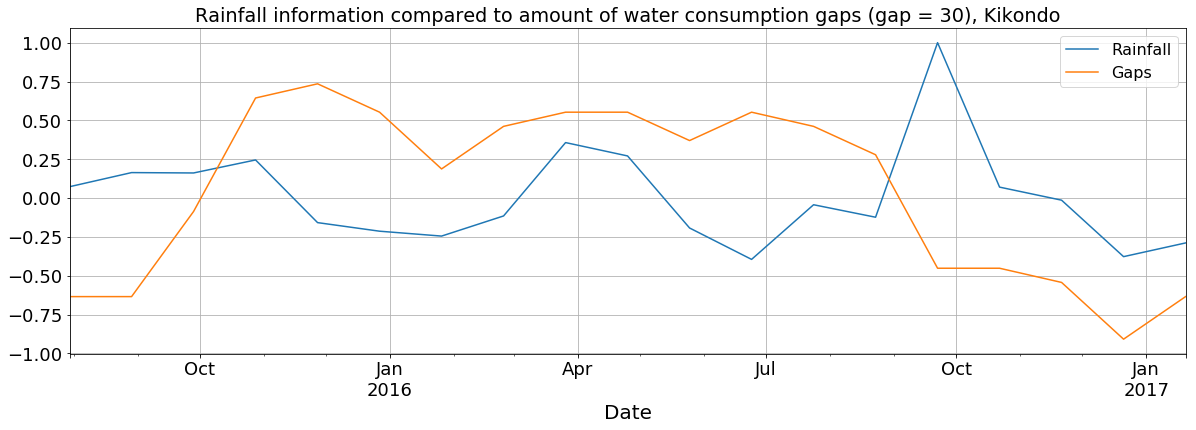

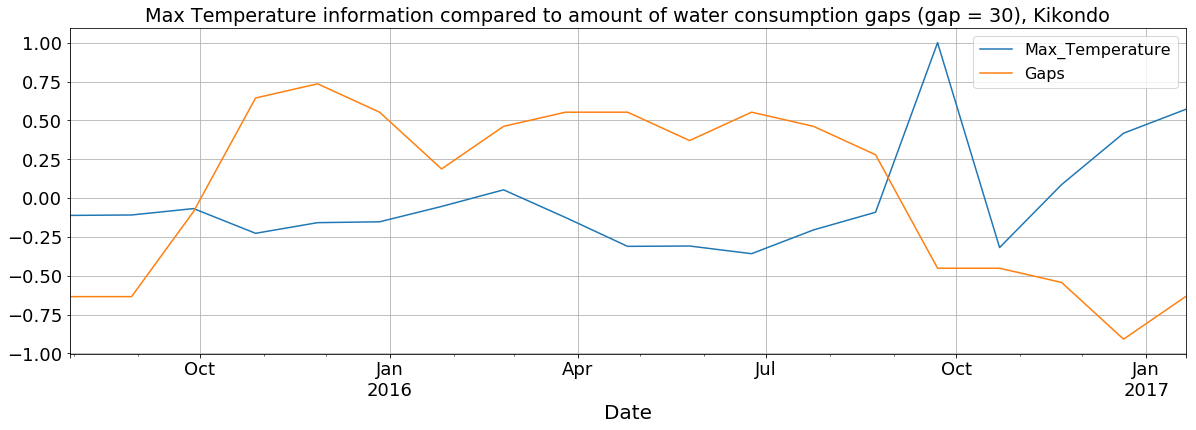

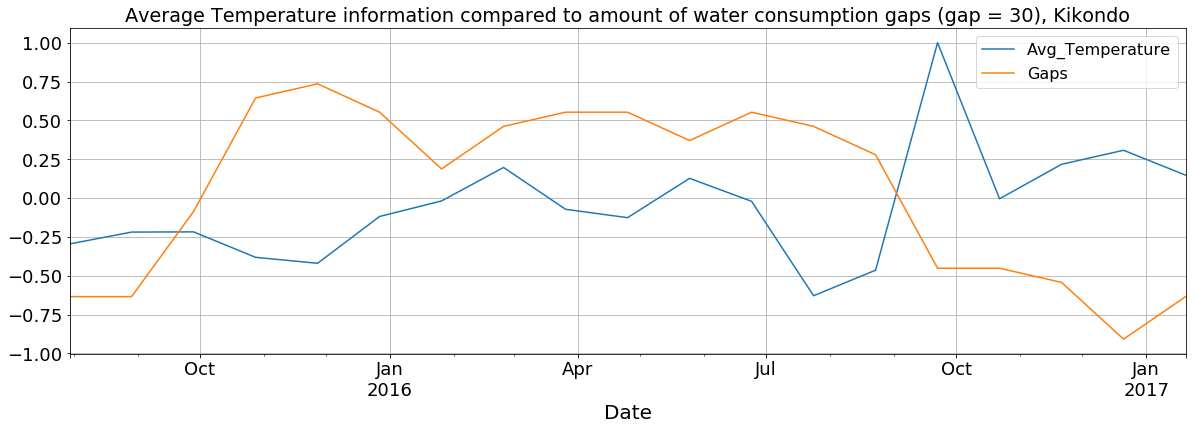

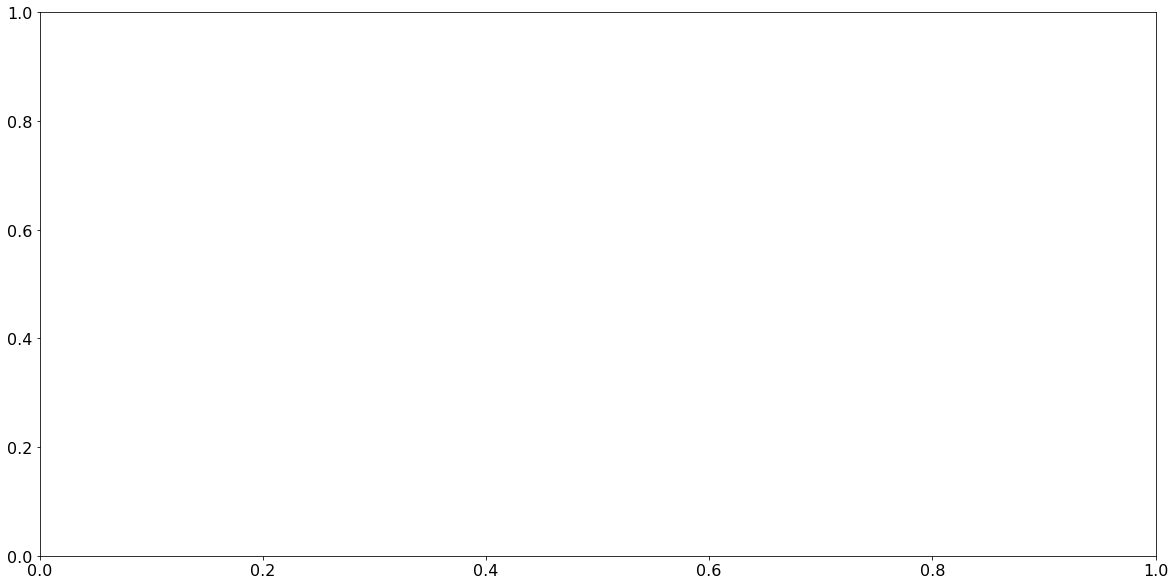

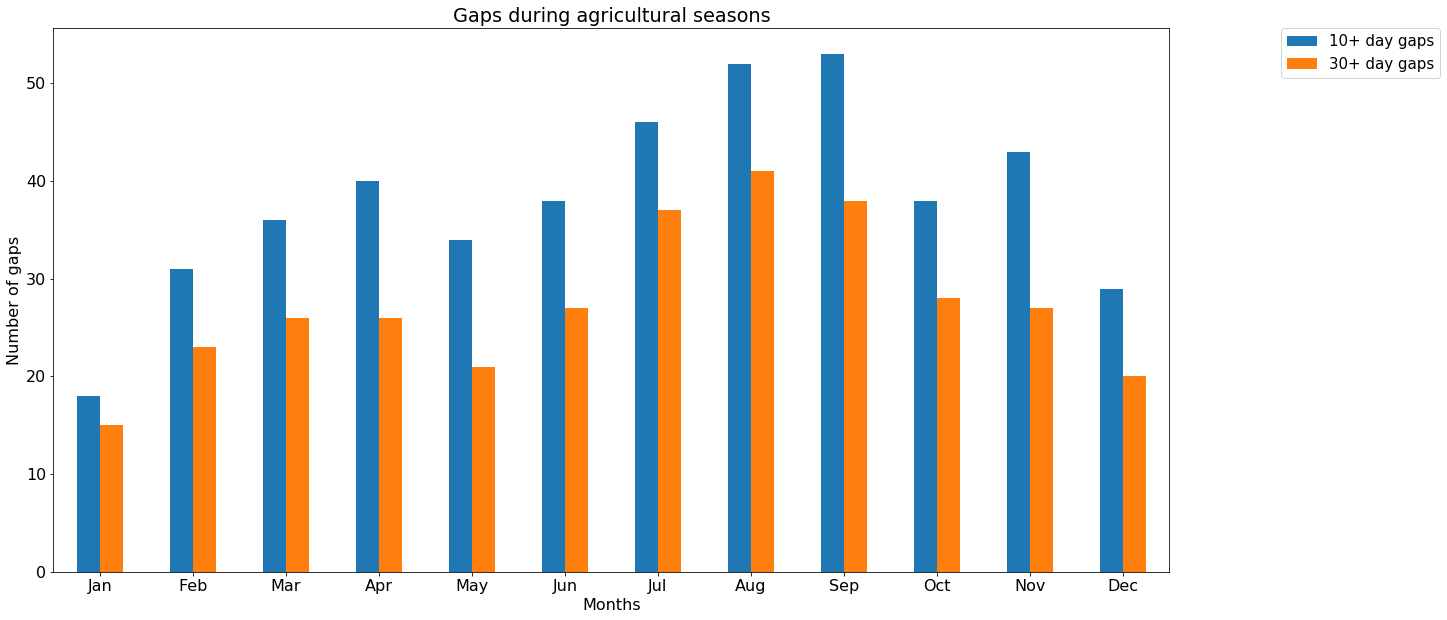

In [25]:
dfTupleKikondo = loadAndProcess(districtPropsKikondo, analysisProps)

In [26]:
dfTupleKikondo[1]

10+ day gaps  30+ day gaps
Season                            
1                 18            15
2                 31            23
3                 36            26
4                 40            26
5                 34            21
6                 38            27
7                 46            37
8                 52            41
9                 53            38
10                38            28
11                43            27
12                29            20

<a id="section7"></a>
# Correlation & Trends Analysis, Busiro

Gap duration =  10
cardsWithGaps =  132
cardsWithOneGap =  146
cardsWithoutGaps =  95
gapsSummary =  278
------------------------------------------------------------------------
Gap duration =  20
cardsWithGaps =  80
cardsWithOneGap =  111
cardsWithoutGaps =  182
gapsSummary =  191
------------------------------------------------------------------------
Gap duration =  30
cardsWithGaps =  49
cardsWithOneGap =  102
cardsWithoutGaps =  222
gapsSummary =  151
------------------------------------------------------------------------
coef= 10
          Rainfall      Gaps
Rainfall  1.000000  0.122079
Gaps      0.122079  1.000000
       Period  Rainfall      Gaps
72 2016-12-21 -0.193573 -0.024565
73 2016-12-31 -0.219066 -0.134733
74 2017-01-10 -0.235513 -0.145750
75 2017-01-20 -0.205250 -0.140241
76 2017-01-30 -0.134281 -0.129224
coef= 10
                 Max_Temperature     Gaps
Max_Temperature          1.00000 -0.19483
Gaps                    -0.19483  1.00000
       Period  Max_Temperature 

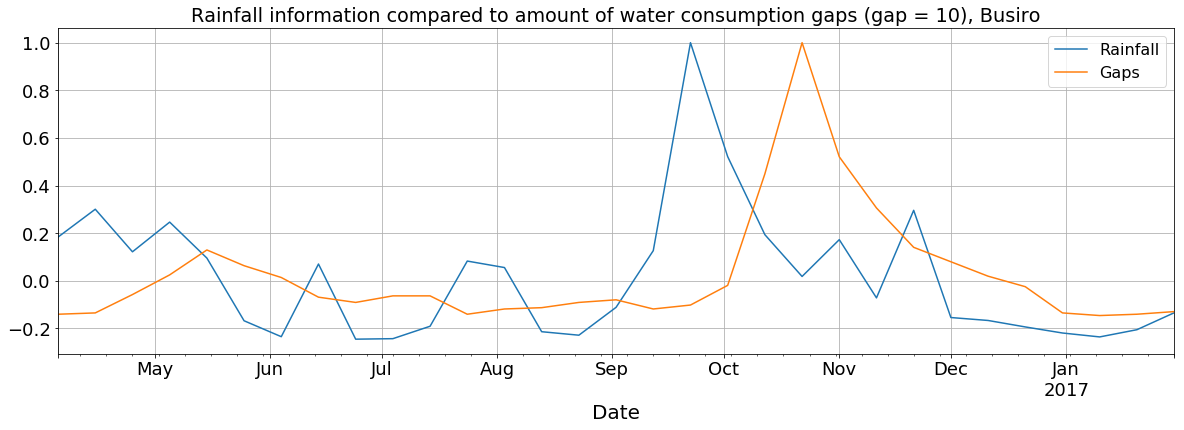

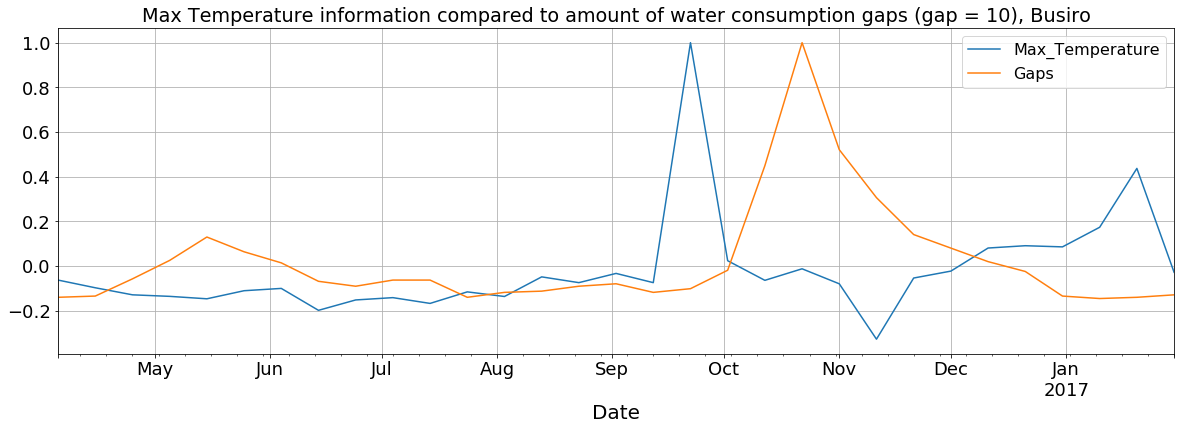

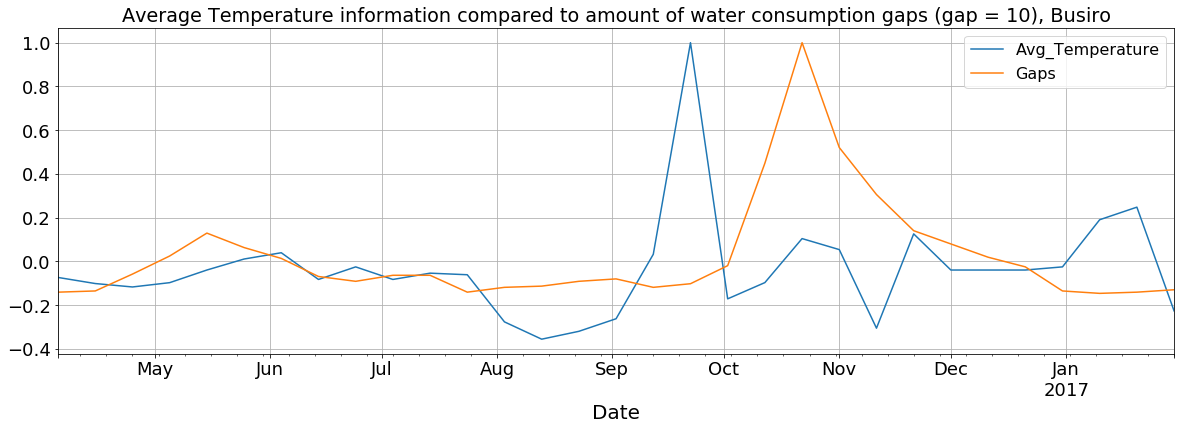

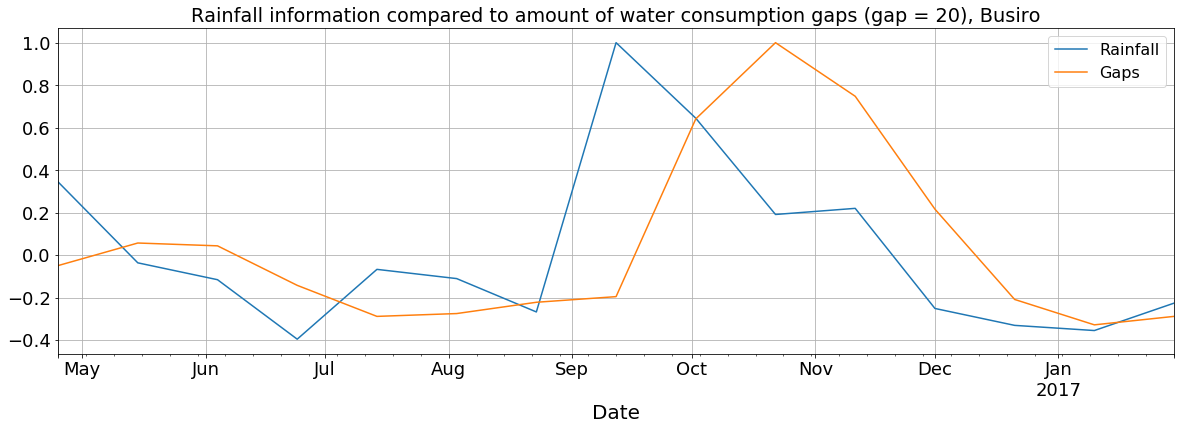

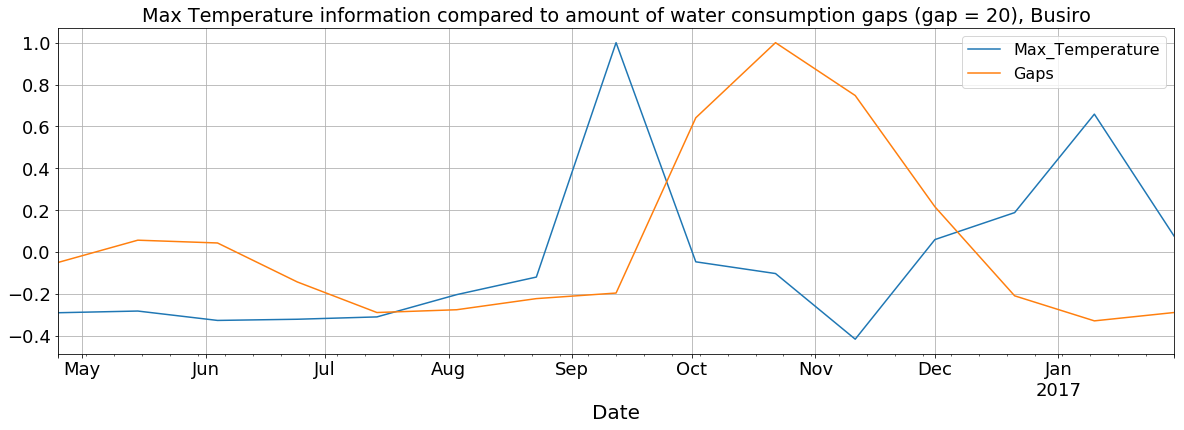

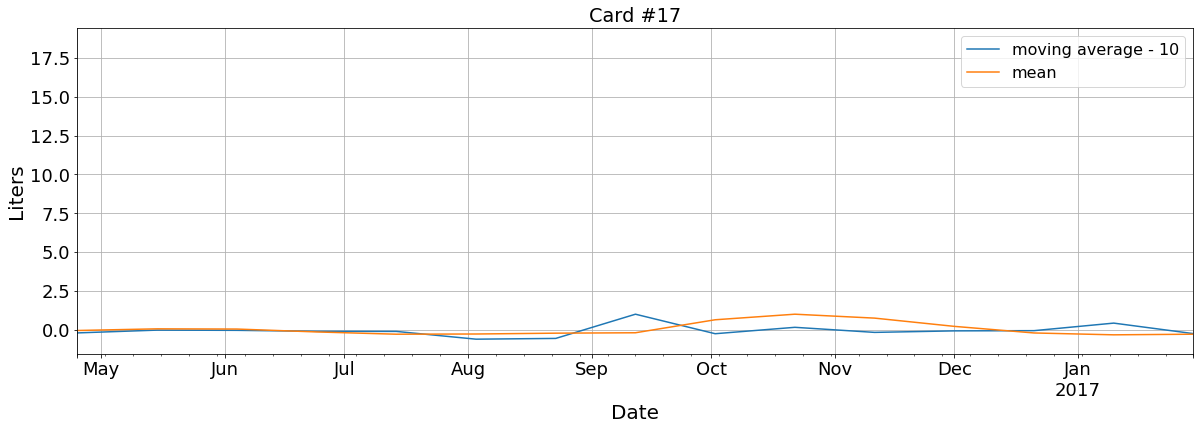

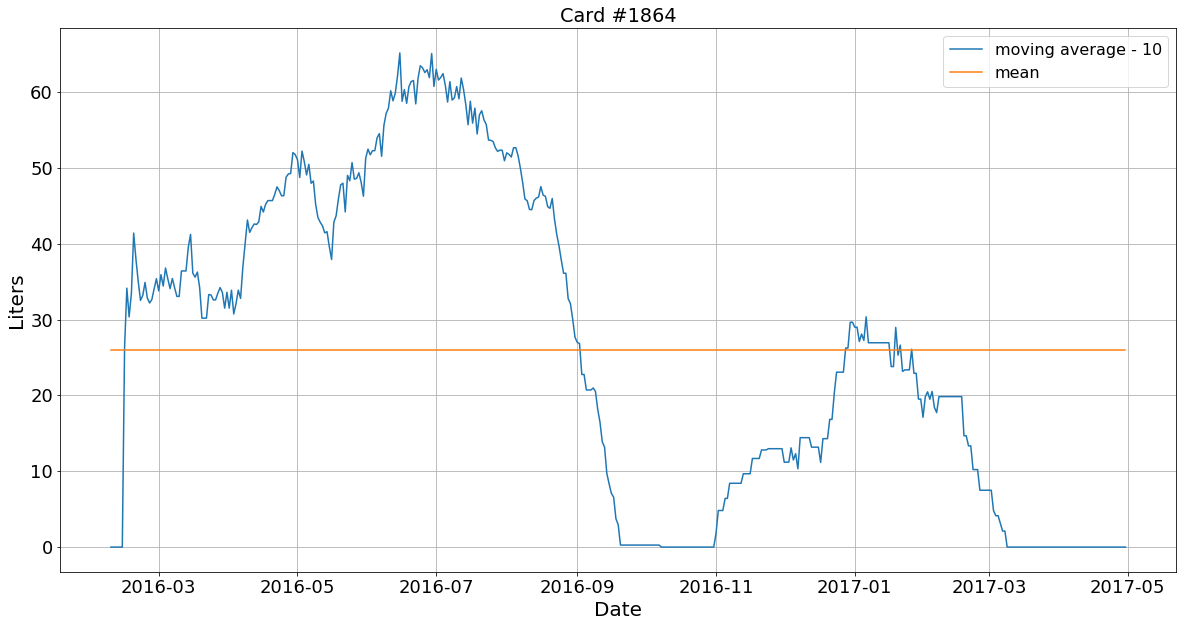

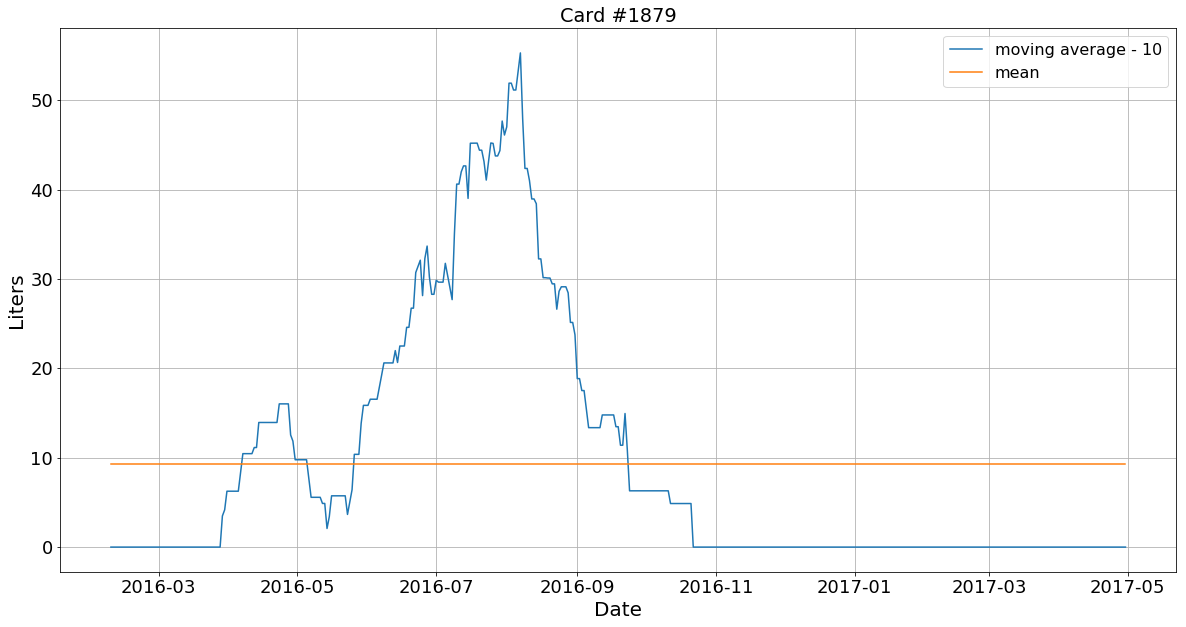

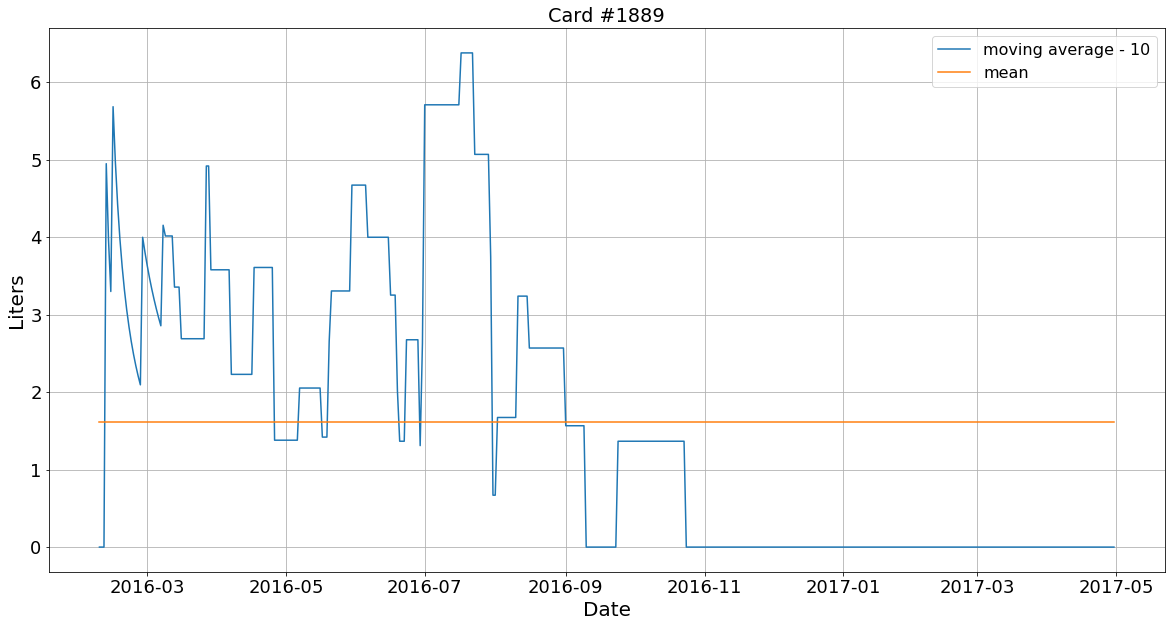

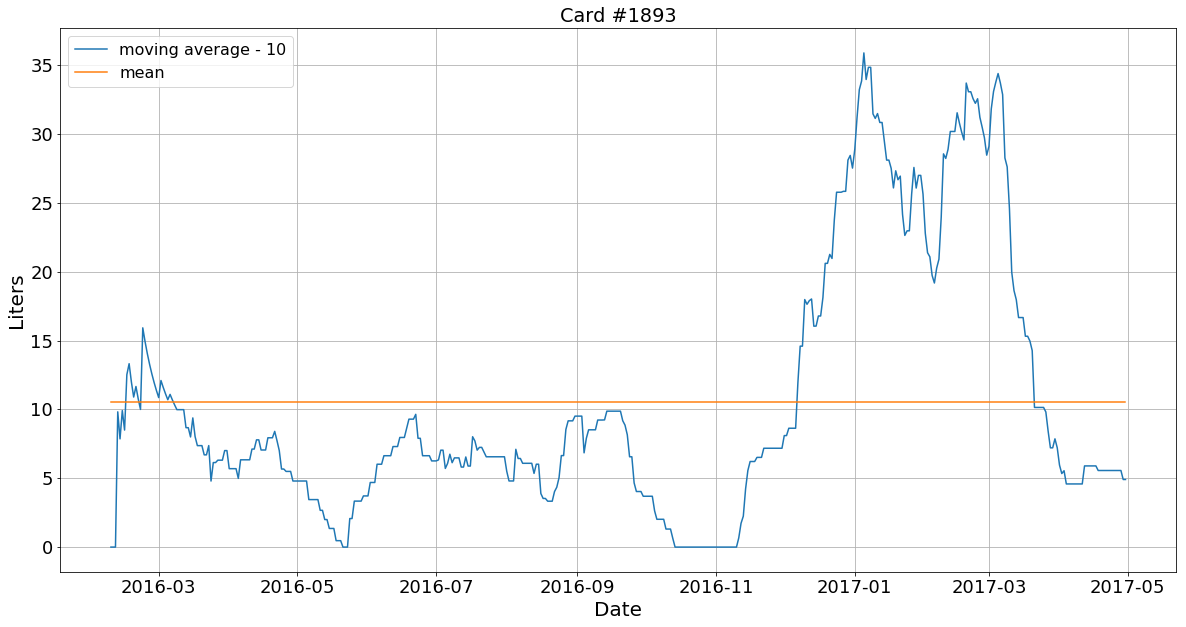

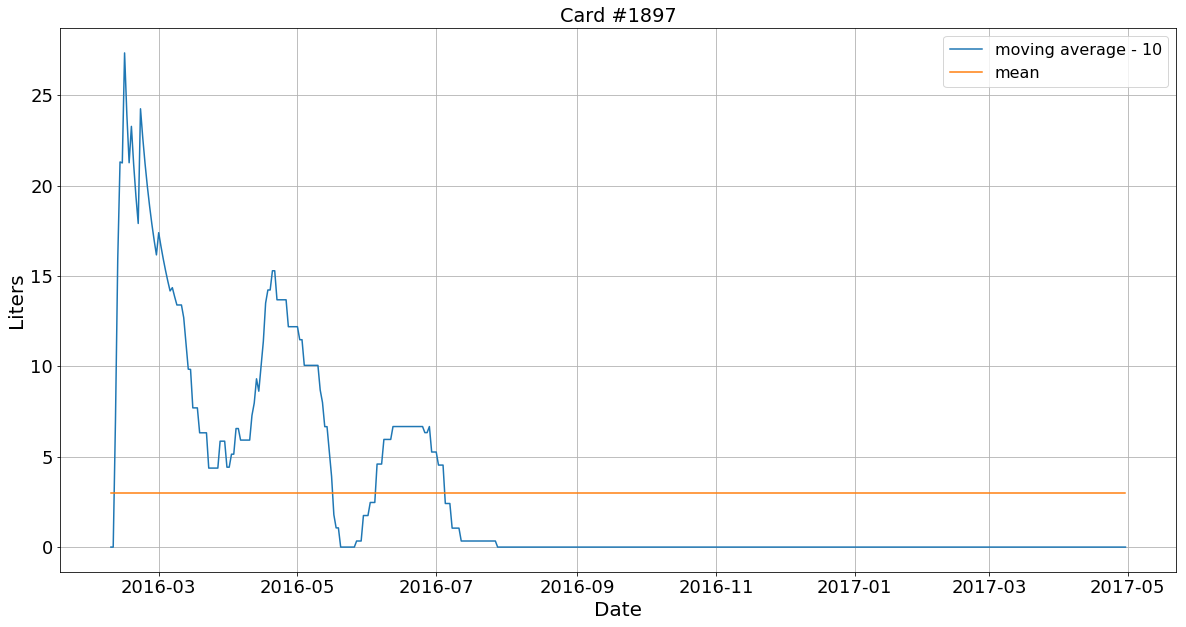

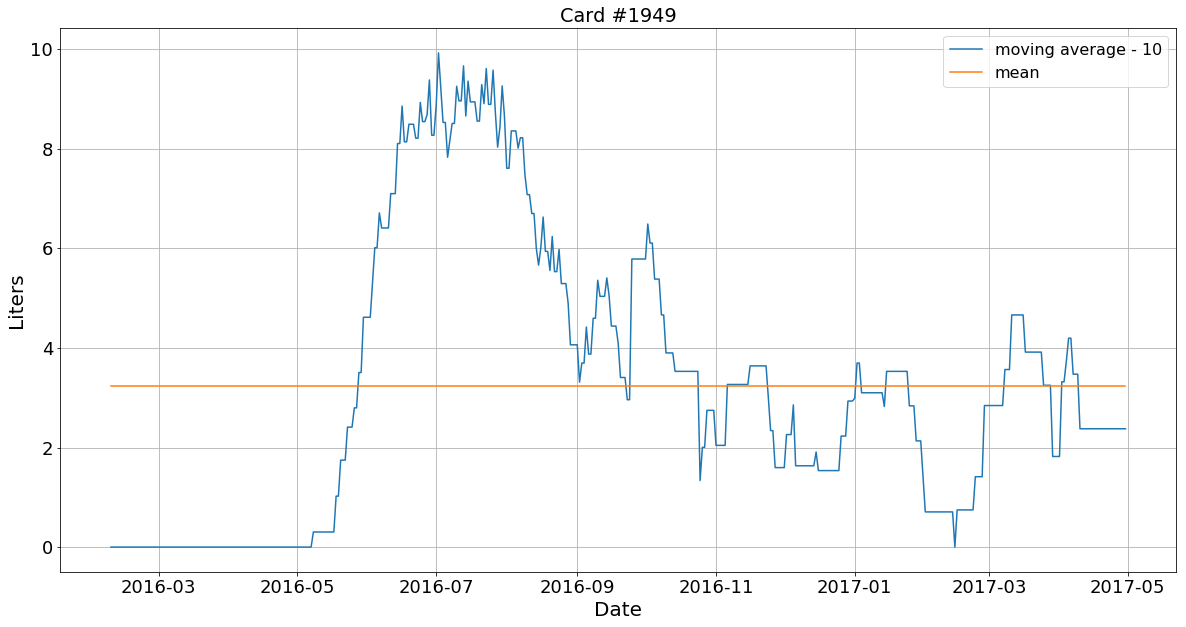

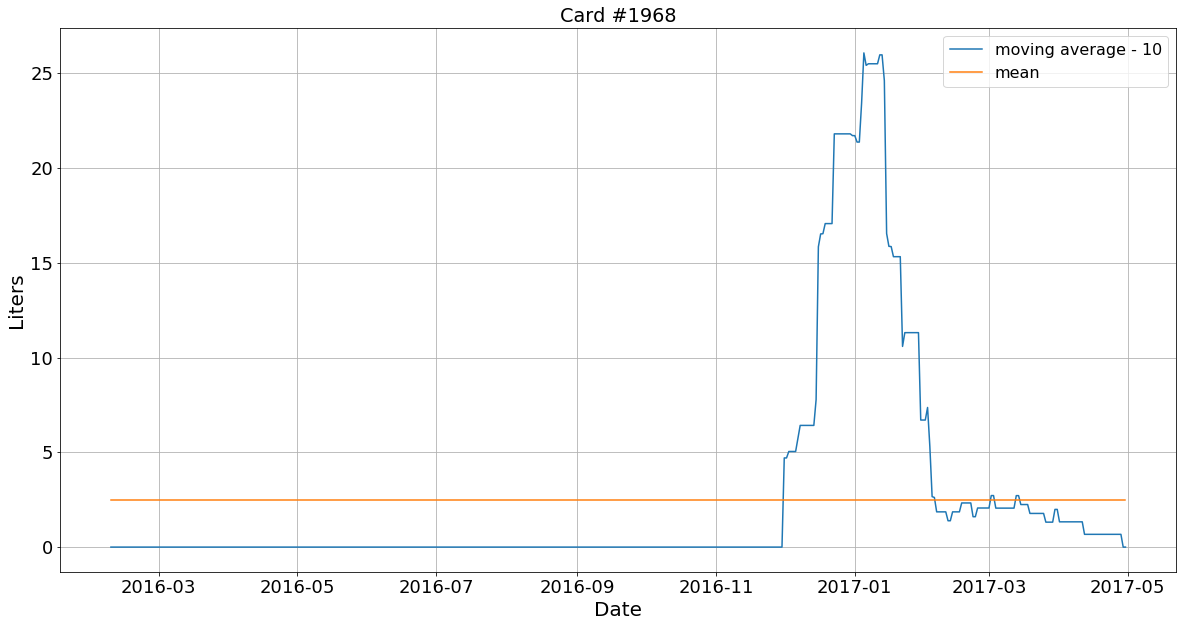

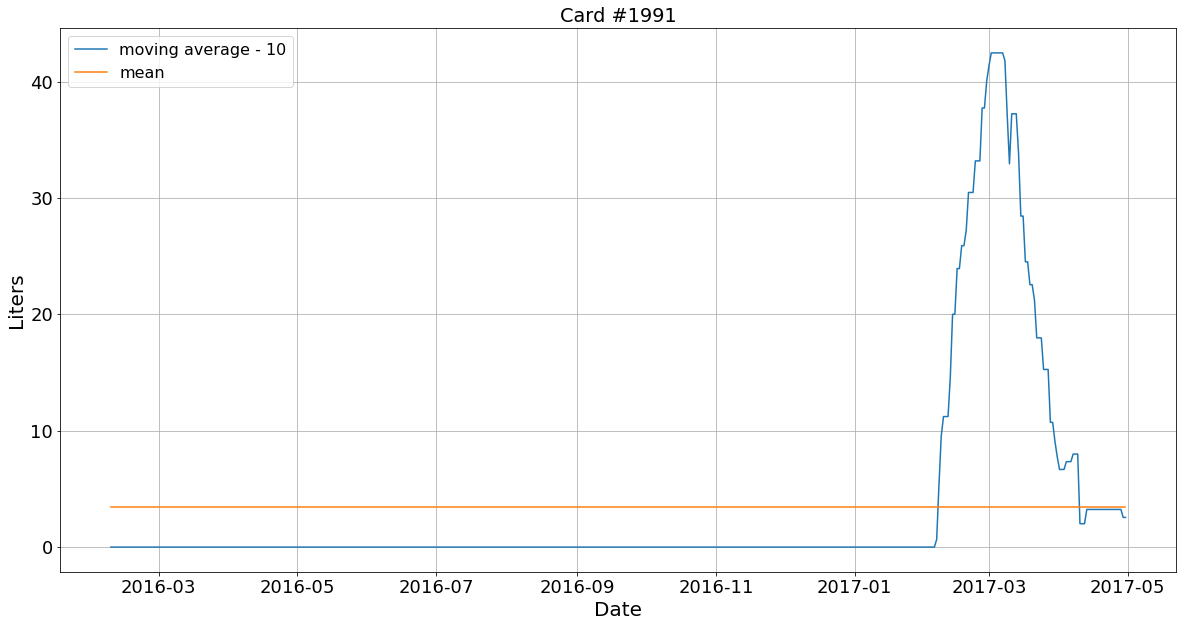

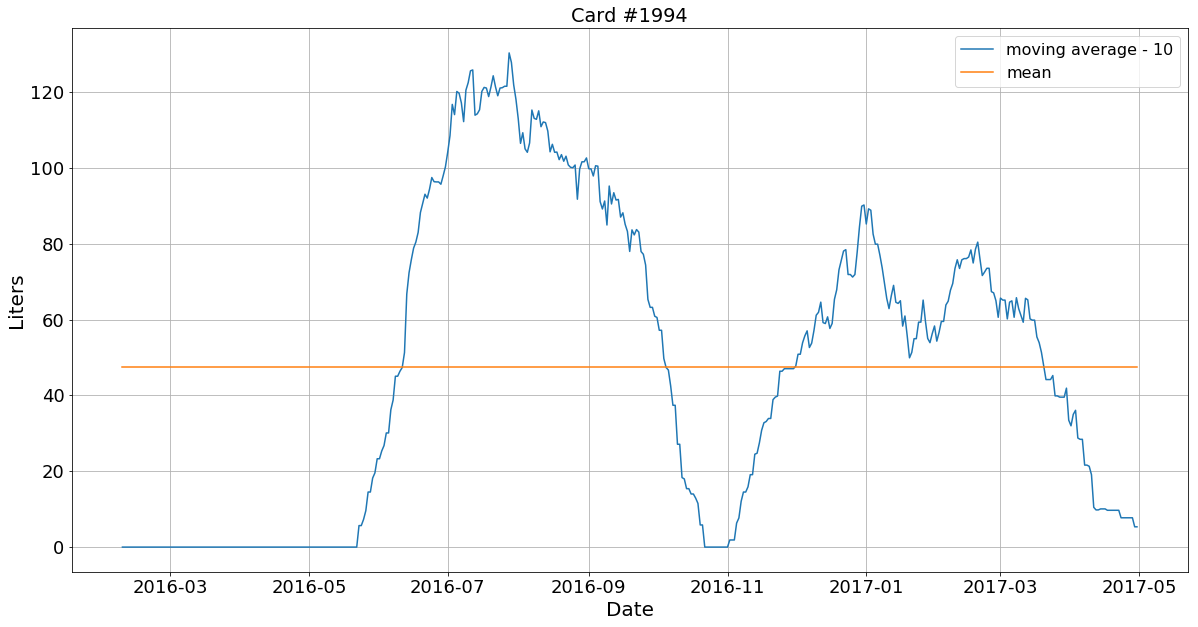

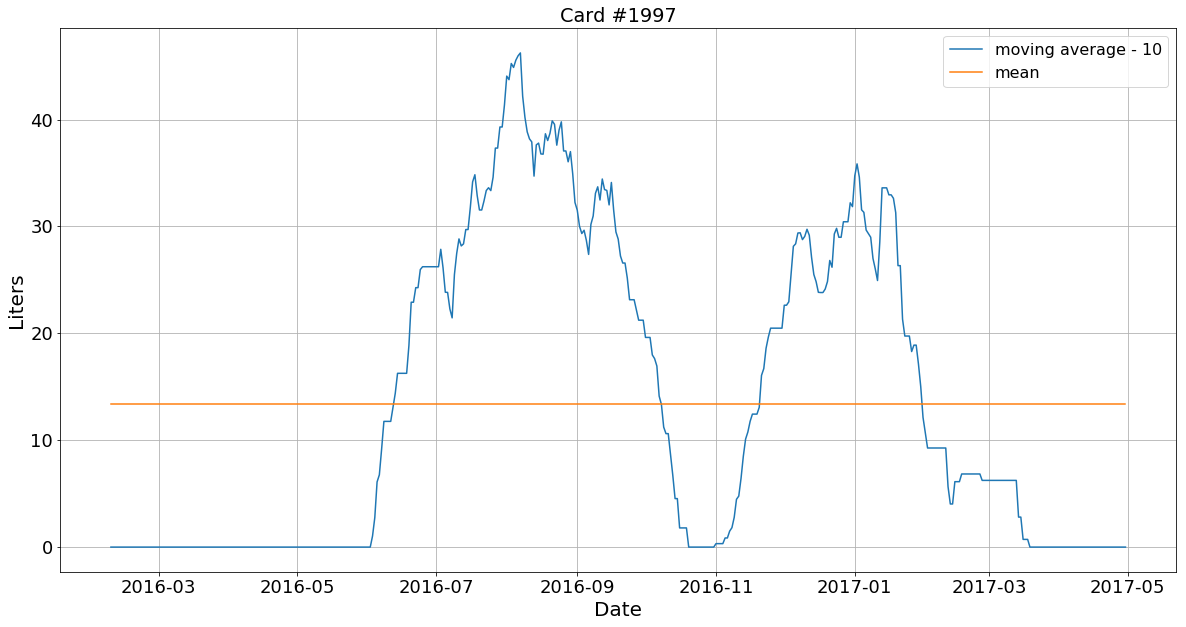

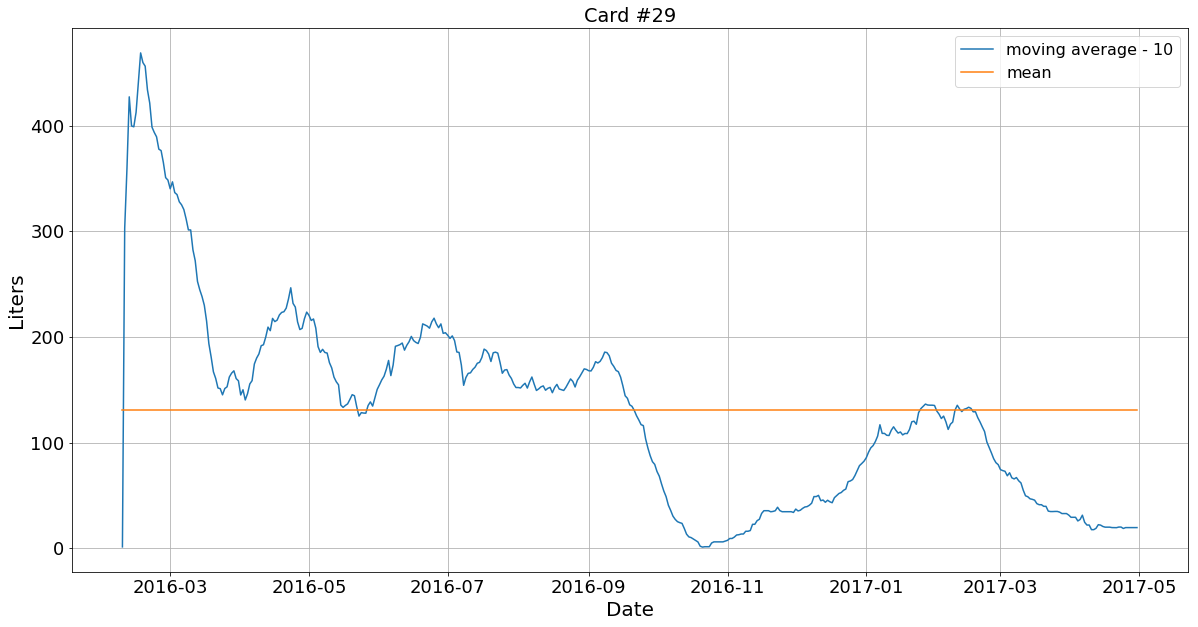

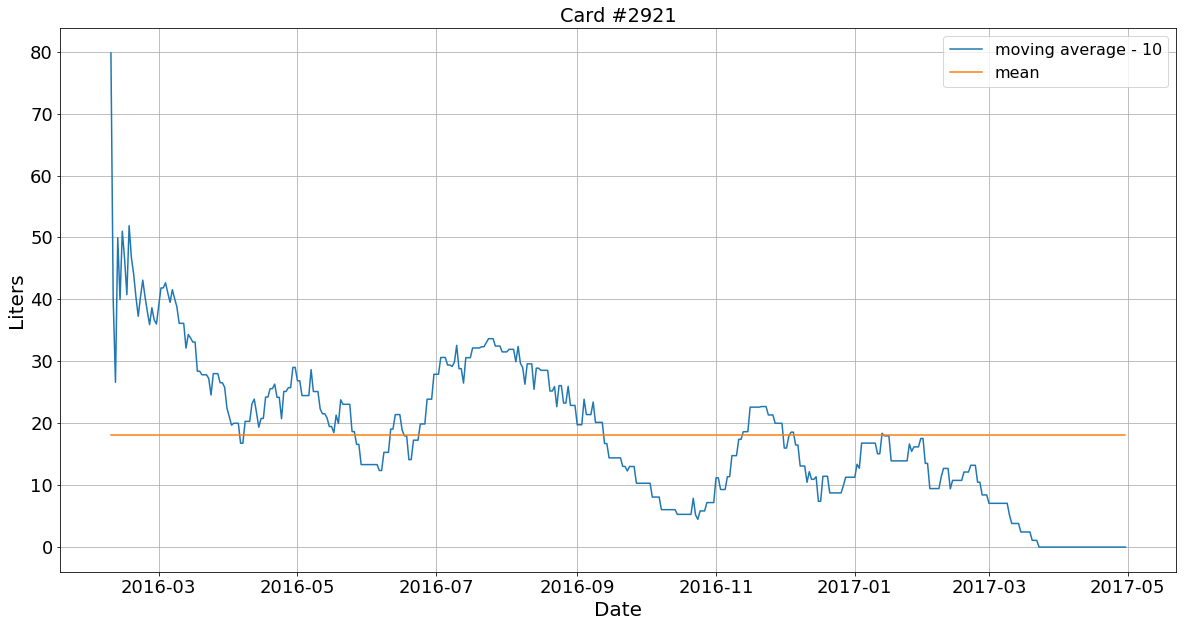

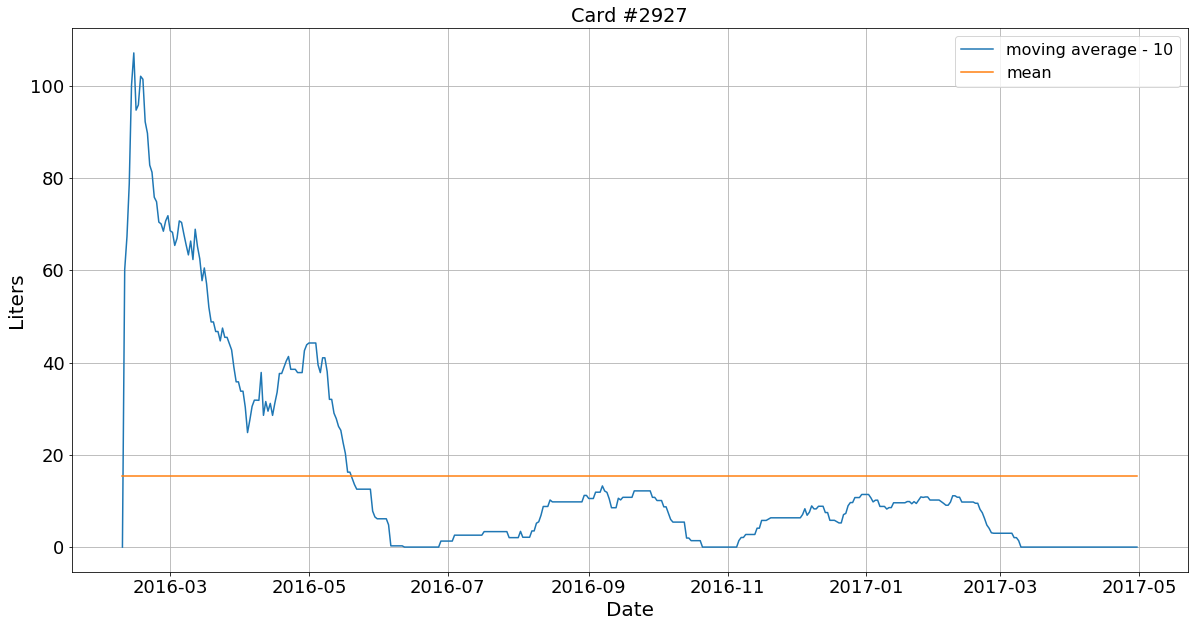

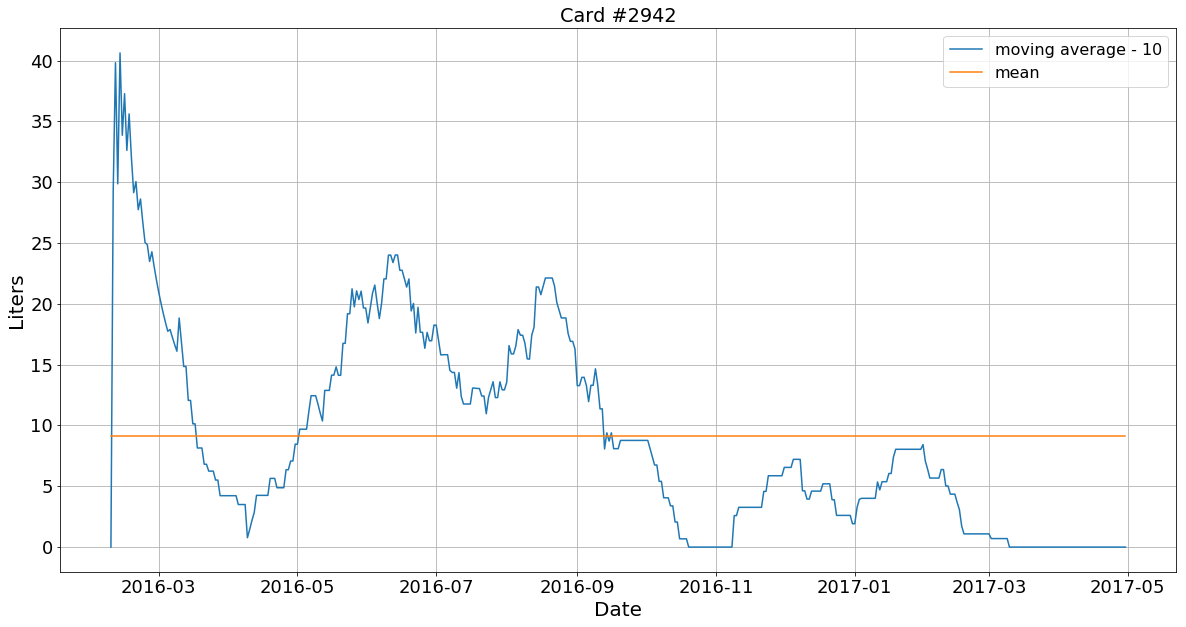

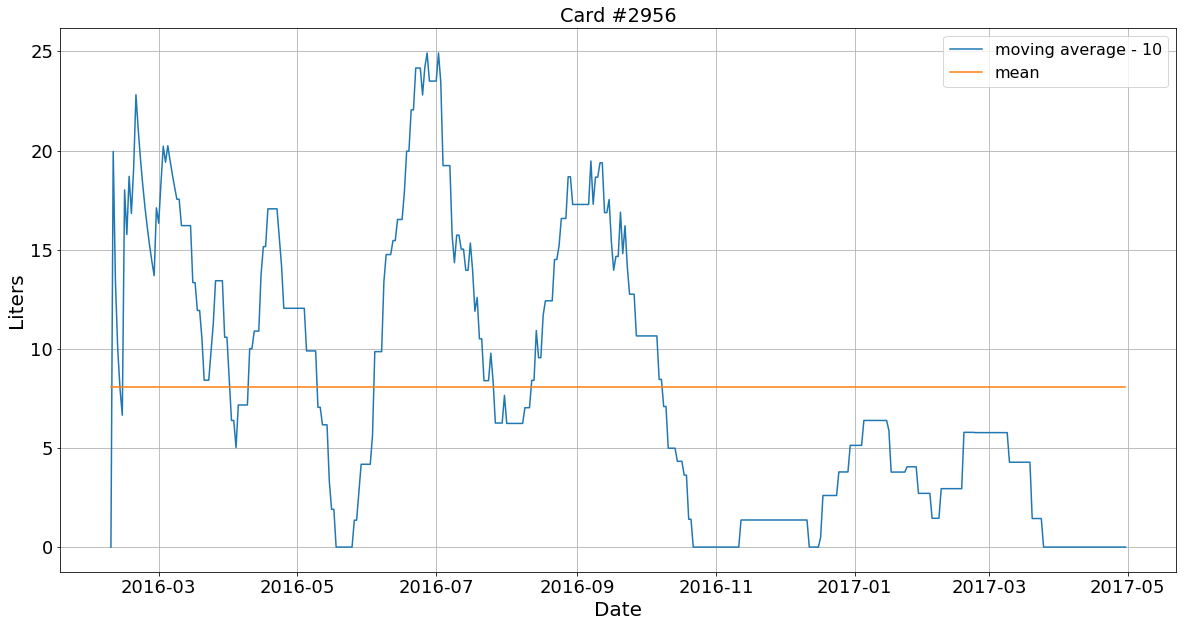

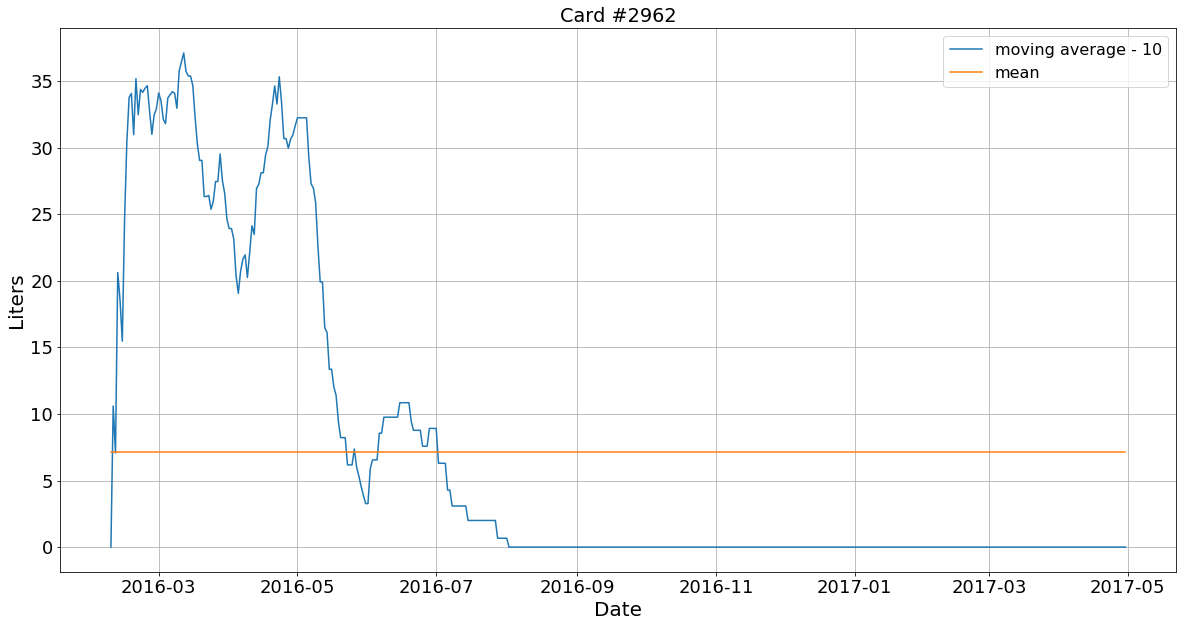

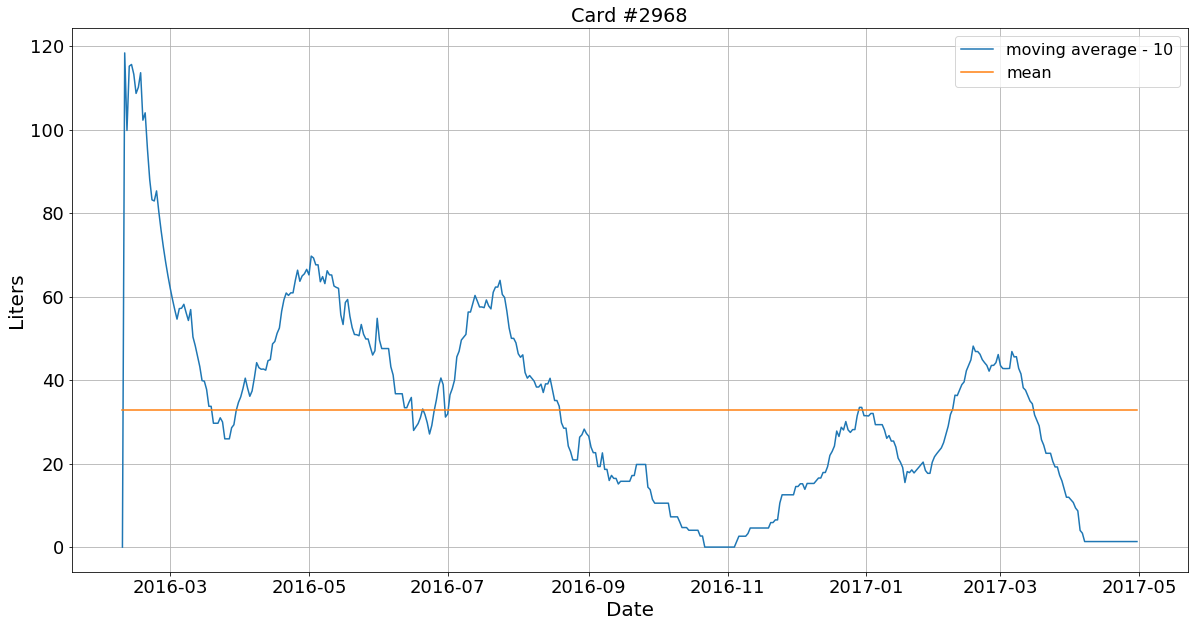

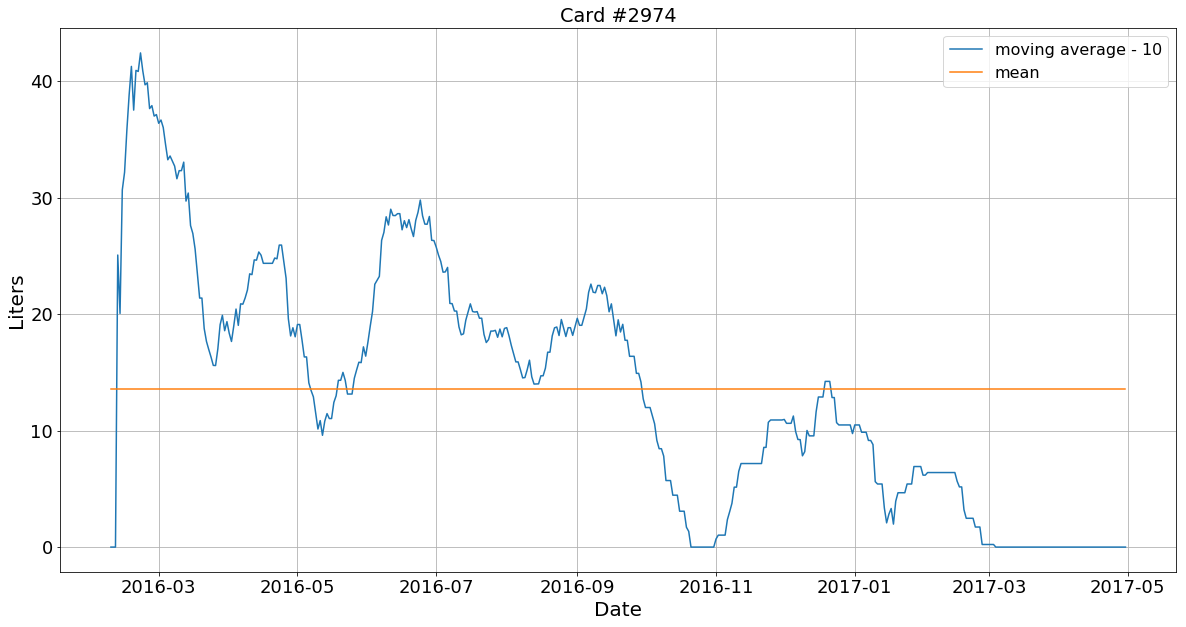

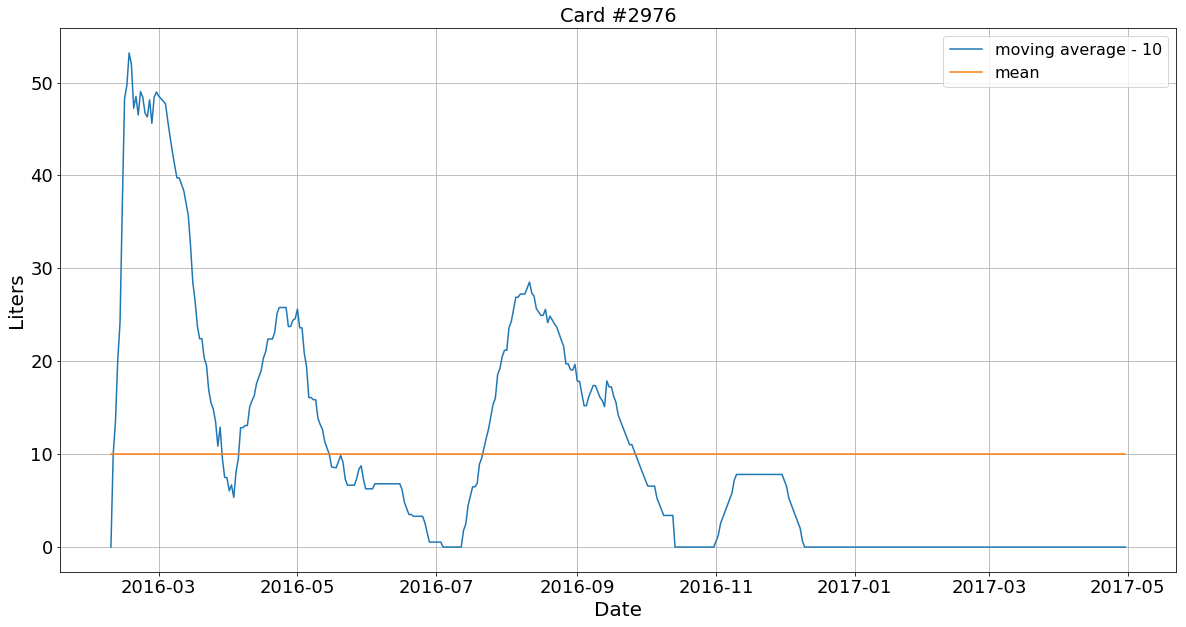

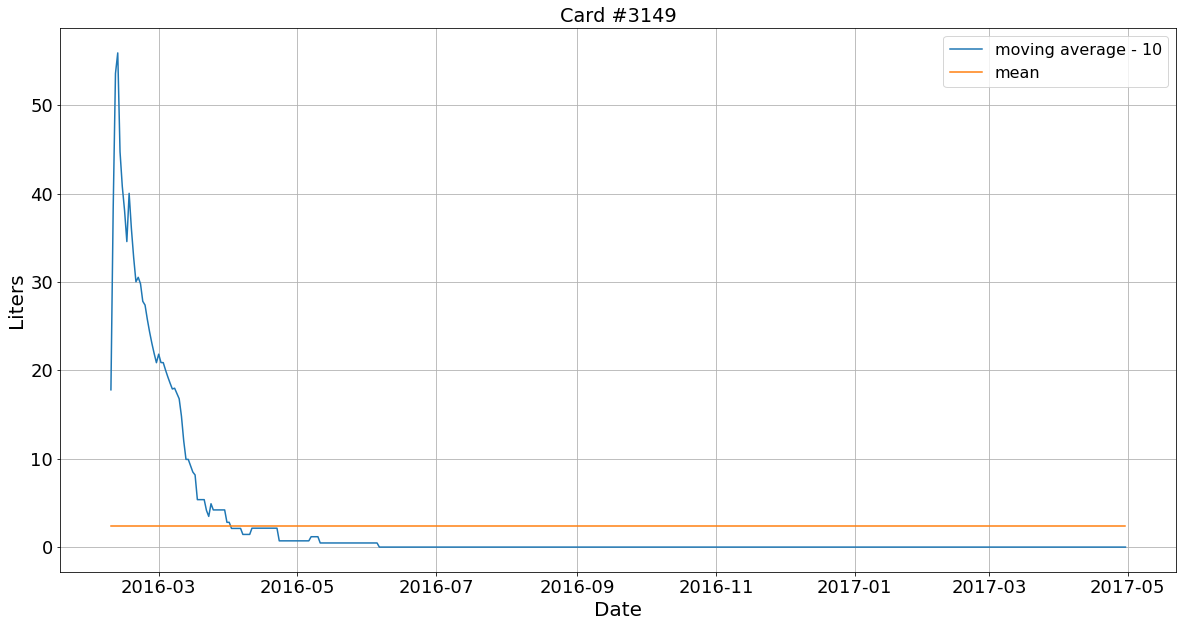

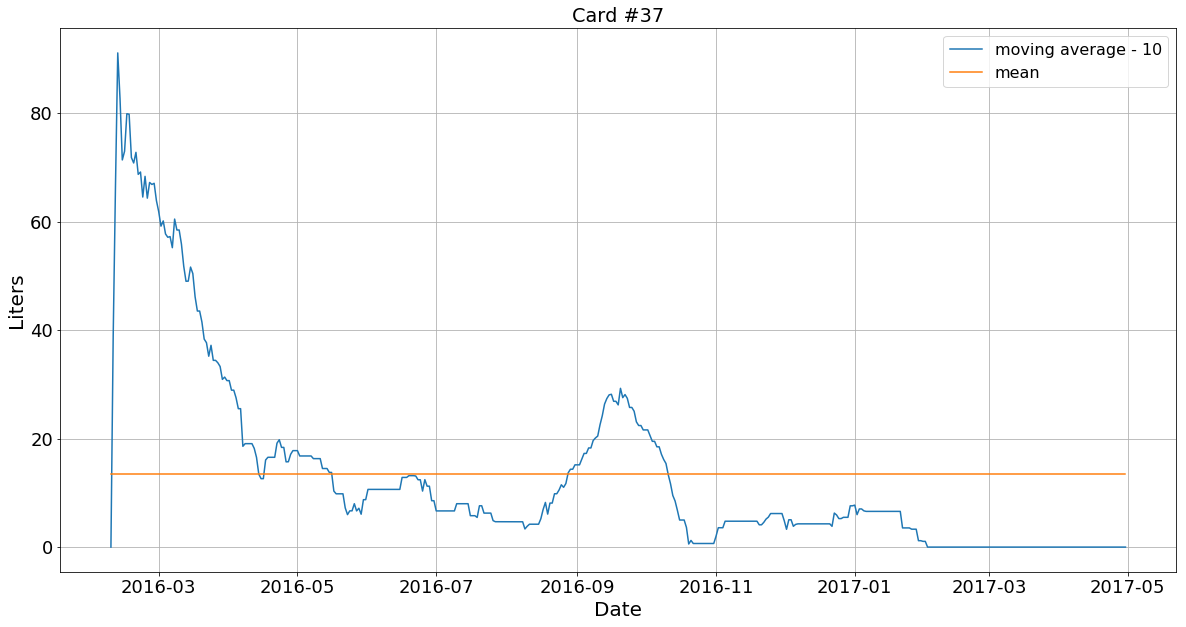

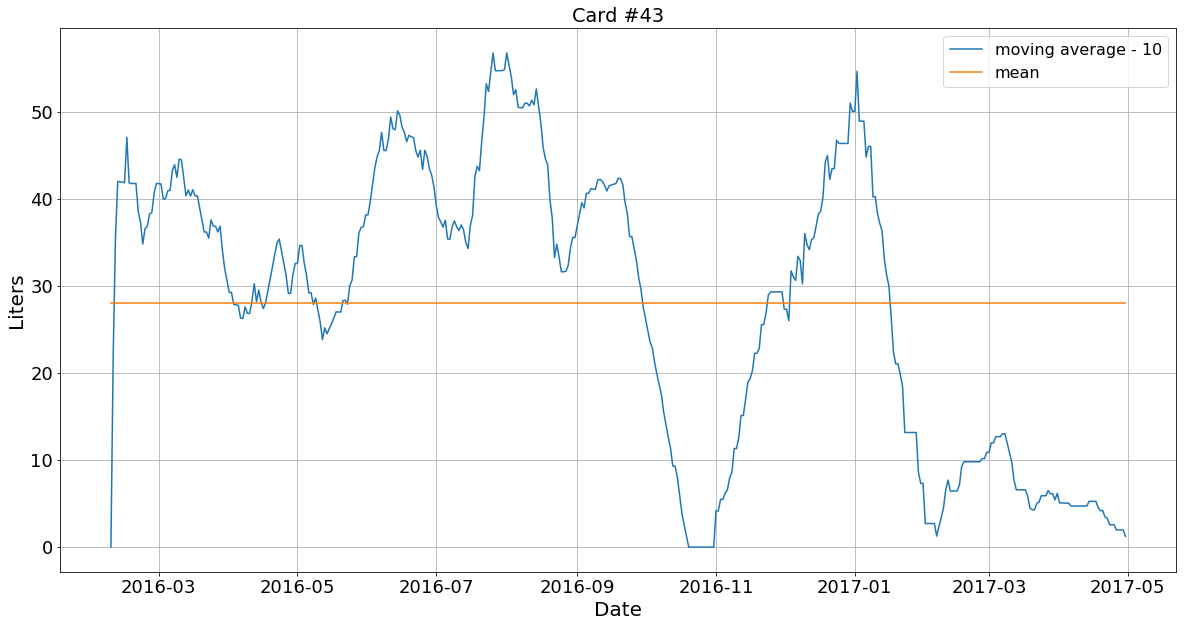

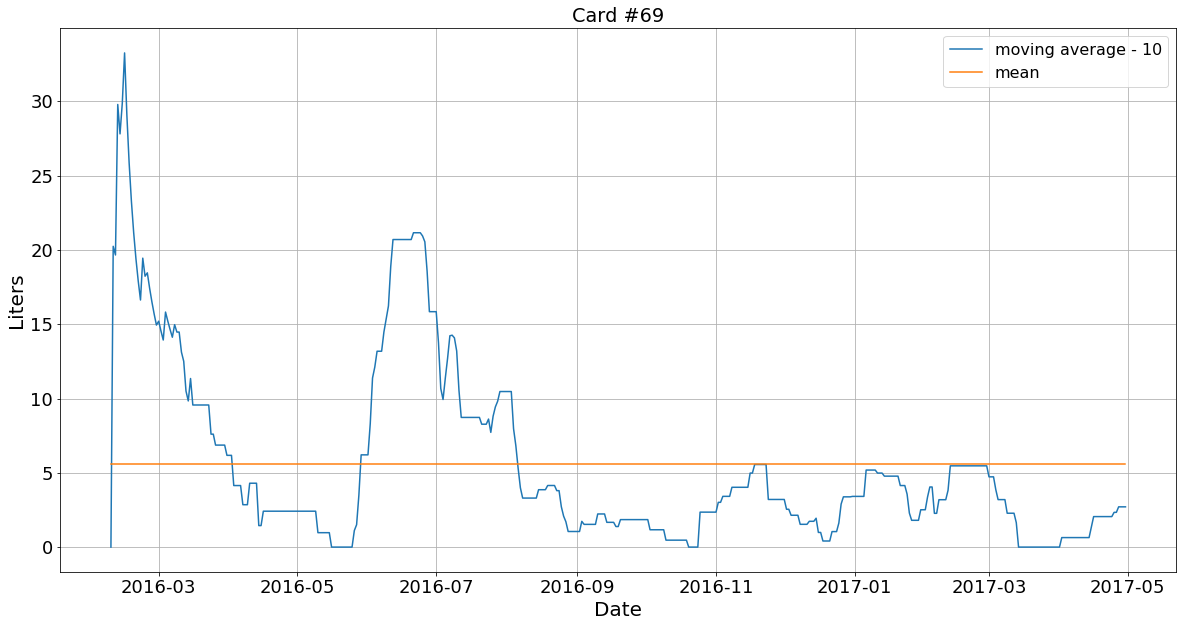

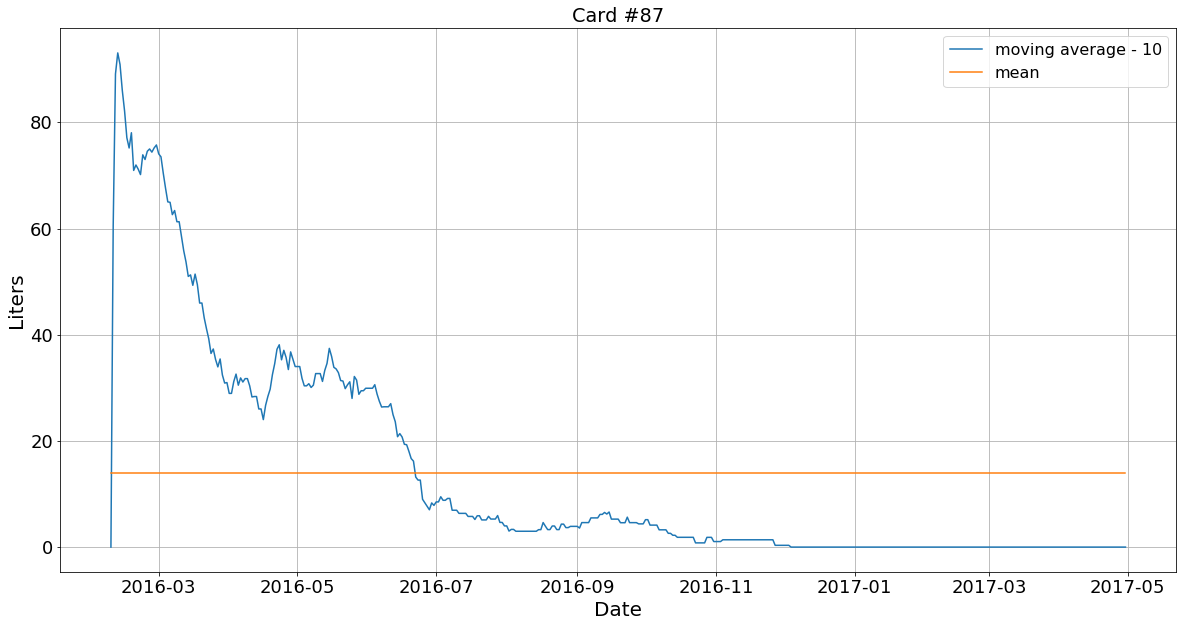

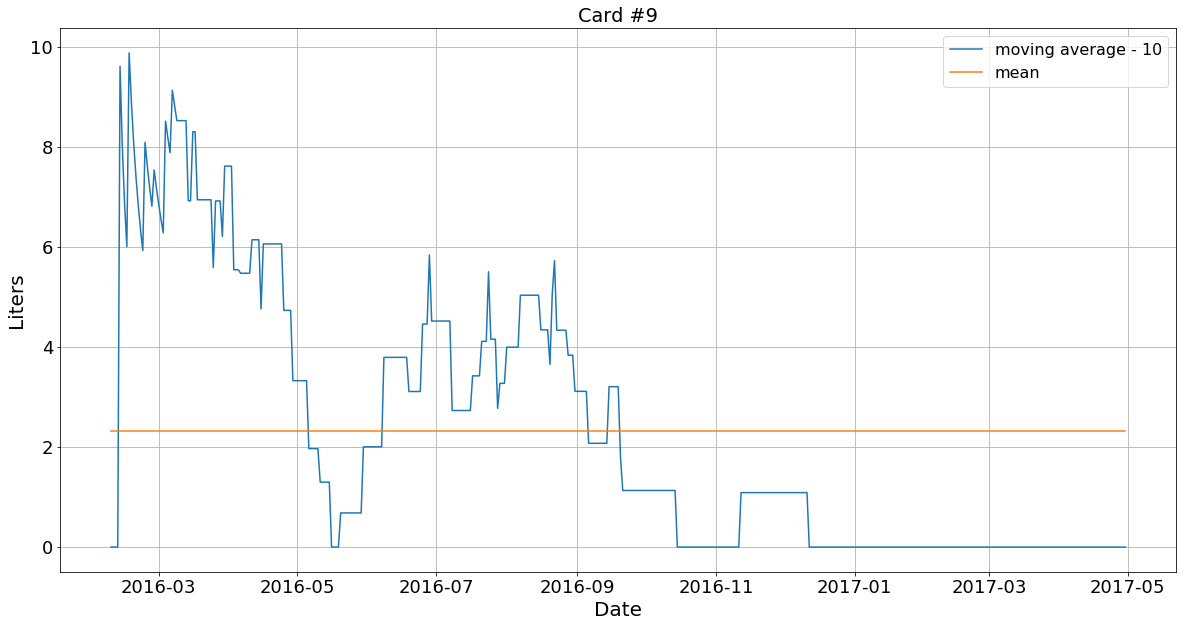

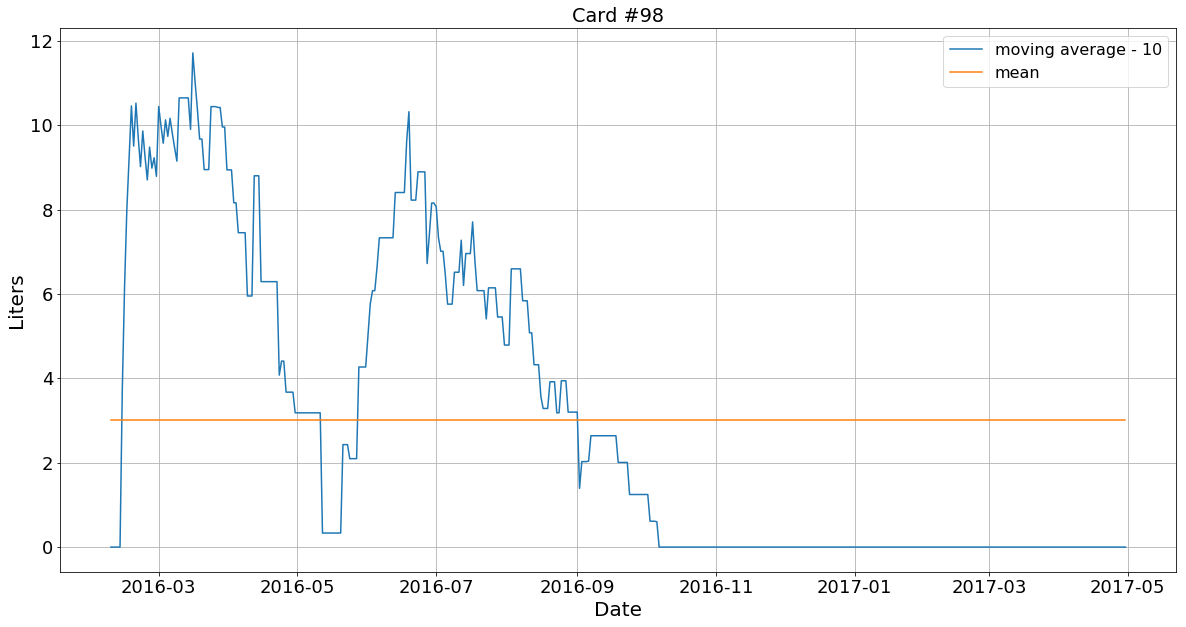

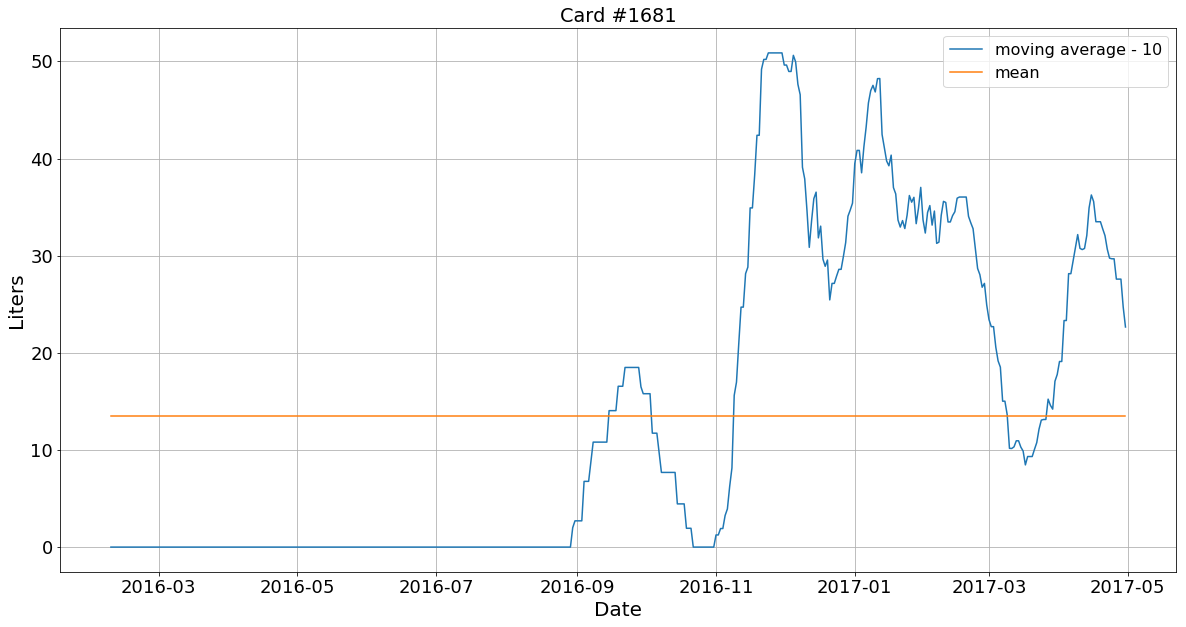

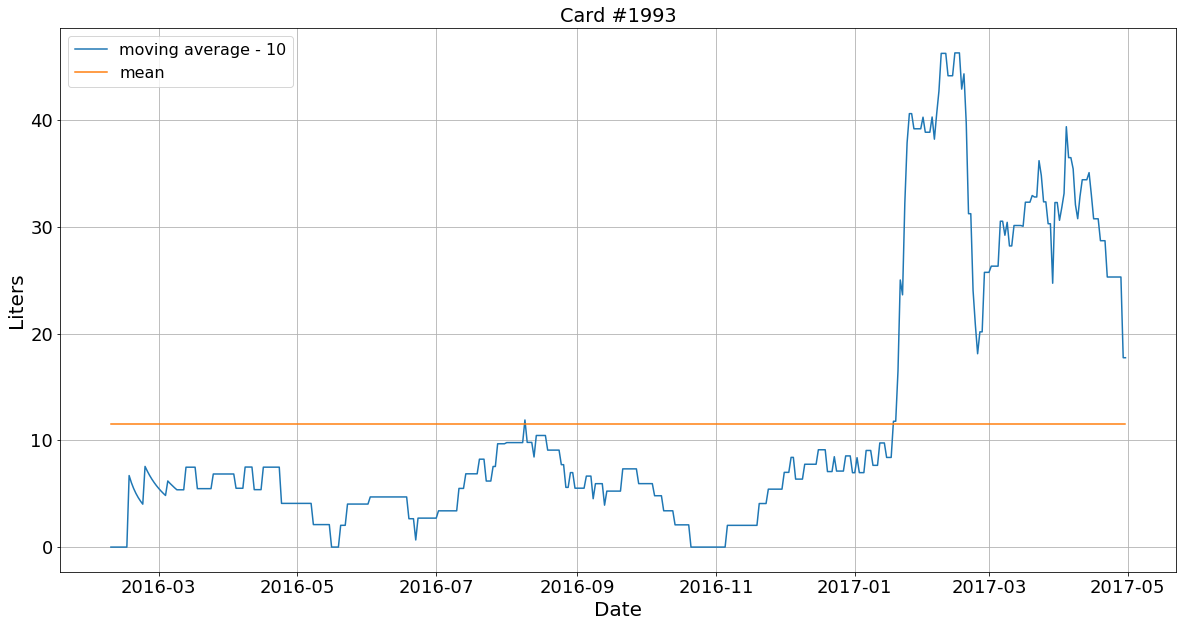

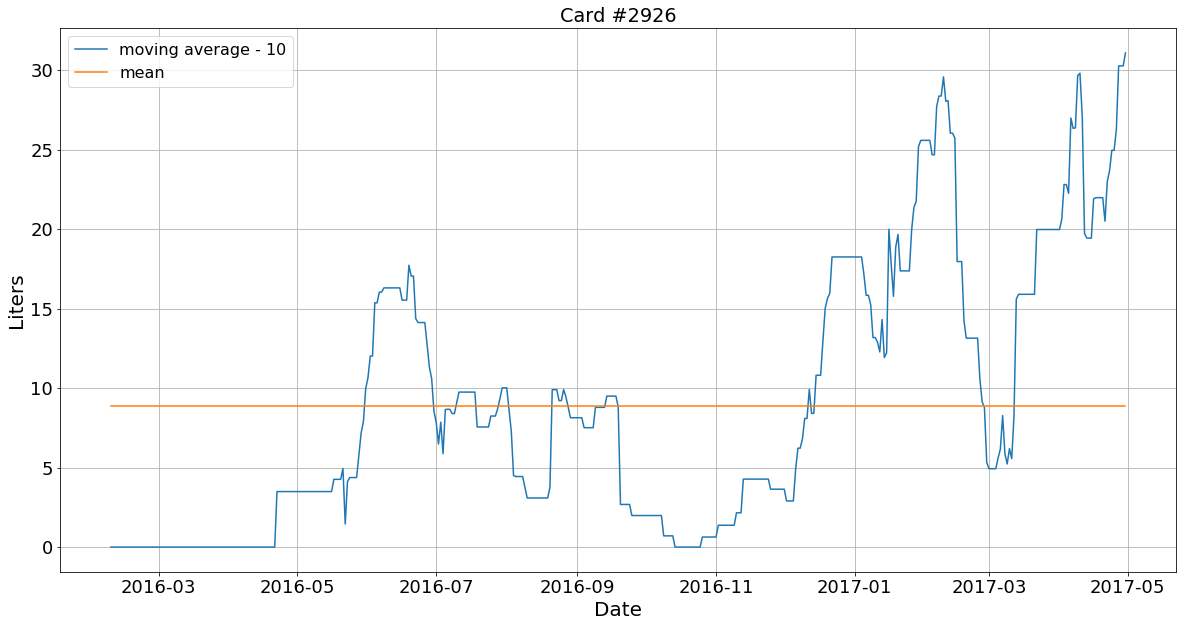

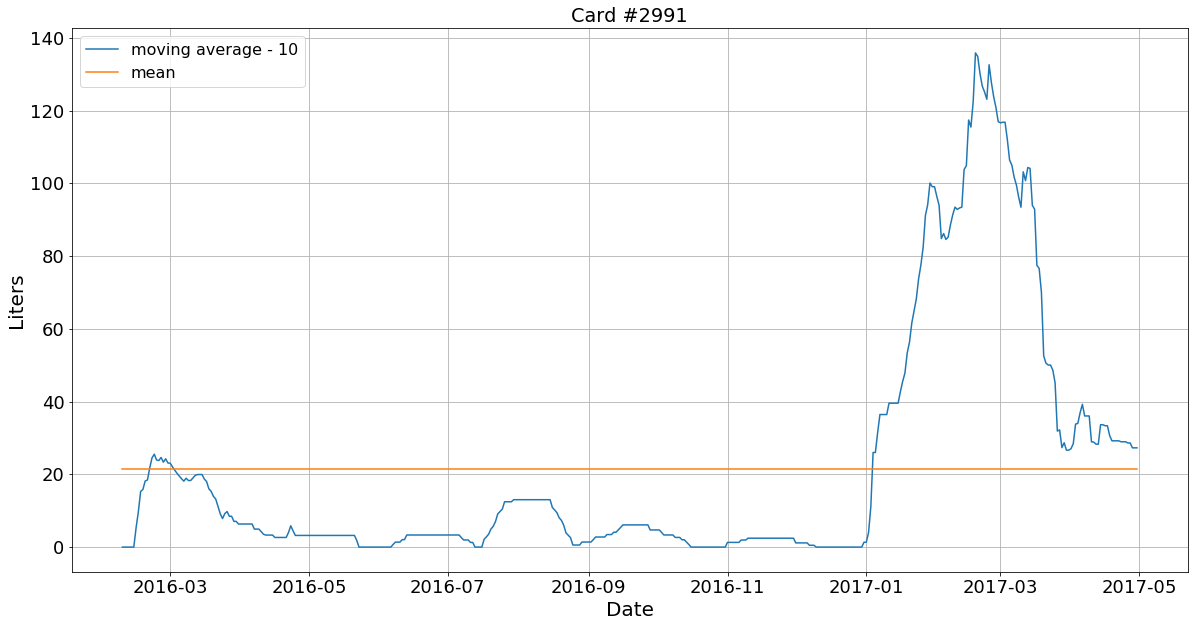

coef= 30
          Rainfall      Gaps
Rainfall  1.000000  0.643783
Gaps      0.643783  1.000000
       Period  Rainfall      Gaps
21 2016-09-22  1.000000  0.669173
22 2016-10-22  0.092119  1.000000
23 2016-11-21  0.010094  0.317669
24 2016-12-21 -0.344767 -0.385338
25 2017-01-20 -0.258625 -0.406015
coef= 30
                 Max_Temperature    Gaps
Max_Temperature           1.0000 -0.0507
Gaps                     -0.0507  1.0000
       Period  Max_Temperature      Gaps
21 2016-09-22         1.000000  0.669173
22 2016-10-22        -0.444347  1.000000
23 2016-11-21        -0.000765  0.317669
24 2016-12-21         0.361674 -0.385338
25 2017-01-20         0.529370 -0.406015
coef= 30
                 Avg_Temperature      Gaps
Avg_Temperature         1.000000  0.160775
Gaps                    0.160775  1.000000
       Period  Avg_Temperature      Gaps
21 2016-09-22         1.000000  0.669173
22 2016-10-22        -0.169431  1.000000
23 2016-11-21         0.088672  0.317669
24 2016-12-21       

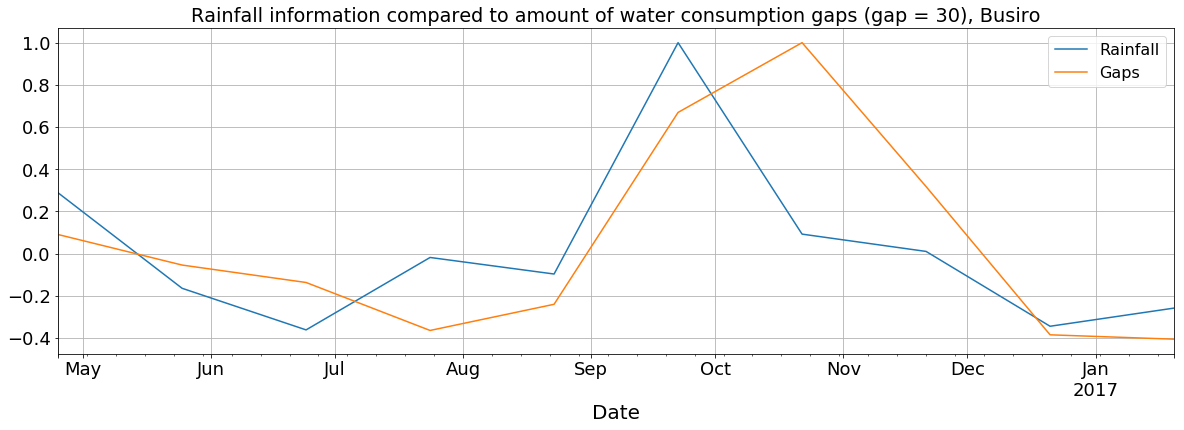

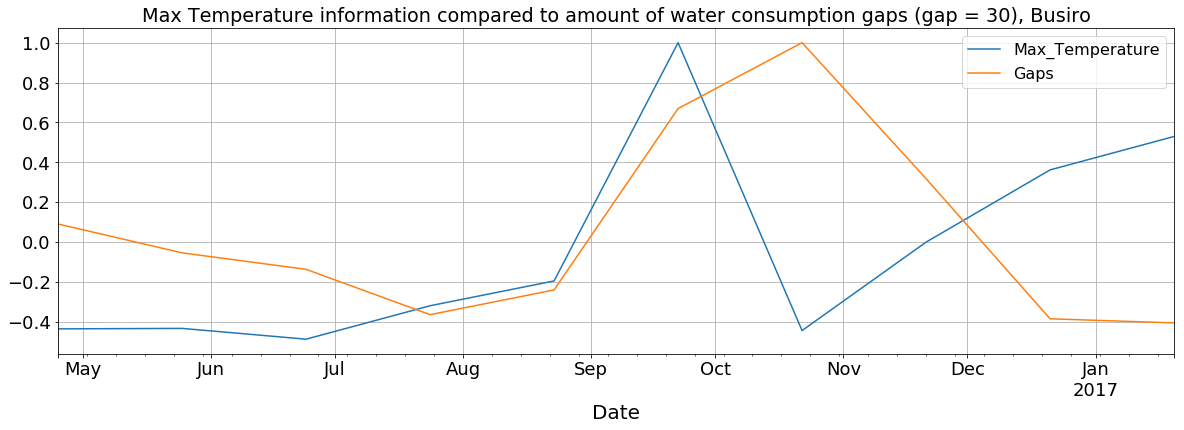

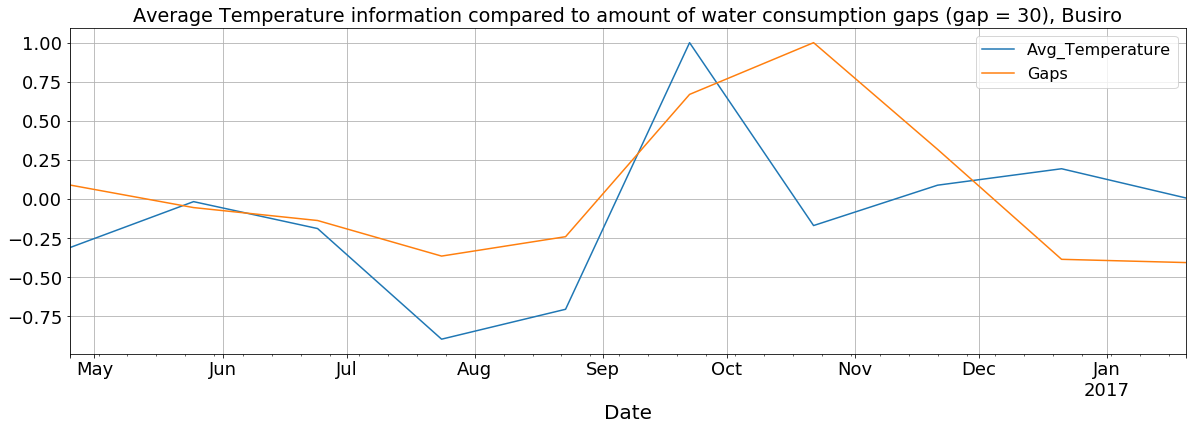

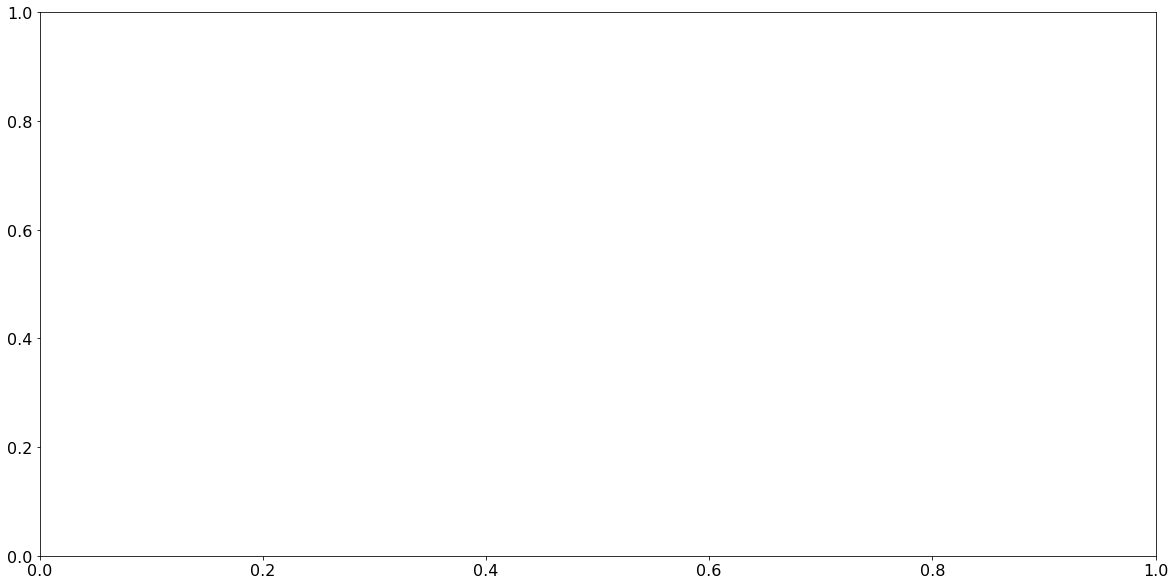

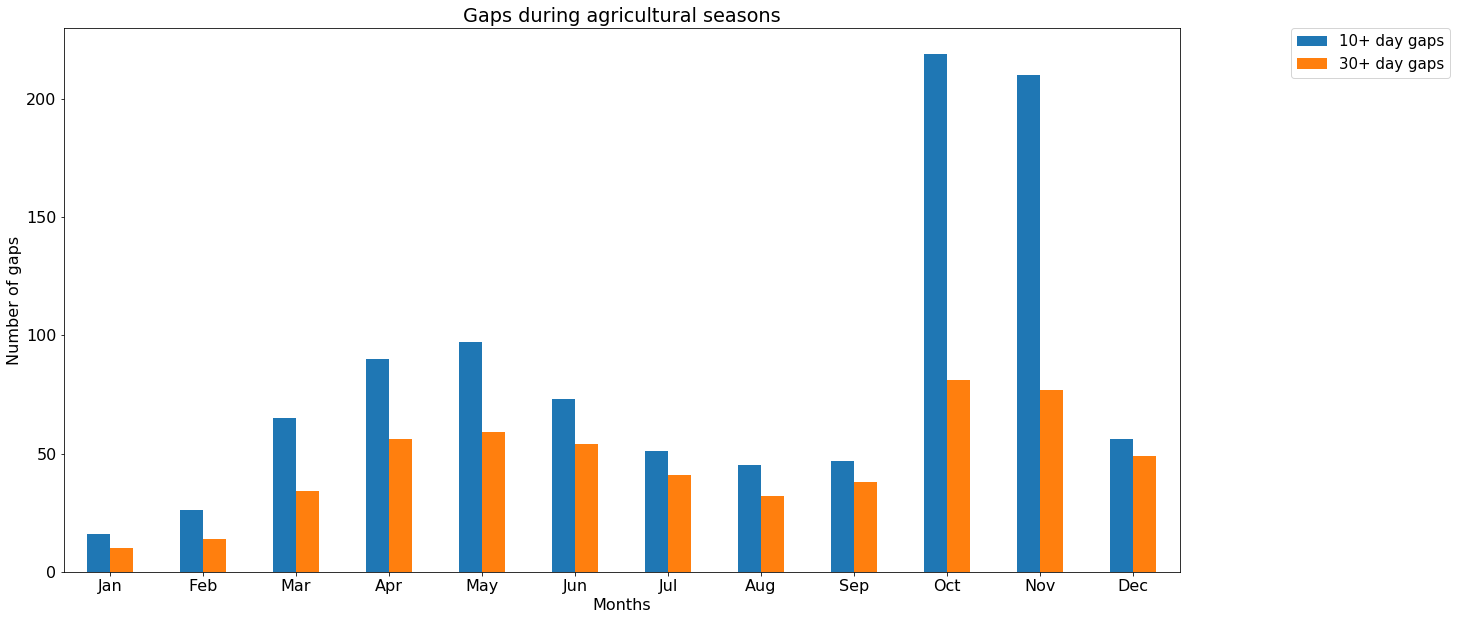

In [27]:
dfTupleBusiro = loadAndProcess(districtPropsBusiro, analysisProps)

In [28]:
dfTupleBusiro[1]

10+ day gaps  30+ day gaps
Season                            
1                 16            10
2                 26            14
3                 65            34
4                 90            56
5                 97            59
6                 73            54
7                 51            41
8                 45            32
9                 47            38
10               219            81
11               210            77
12                56            49

<a id="section8"></a>
# Correlation & Trends Analysis, Dei

Gap duration =  10
cardsWithGaps =  19
cardsWithOneGap =  38
cardsWithoutGaps =  65
gapsSummary =  57
------------------------------------------------------------------------
Gap duration =  20
cardsWithGaps =  14
cardsWithOneGap =  35
cardsWithoutGaps =  73
gapsSummary =  49
------------------------------------------------------------------------
Gap duration =  30
cardsWithGaps =  8
cardsWithOneGap =  34
cardsWithoutGaps =  80
gapsSummary =  42
------------------------------------------------------------------------
coef= 10
          Rainfall     Gaps
Rainfall   1.00000  0.47158
Gaps       0.47158  1.00000
       Period  Rainfall      Gaps
72 2016-12-21 -0.177927  0.087379
73 2016-12-31 -0.203086 -0.252427
74 2017-01-10 -0.219318  0.019417
75 2017-01-20 -0.189452 -0.116505
76 2017-01-30 -0.119412 -0.660194
coef= 10
                 Max_Temperature      Gaps
Max_Temperature         1.000000 -0.010986
Gaps                   -0.010986  1.000000
       Period  Max_Temperature      Gaps


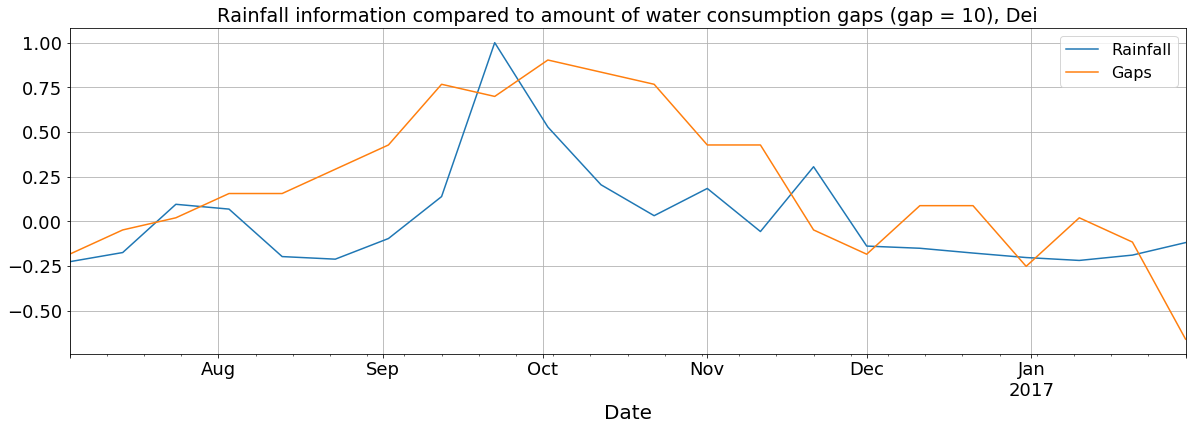

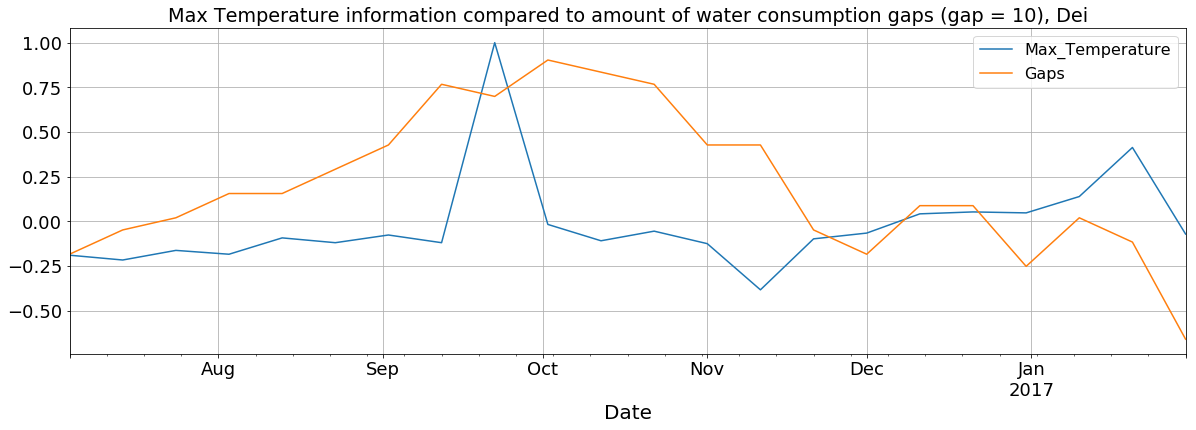

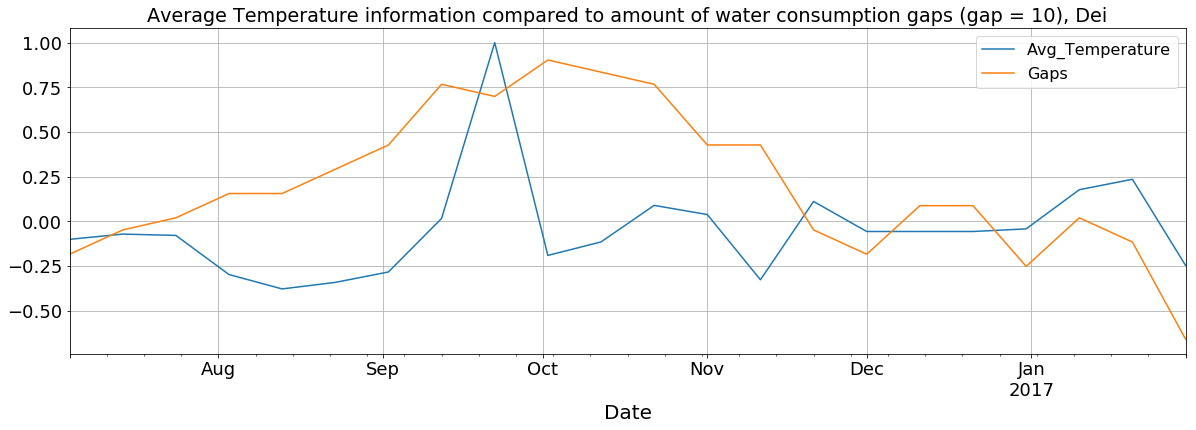

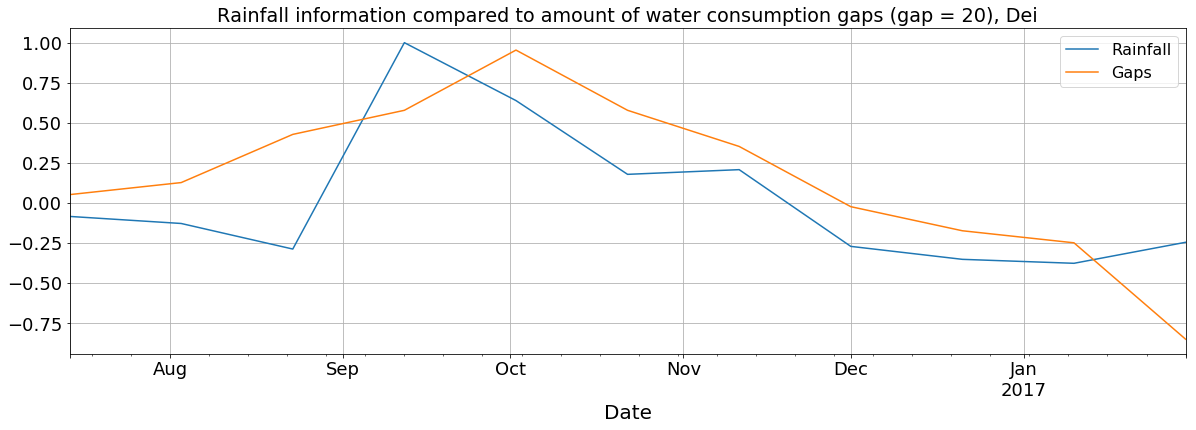

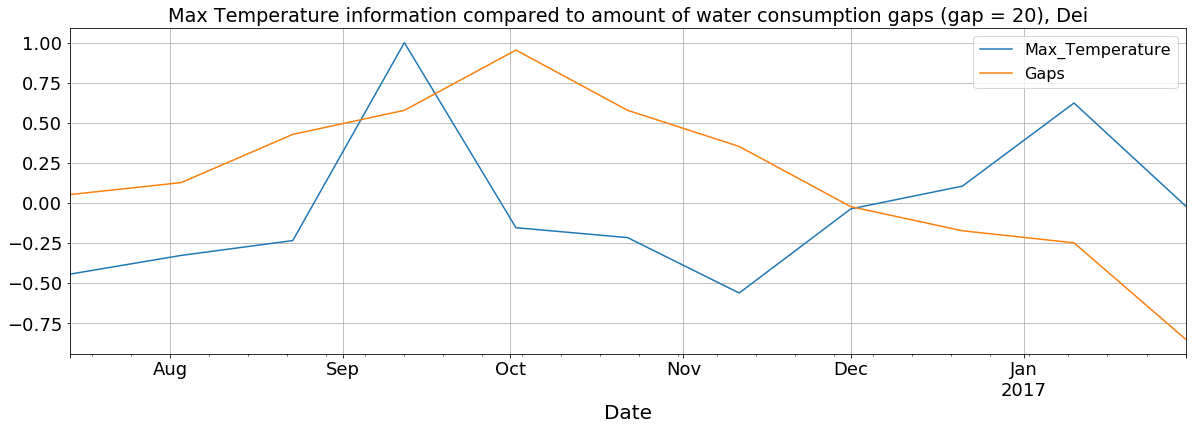

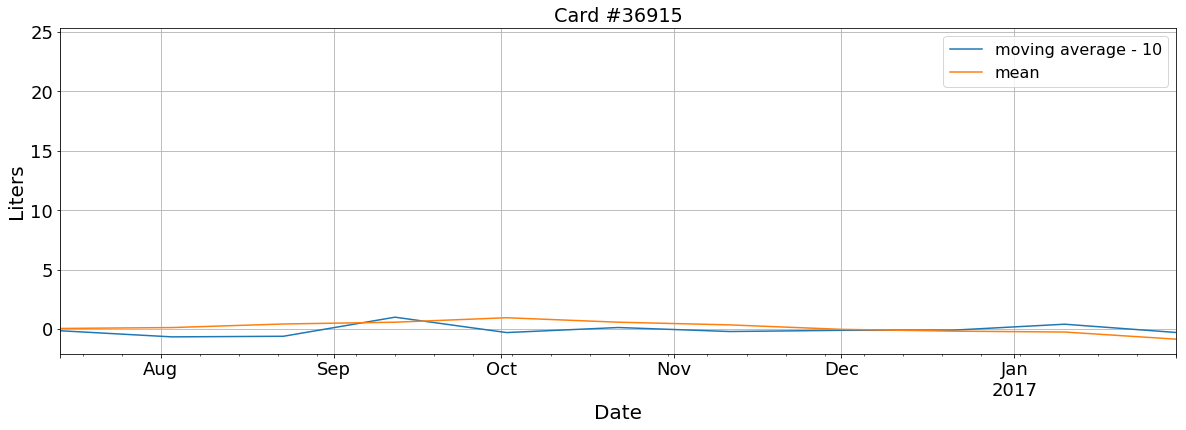

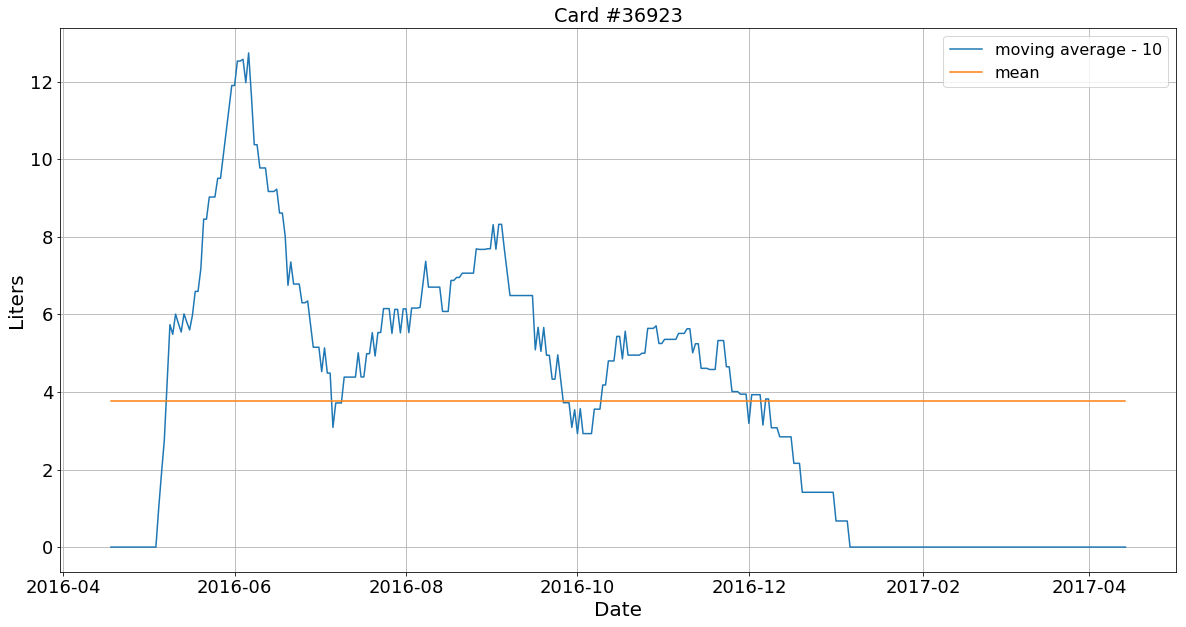

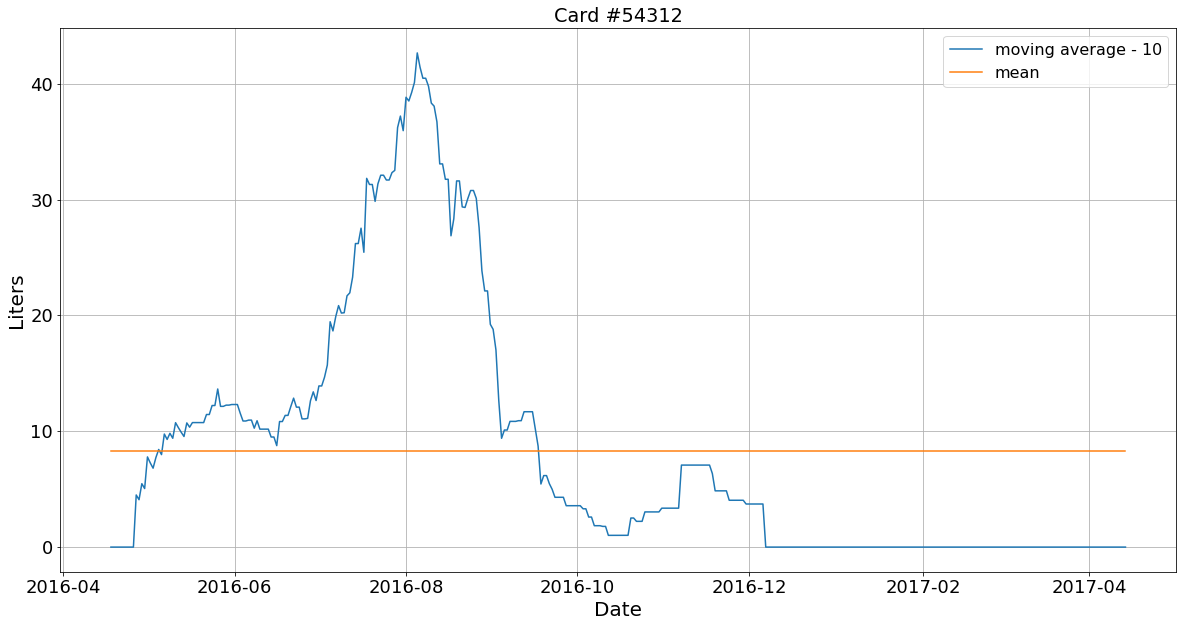

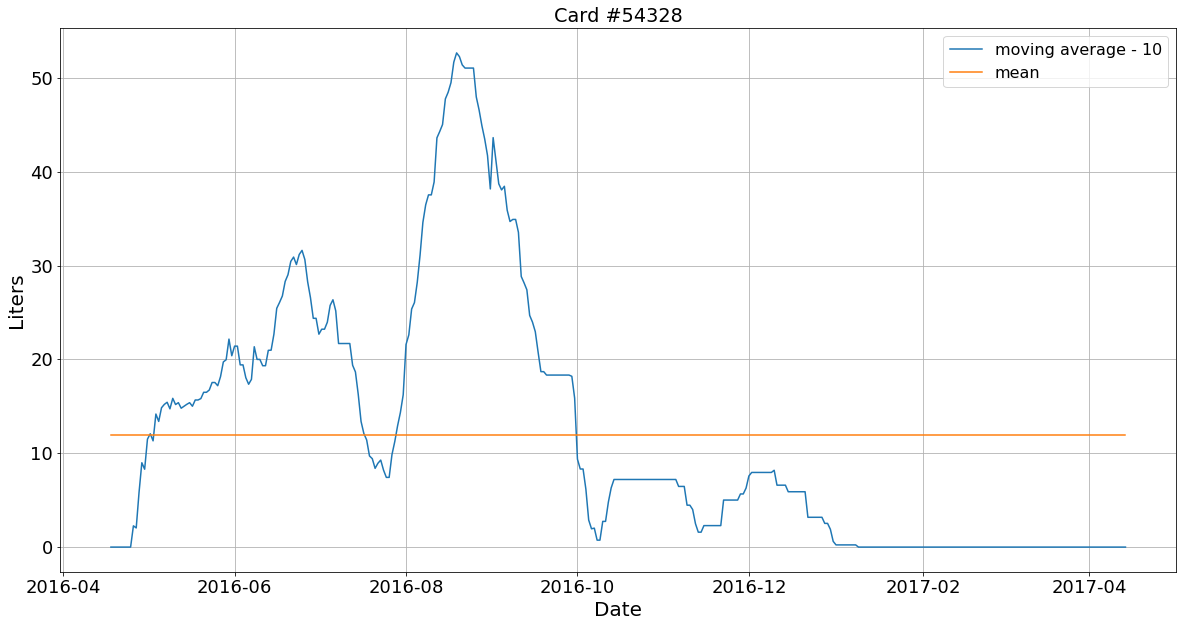

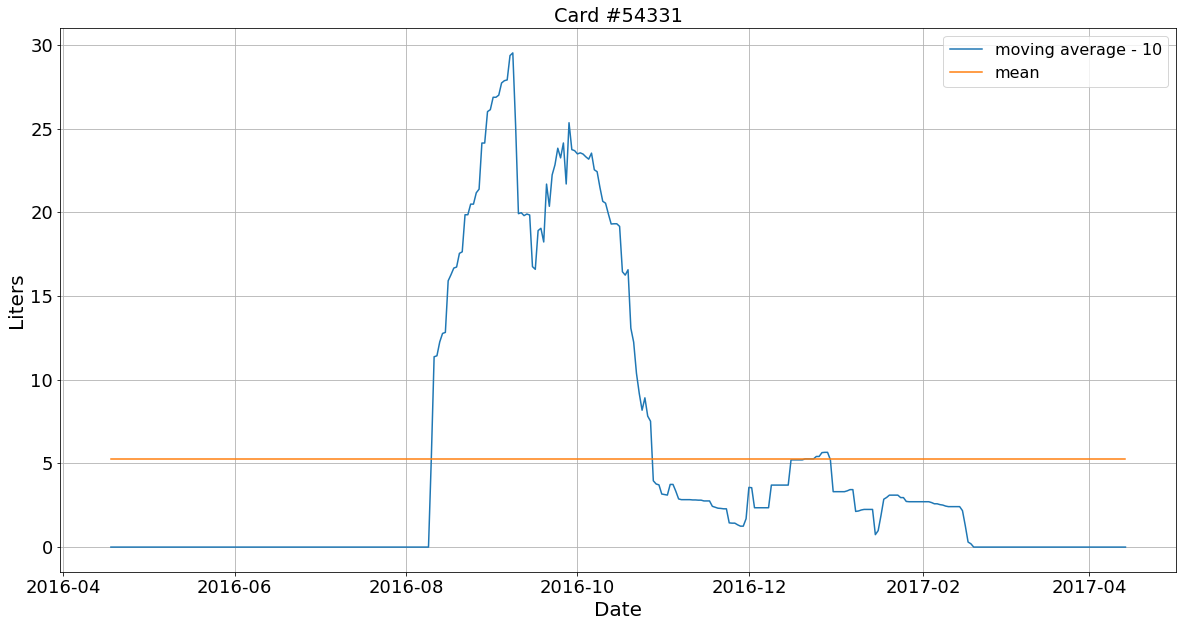

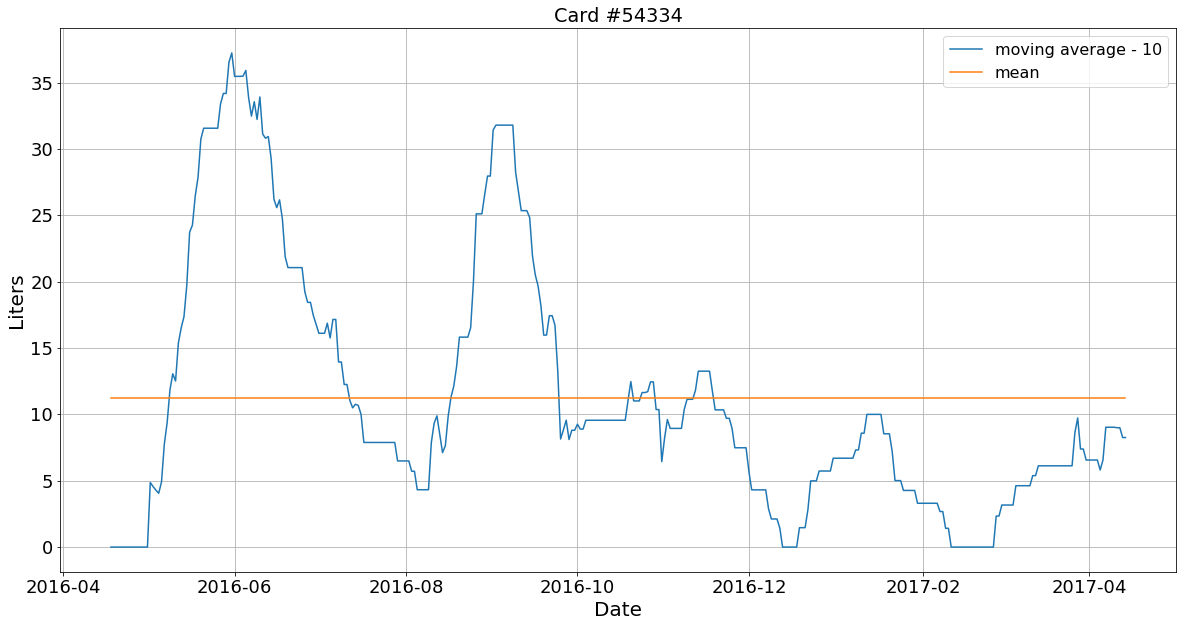

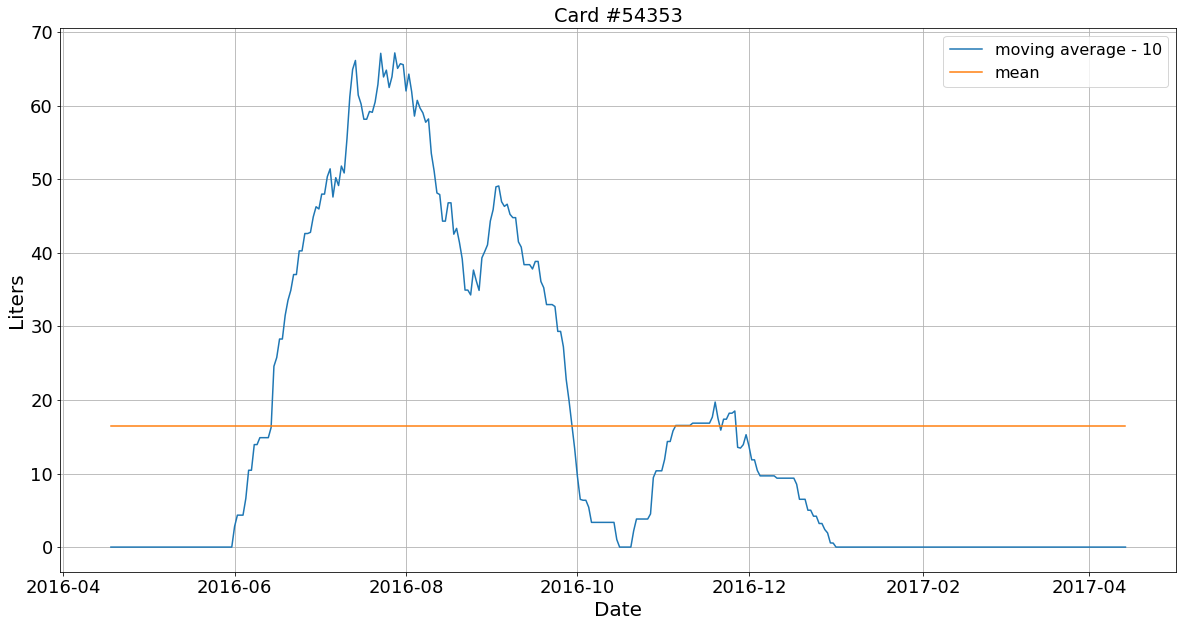

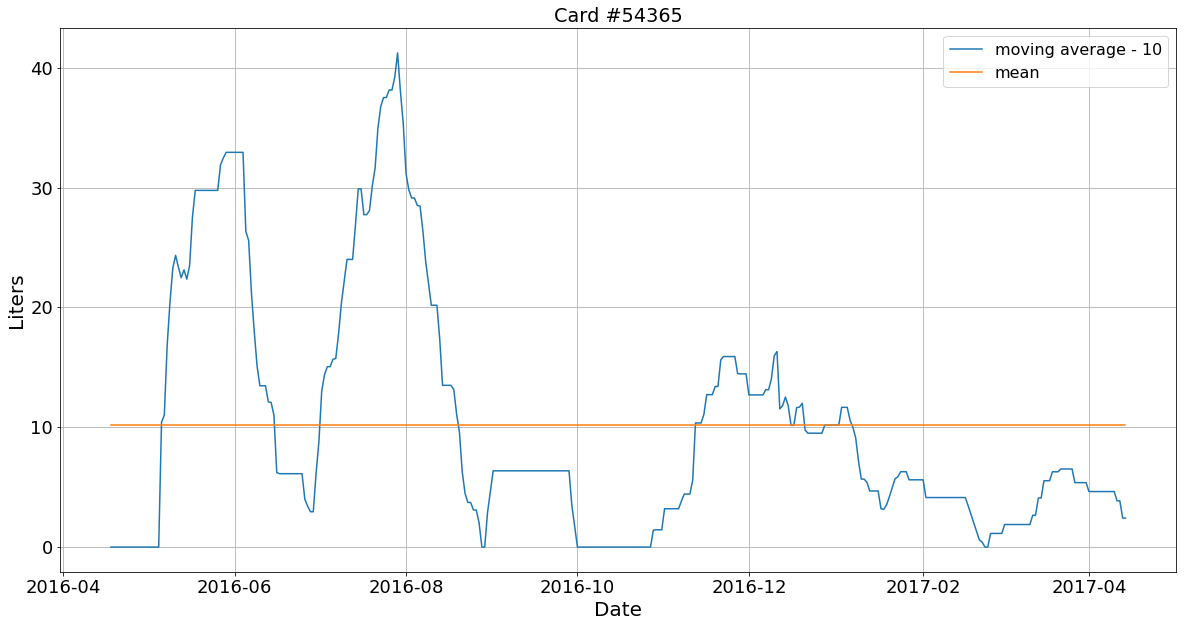

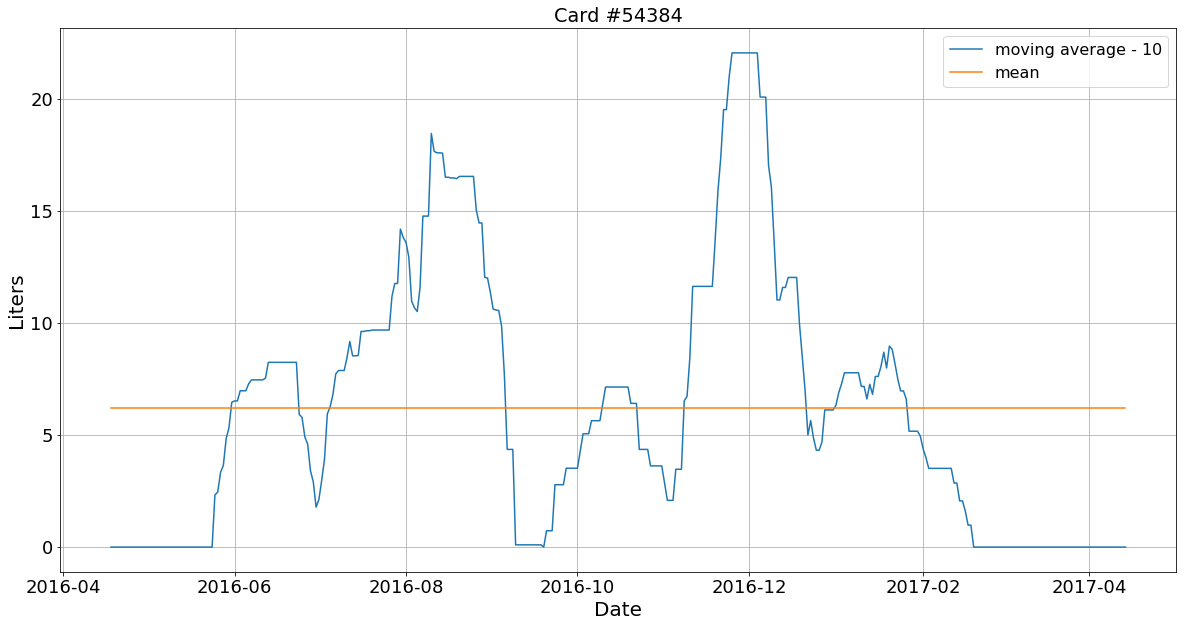

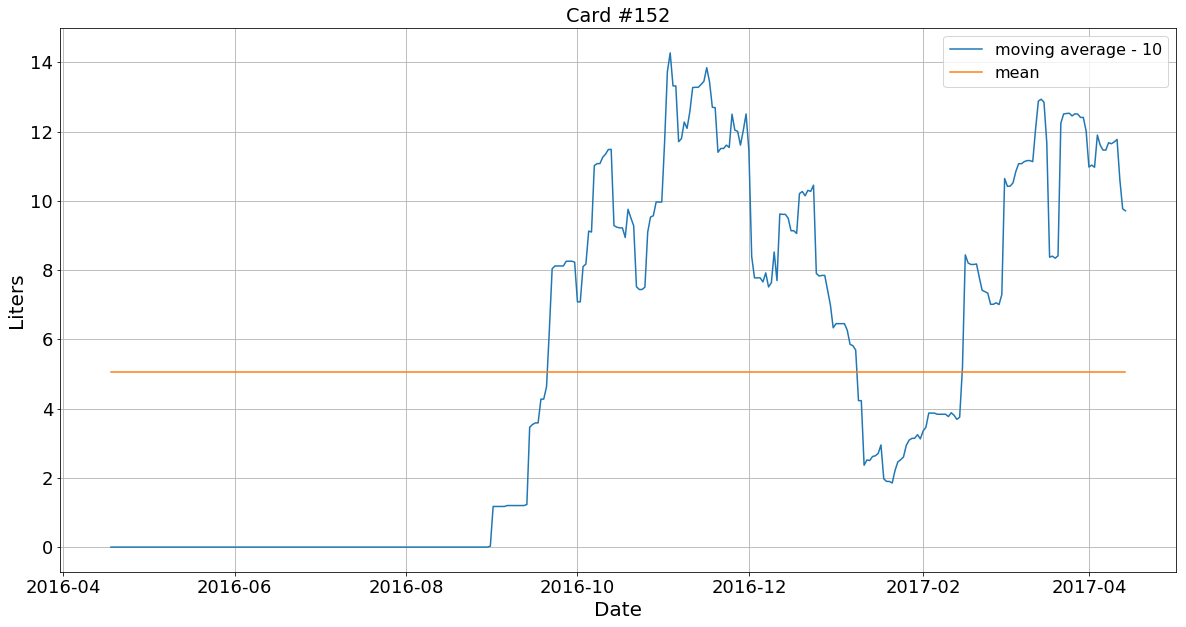

coef= 30
          Rainfall      Gaps
Rainfall  1.000000  0.579503
Gaps      0.579503  1.000000
       Period  Rainfall      Gaps
21 2016-09-22  1.000000  0.692308
22 2016-10-22  0.064205  0.461538
23 2016-11-21 -0.020341  0.076923
24 2016-12-21 -0.386112 -0.076923
25 2017-01-20 -0.297322 -0.769231
coef= 30
                 Max_Temperature      Gaps
Max_Temperature         1.000000 -0.231976
Gaps                   -0.231976  1.000000
       Period  Max_Temperature      Gaps
21 2016-09-22         1.000000  0.692308
22 2016-10-22        -0.739414  0.461538
23 2016-11-21        -0.205212  0.076923
24 2016-12-21         0.231270 -0.076923
25 2017-01-20         0.433225 -0.769231
coef= 30
                 Avg_Temperature      Gaps
Avg_Temperature         1.000000 -0.277911
Gaps                   -0.277911  1.000000
       Period  Avg_Temperature      Gaps
21 2016-09-22         0.973987  0.692308
22 2016-10-22        -0.243582  0.461538
23 2016-11-21         0.025146  0.076923
24 2016-12-21 

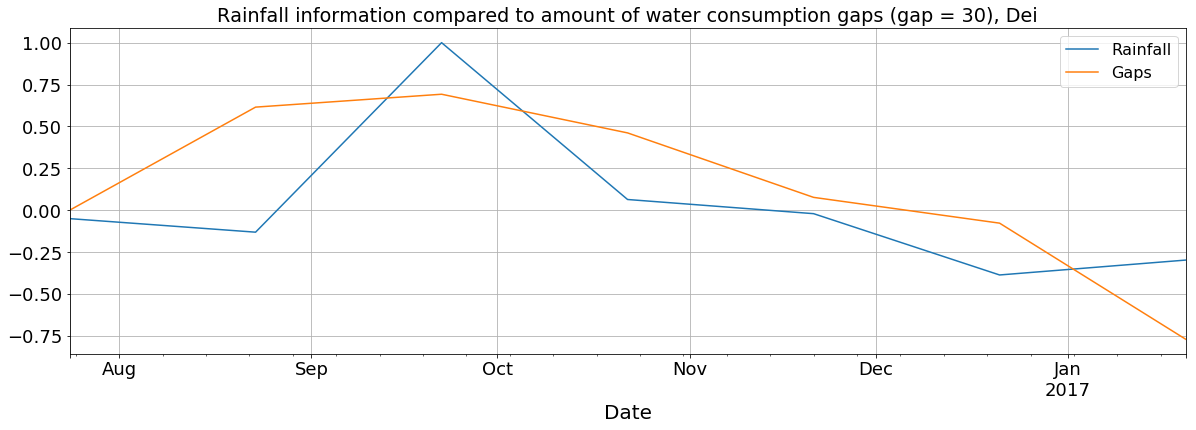

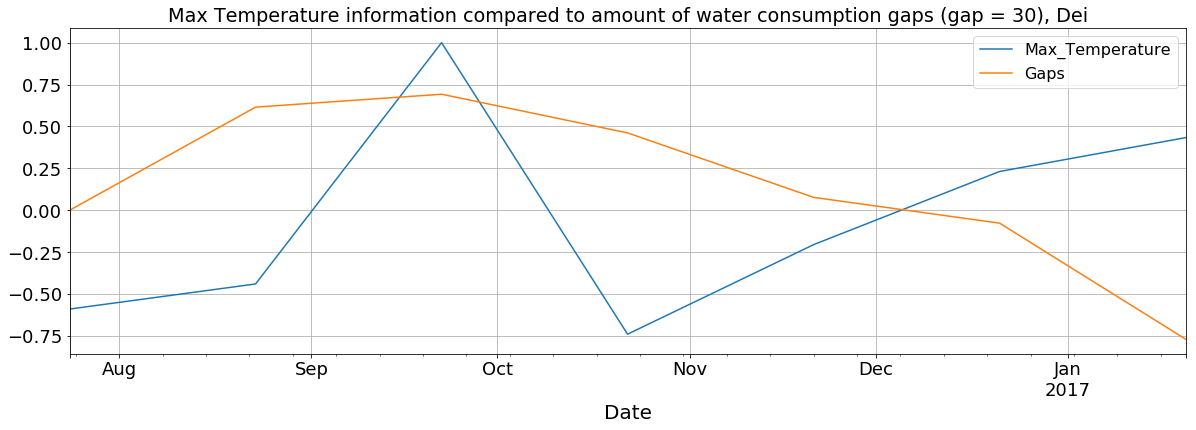

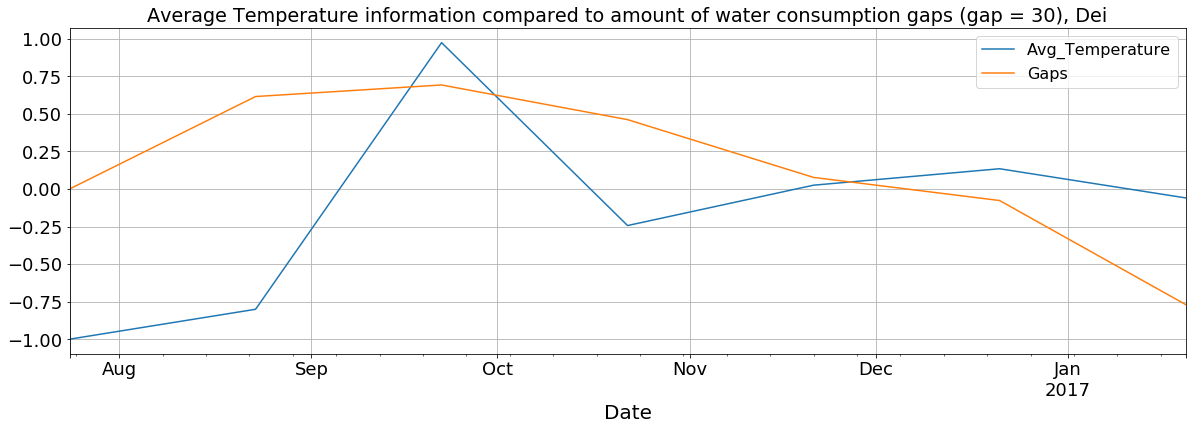

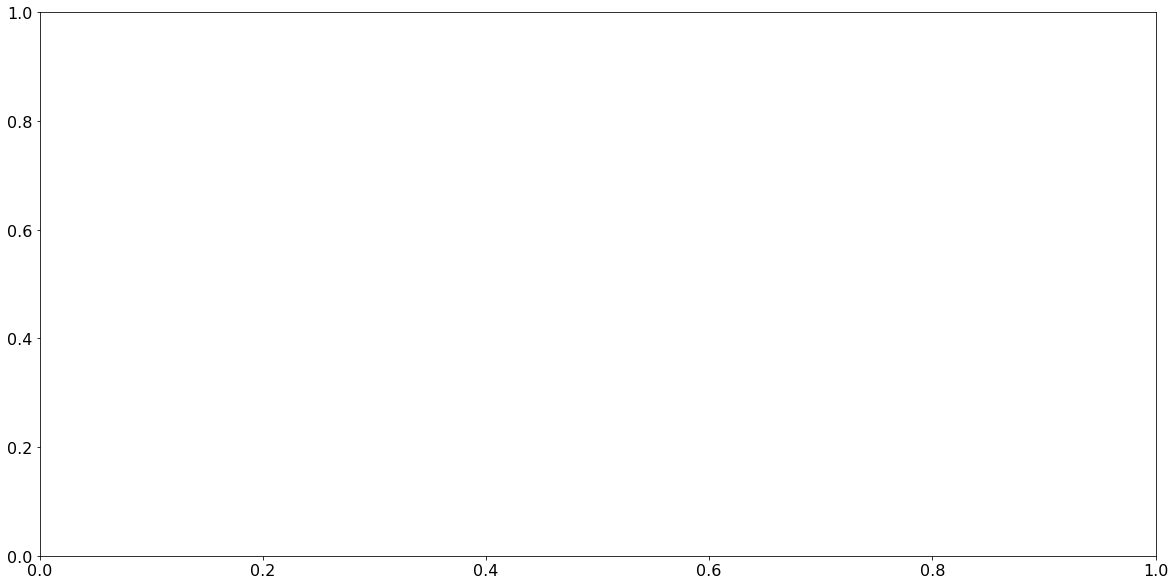

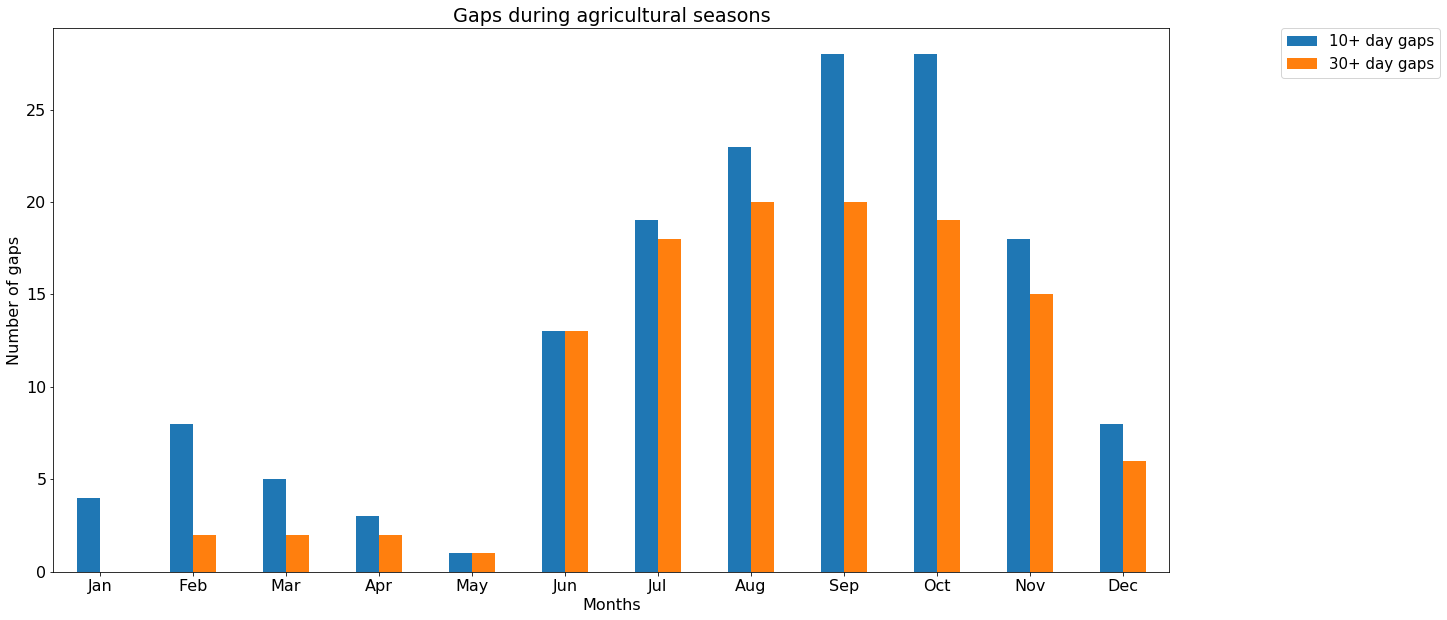

In [29]:
dfTupleDei = loadAndProcess(districtPropsDei, analysisProps)

In [30]:
dfTupleDei[1]

10+ day gaps  30+ day gaps
Season                            
1                  4             0
2                  8             2
3                  5             2
4                  3             2
5                  1             1
6                 13            13
7                 19            18
8                 23            20
9                 28            20
10                28            19
11                18            15
12                 8             6

<a id="section10"></a>
# Correlation & Trends Analysis, Chanhumba

In [31]:
#dfTupleChanhumba = loadAndProcess(districtPropsChanhumba, analysisProps)

In [32]:
#dfTupleChanhumba[1]

<a id="section9"></a>
# Gaps comparison by district

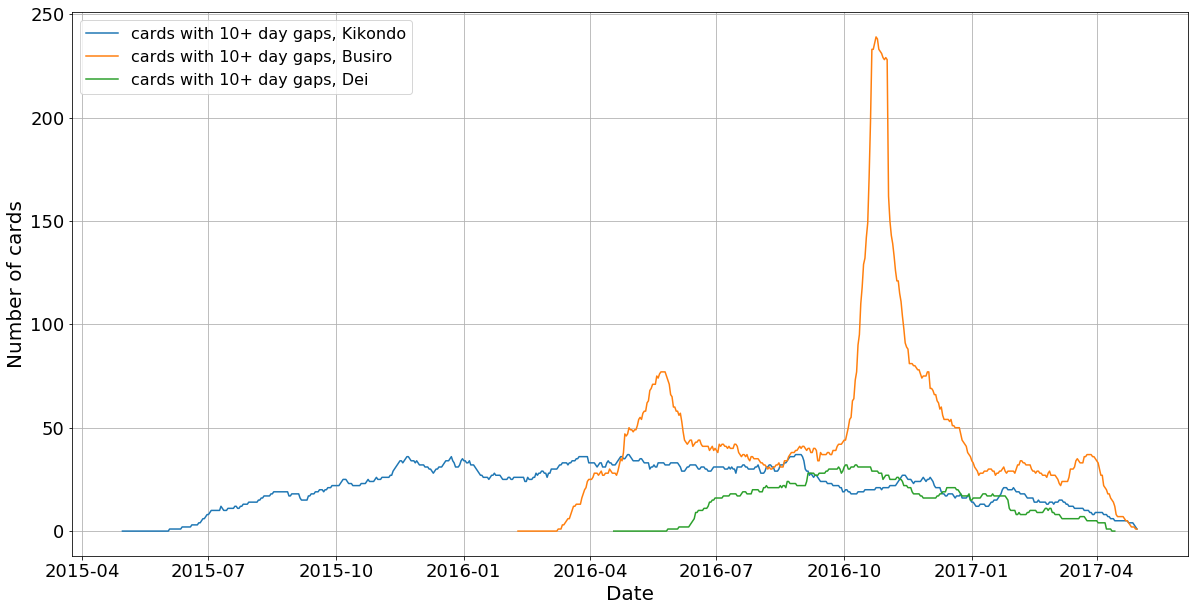

In [33]:
# Here we take two dataframes of cards with gaps for 10+ days period
data = [dfTupleKikondo[0][0],dfTupleBusiro[0][0],dfTupleDei[0][0]]

plotGaps(data)

In [34]:
busiroDF = prepareTransactionData(waterUsageRDD_Busiro)
kikondoDF = prepareTransactionData(waterUsageRDD_Kikondo)
deiDF = prepareTransactionData(waterUsageRDD_Dei)
#chanhumbaDF = prepareTransactionData(waterUsageRDD_Chanhumba)

busiroDF_Copy = busiroDF.copy()
busiroDF_Copy.date =  pd.to_datetime(busiroDF_Copy.date, format='%Y-%m-%d')
kikondoDF_Copy = kikondoDF.copy()
kikondoDF_Copy.date =  pd.to_datetime(kikondoDF_Copy.date, format='%Y-%m-%d')
deiDF_Copy = deiDF.copy()
deiDF_Copy.date =  pd.to_datetime(deiDF_Copy.date, format='%Y-%m-%d')
#chanhumbaDF_Copy = chanhumbaDF.copy()
#chanhumbaDF_Copy.date =  pd.to_datetime(chanhumbaDF_Copy.date, format='%Y-%m-%d')

activeCardGapsListKikondo = []
activeCardGapsListBusiro = []
activeCardGapsListDei = []
#activeCardGapsListChanhumba = []

for i in range(0, len(dfTupleKikondo[0])):
    df = pd.merge(kikondoDF_Copy, dfTupleKikondo[0][i], on='date', how='inner')
    df.gaps = df.gaps / df.active_cards * 100
    activeCardGapsListKikondo.append(df)
    
for i in range(0, len(dfTupleBusiro[0])):
    df = pd.merge(busiroDF_Copy, dfTupleBusiro[0][i], on='date', how='inner')
    df.gaps = df.gaps / df.active_cards * 100
    activeCardGapsListBusiro.append(df)
    
for i in range(0, len(dfTupleDei[0])):
    df = pd.merge(deiDF_Copy, dfTupleDei[0][i], on='date', how='inner')
    df.gaps = df.gaps / df.active_cards * 100
    activeCardGapsListDei.append(df)
    
#for i in range(0, len(dfTupleChanhumba[0])):
#    df = pd.merge(chanhumbaDF_Copy, dfTupleChanhumba[0][i], on='date', how='inner')
#    df.gaps = df.gaps / df.active_cards * 100
#    activeCardGapsListChanhumba.append(df)


activeCardGapsListKikondo[0] = activeCardGapsListKikondo[0].sort_values('date', ascending = True)
activeCardGapsListBusiro[0] = activeCardGapsListBusiro[0].sort_values('date', ascending = True)
activeCardGapsListDei[0] = activeCardGapsListDei[0].sort_values('date', ascending = True)
#activeCardGapsListChanhumba[0] = activeCardGapsListChanhumba[0].sort_values('date', ascending = True)
dataNew = [activeCardGapsListKikondo[0], activeCardGapsListBusiro[0], activeCardGapsListDei[0]]

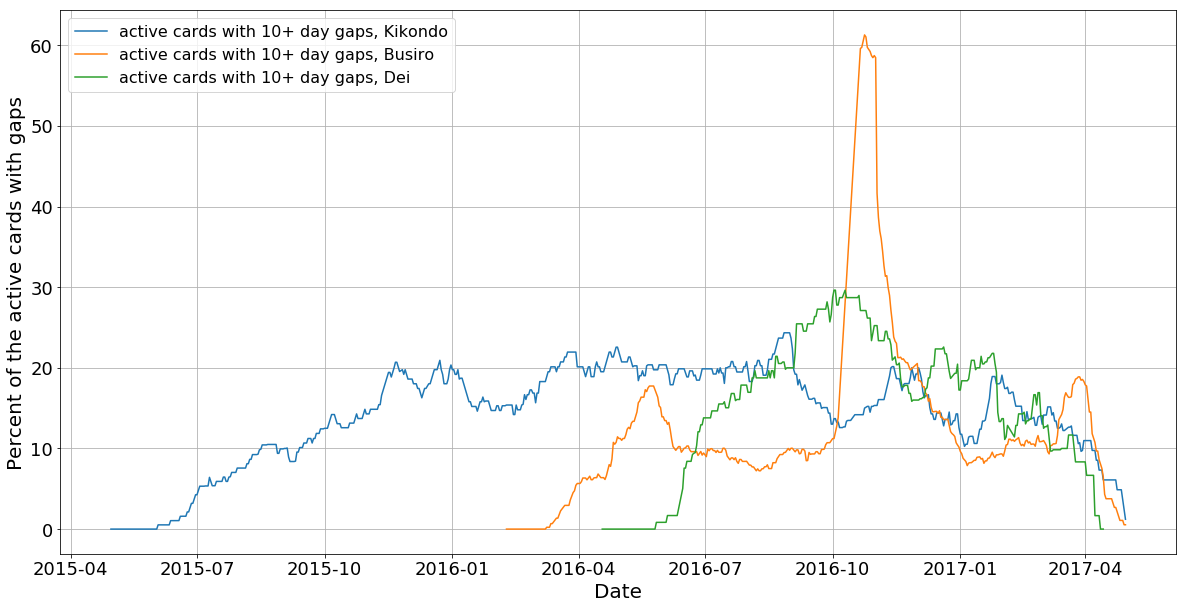

In [35]:
plotActiveCardsGaps(dataNew) 